In [1]:
import os
import pickle as pkl
from joblib import load, dump
import cv2
import matplotlib
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15909920964915730269
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15898536151983058539
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7564915280391310089
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5324235072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6917478131544382337
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:

MODEL_LIST = []
MODEL_NAMES = ['skin_disease_resnet_No_AUG_88acc', 'resnet_model1_cifar10']

for i in range(len(MODEL_NAMES)):
    ### Loading DNN models 
    with open('Models/'+ MODEL_NAMES[i]+'.json', 'r') as j_file:
        loaded_model_json = j_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights("Models/"+MODEL_NAMES[i]+".h5")
    if (MODEL_NAMES[i] == 'skin_disease_resnet_No_AUG_88acc'):
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
                      metrics=['acc'])
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                      loss = "categorical_crossentropy",  metrics= ['accuracy'])
    MODEL_LIST.append(model)



# Cifar 10

In [3]:
### Cifar model benchmark
def loadPreprocessCifar10():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

trainX, trainY, testX, testY = loadPreprocessCifar10()

In [4]:

extractor0  = tf.keras.Model(inputs = MODEL_LIST[0].input,
                         outputs = MODEL_LIST[0].get_layer(MODEL_LIST[0].layers[-5].name).output
                        )
extractor1  = tf.keras.Model(inputs = MODEL_LIST[1].input,
                         outputs = MODEL_LIST[1].get_layer(MODEL_LIST[1].layers[-5].name).output
                        )
### Predictions
#p = model1.predict(trainX,verbose = 1)
#print("Model Evaluation")
#MODEL_LIST[1].evaluate(testX, testY, verbose =1)

In [5]:
"""print("Extracting Features......")
print("May take a while")
feat0 = []
feat1 = []
for i in tqdm(range(len(trainX))):
    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)
    feat0.append(extractor0.predict(tmp))
    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))   
"""

'print("Extracting Features......")\nprint("May take a while")\nfeat0 = []\nfeat1 = []\nfor i in tqdm(range(len(trainX))):\n    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)\n    feat0.append(extractor0.predict(tmp))\n    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))   \n'

In [6]:
#np.save("data/train_feat0.npy", np.vstack(feat0))
#np.save("data/train_feat1.npy", np.vstack(feat1))
train_feat0 = np.load("data/train_feat0.npy")
train_feat1 = np.load("data/train_feat1.npy")
### Load Testing features 
test_feat0 = np.load("data/test_feat0.npy")
test_feat1 = np.load("data/test_feat1.npy")

In [7]:
"""print("Extracting Features......")
print("May take a while")
test_feat0 = []
test_feat1 = []
for i in tqdm(range(len(testX))):
    tmp = np.expand_dims(cv2.resize(testX[i], (200,200)), axis = 0)
    test_feat0.append(extractor0.predict(tmp))
    test_feat1.append(extractor1.predict(np.expand_dims(testX[i], axis = 0)))    
"""

'print("Extracting Features......")\nprint("May take a while")\ntest_feat0 = []\ntest_feat1 = []\nfor i in tqdm(range(len(testX))):\n    tmp = np.expand_dims(cv2.resize(testX[i], (200,200)), axis = 0)\n    test_feat0.append(extractor0.predict(tmp))\n    test_feat1.append(extractor1.predict(np.expand_dims(testX[i], axis = 0)))    \n'

In [8]:
### Selecting the classes
hold_in_train_class = [0,1,2,3,4]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(trainY,i)

In [9]:
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC
s1 = SVC(kernel = 'linear')
s2 = SVC(kernel = 'rbf')
s3 = SVC(kernel = 'poly')
s4 = SVC(kernel = 'sigmoid')
s5 = SVC(C = 10)
estimators = [('linSVC',s1),('rbfSVC',s2),('polySVC', s3),('sigmoid',s4),('SVC10', s5)]

vote = VotingClassifier(estimators)
vote.fit(train_feat1[hold_in_train_class_idx], np.argmax(trainY[hold_in_train_class_idx], axis =1))


#svc1.fit(np.vstack(train_feat1),np.argmax(trainY, axis = 1))

VotingClassifier(estimators=[('linSVC', SVC(kernel='linear')),
                             ('rbfSVC', SVC()), ('polySVC', SVC(kernel='poly')),
                             ('sigmoid', SVC(kernel='sigmoid')),
                             ('SVC10', SVC(C=10))])

In [10]:
### Selecting the classes
hold_in_test_classes = [0,1,2,3,4]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(testY,i)

In [11]:
from sklearn.metrics import accuracy_score 
groundTruth =np.argmax(testY[hold_in_test_classes_idx], axis = 1)
pred = vote.predict(np.vstack(test_feat1[hold_in_test_classes_idx]))

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(groundTruth, pred, average = "macro")
acc = accuracy_score(groundTruth, pred)
recall = recall_score(groundTruth, pred,   average = "macro")

precision =precision_score(groundTruth, pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth), 
                tf.keras.utils.to_categorical(pred))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 1.1466873764038086
Accuracy: 0.9668
F1 Score: 0.9667639346703527
recall Score: 0.9667999999999999
Precision Score: 0.9669817495461437


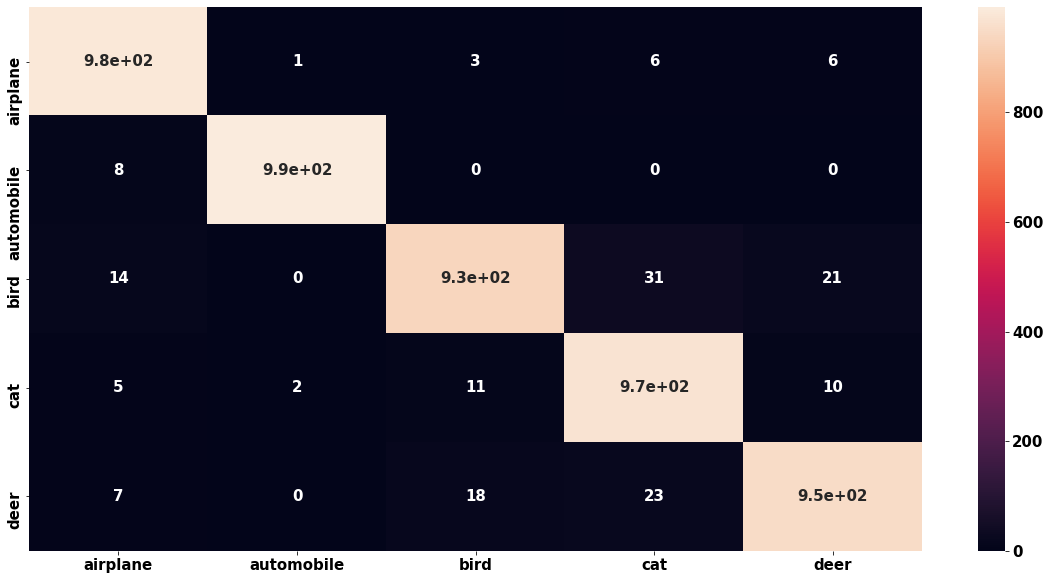

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
                'truck']
df_cm = pd.DataFrame(np.array(conf), index = labels_names[:5],
                  columns =  labels_names[:5])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_svm/conf_Cifar old Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/conf_Cifar old Classes.pdf", dpi = 200)

<ipython-input-14-c5f2a4d85fde>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


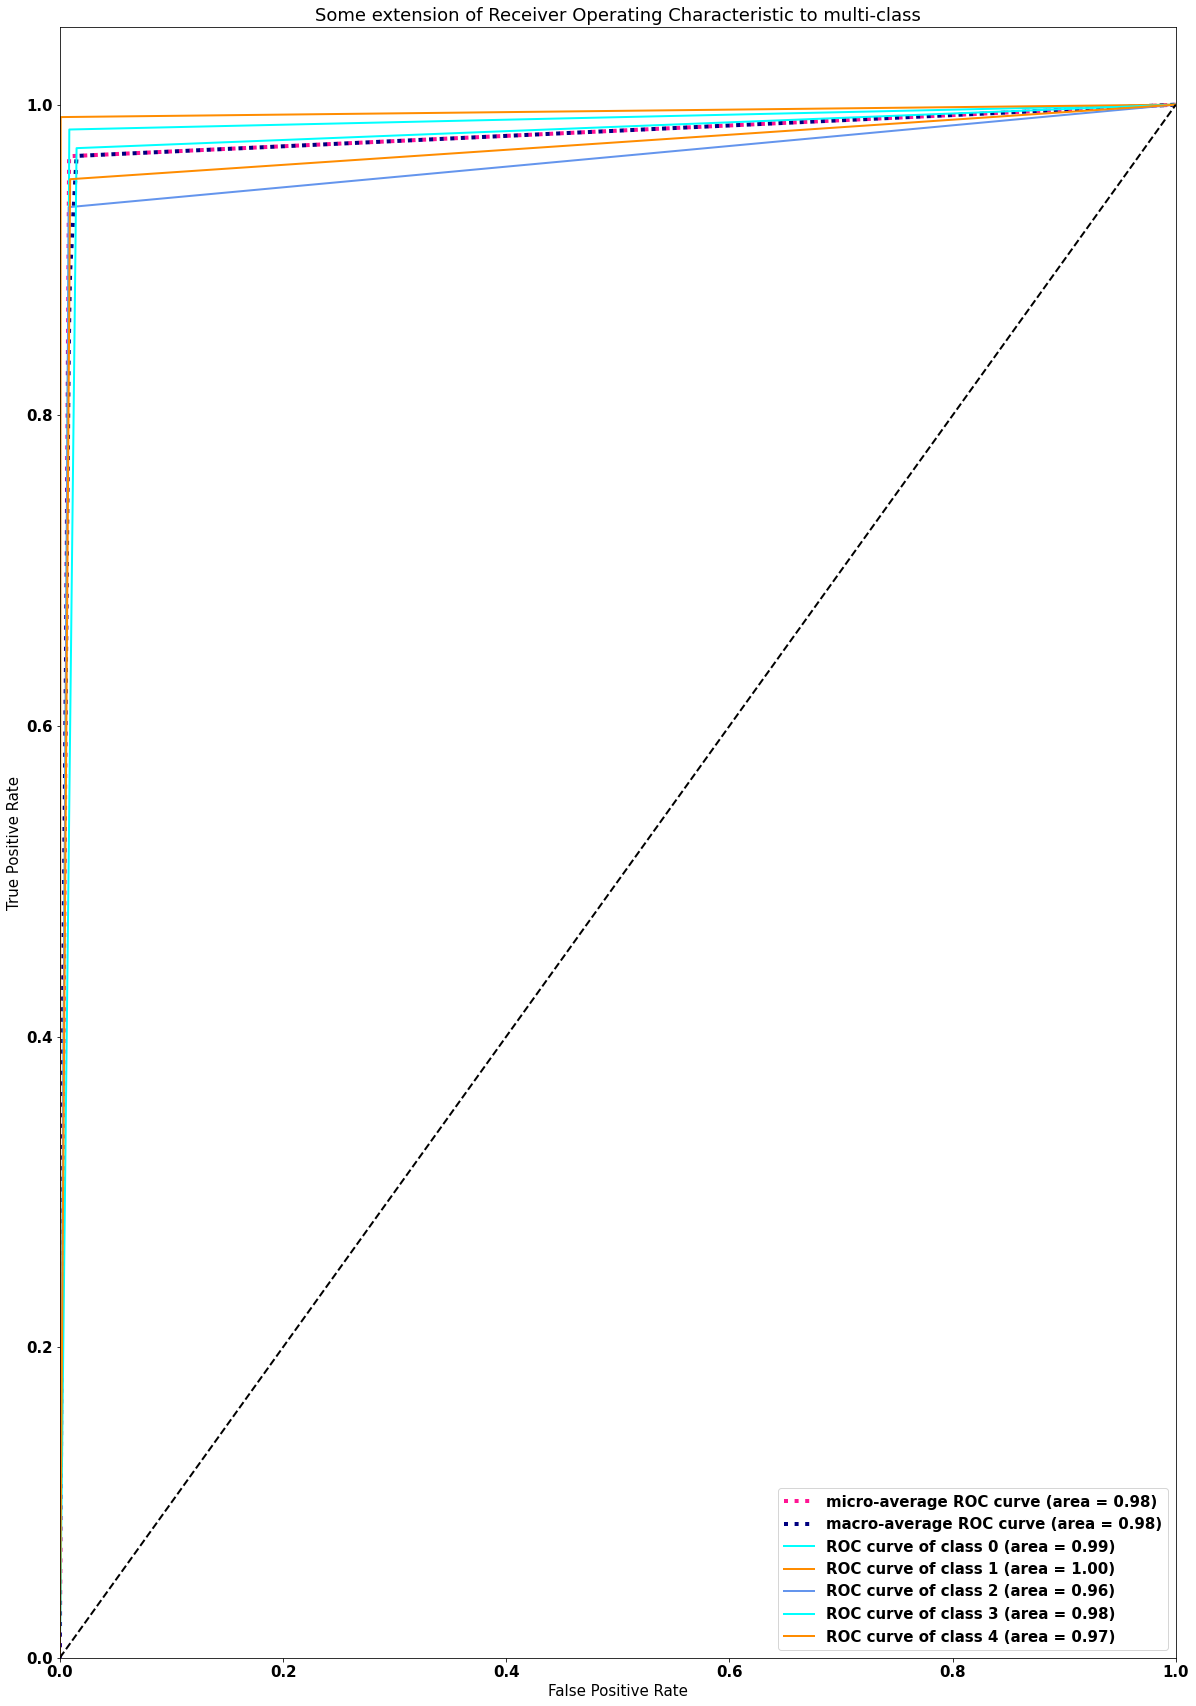

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(tf.keras.utils.to_categorical(pred))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_svm/roc_Cifar old Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/roc_Cifar old Classes.pdf", dpi = 200)
plt.show()

In [15]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)


In [16]:
cclasses = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck']

Class #0


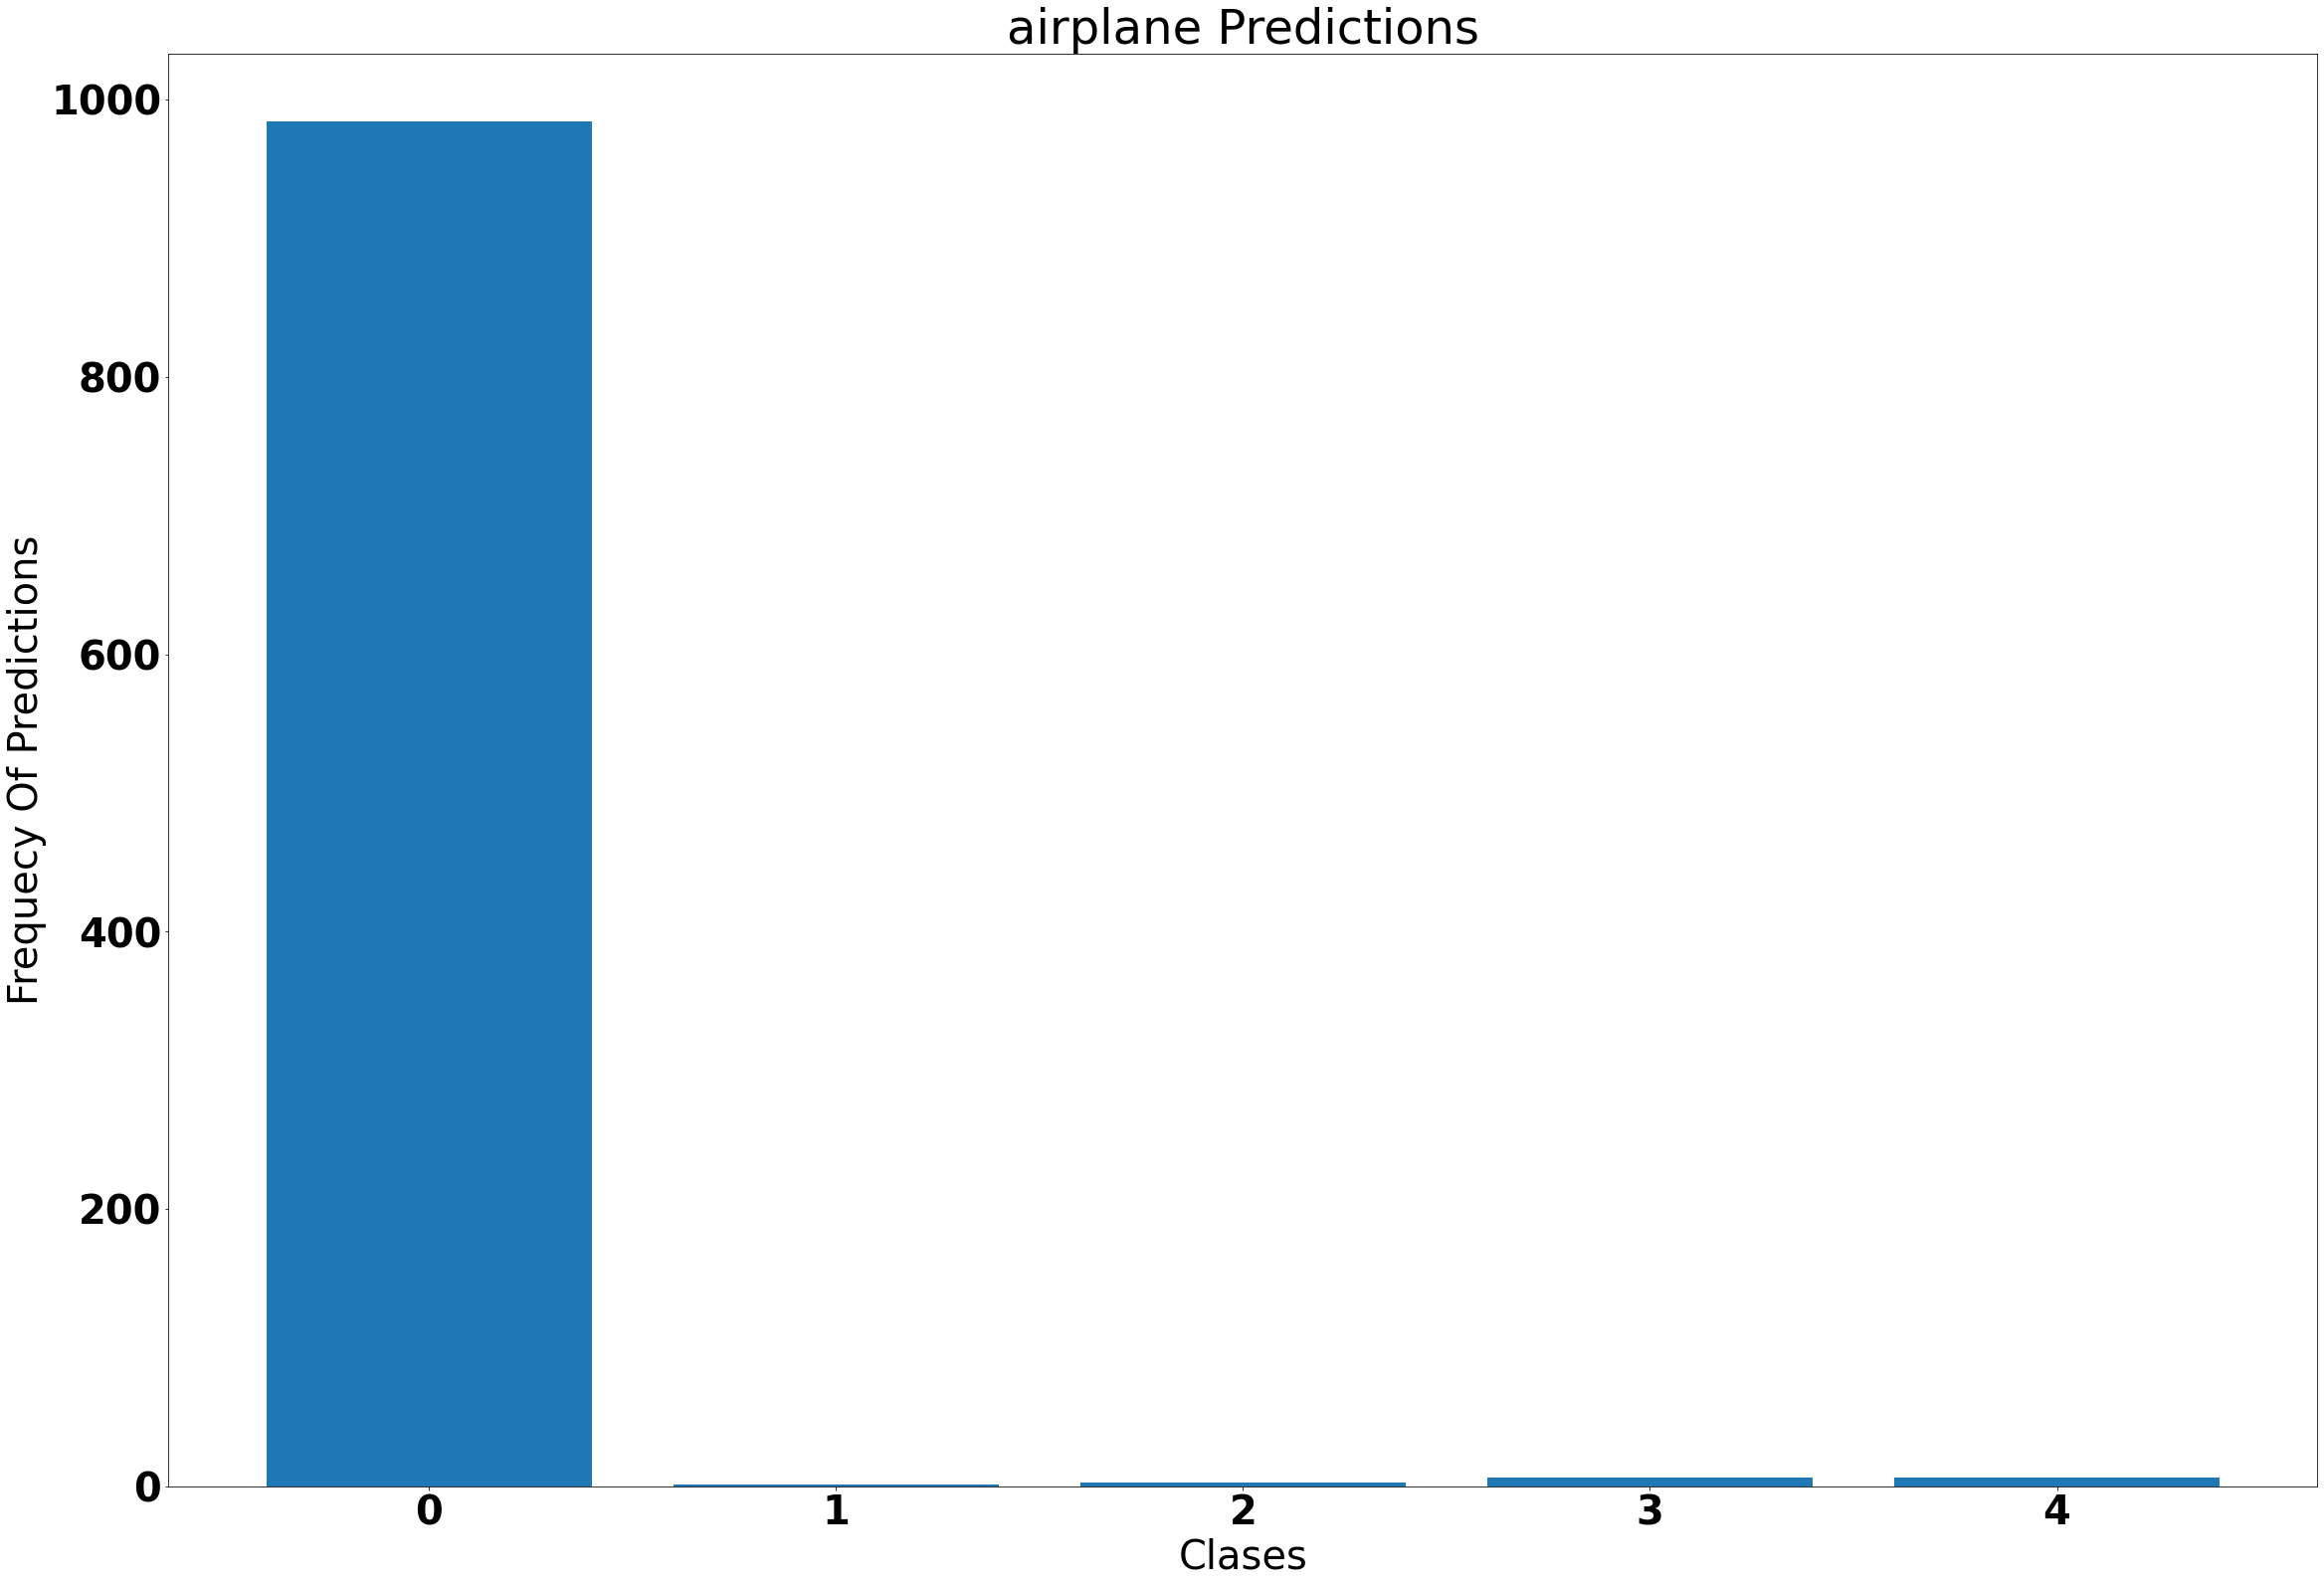

In [17]:
idx = 0
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #1


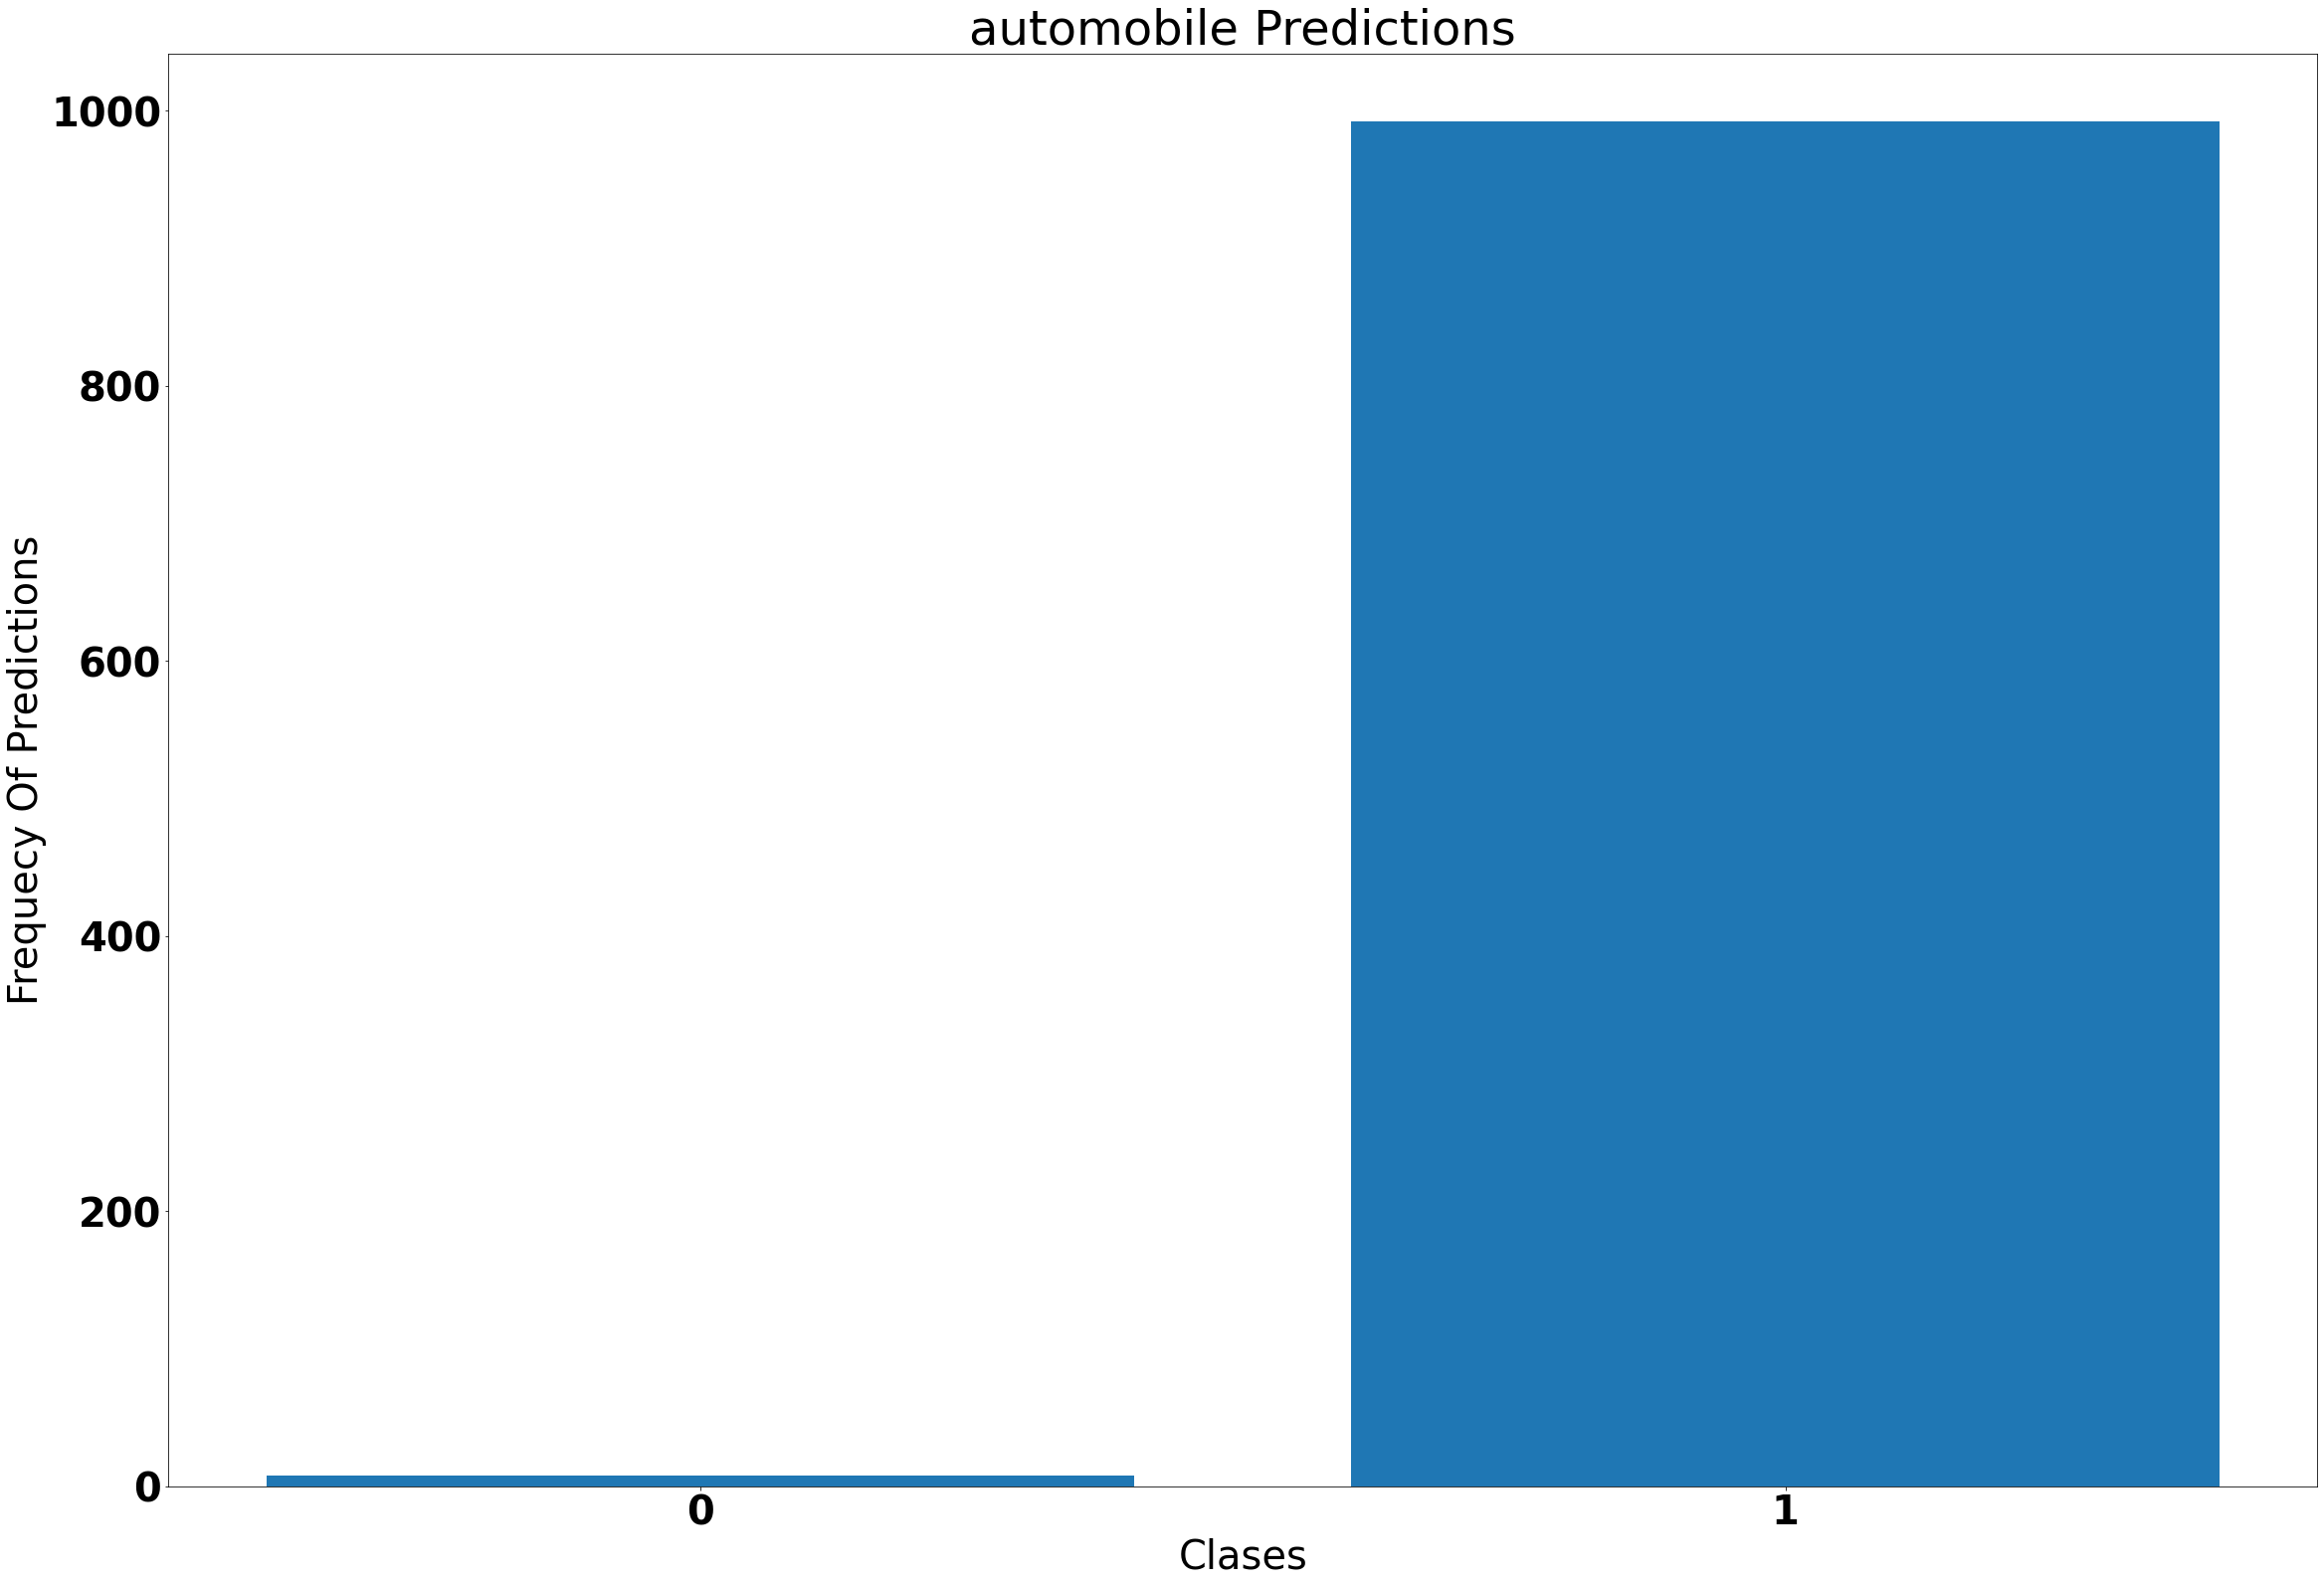

In [18]:
idx = 1
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #2


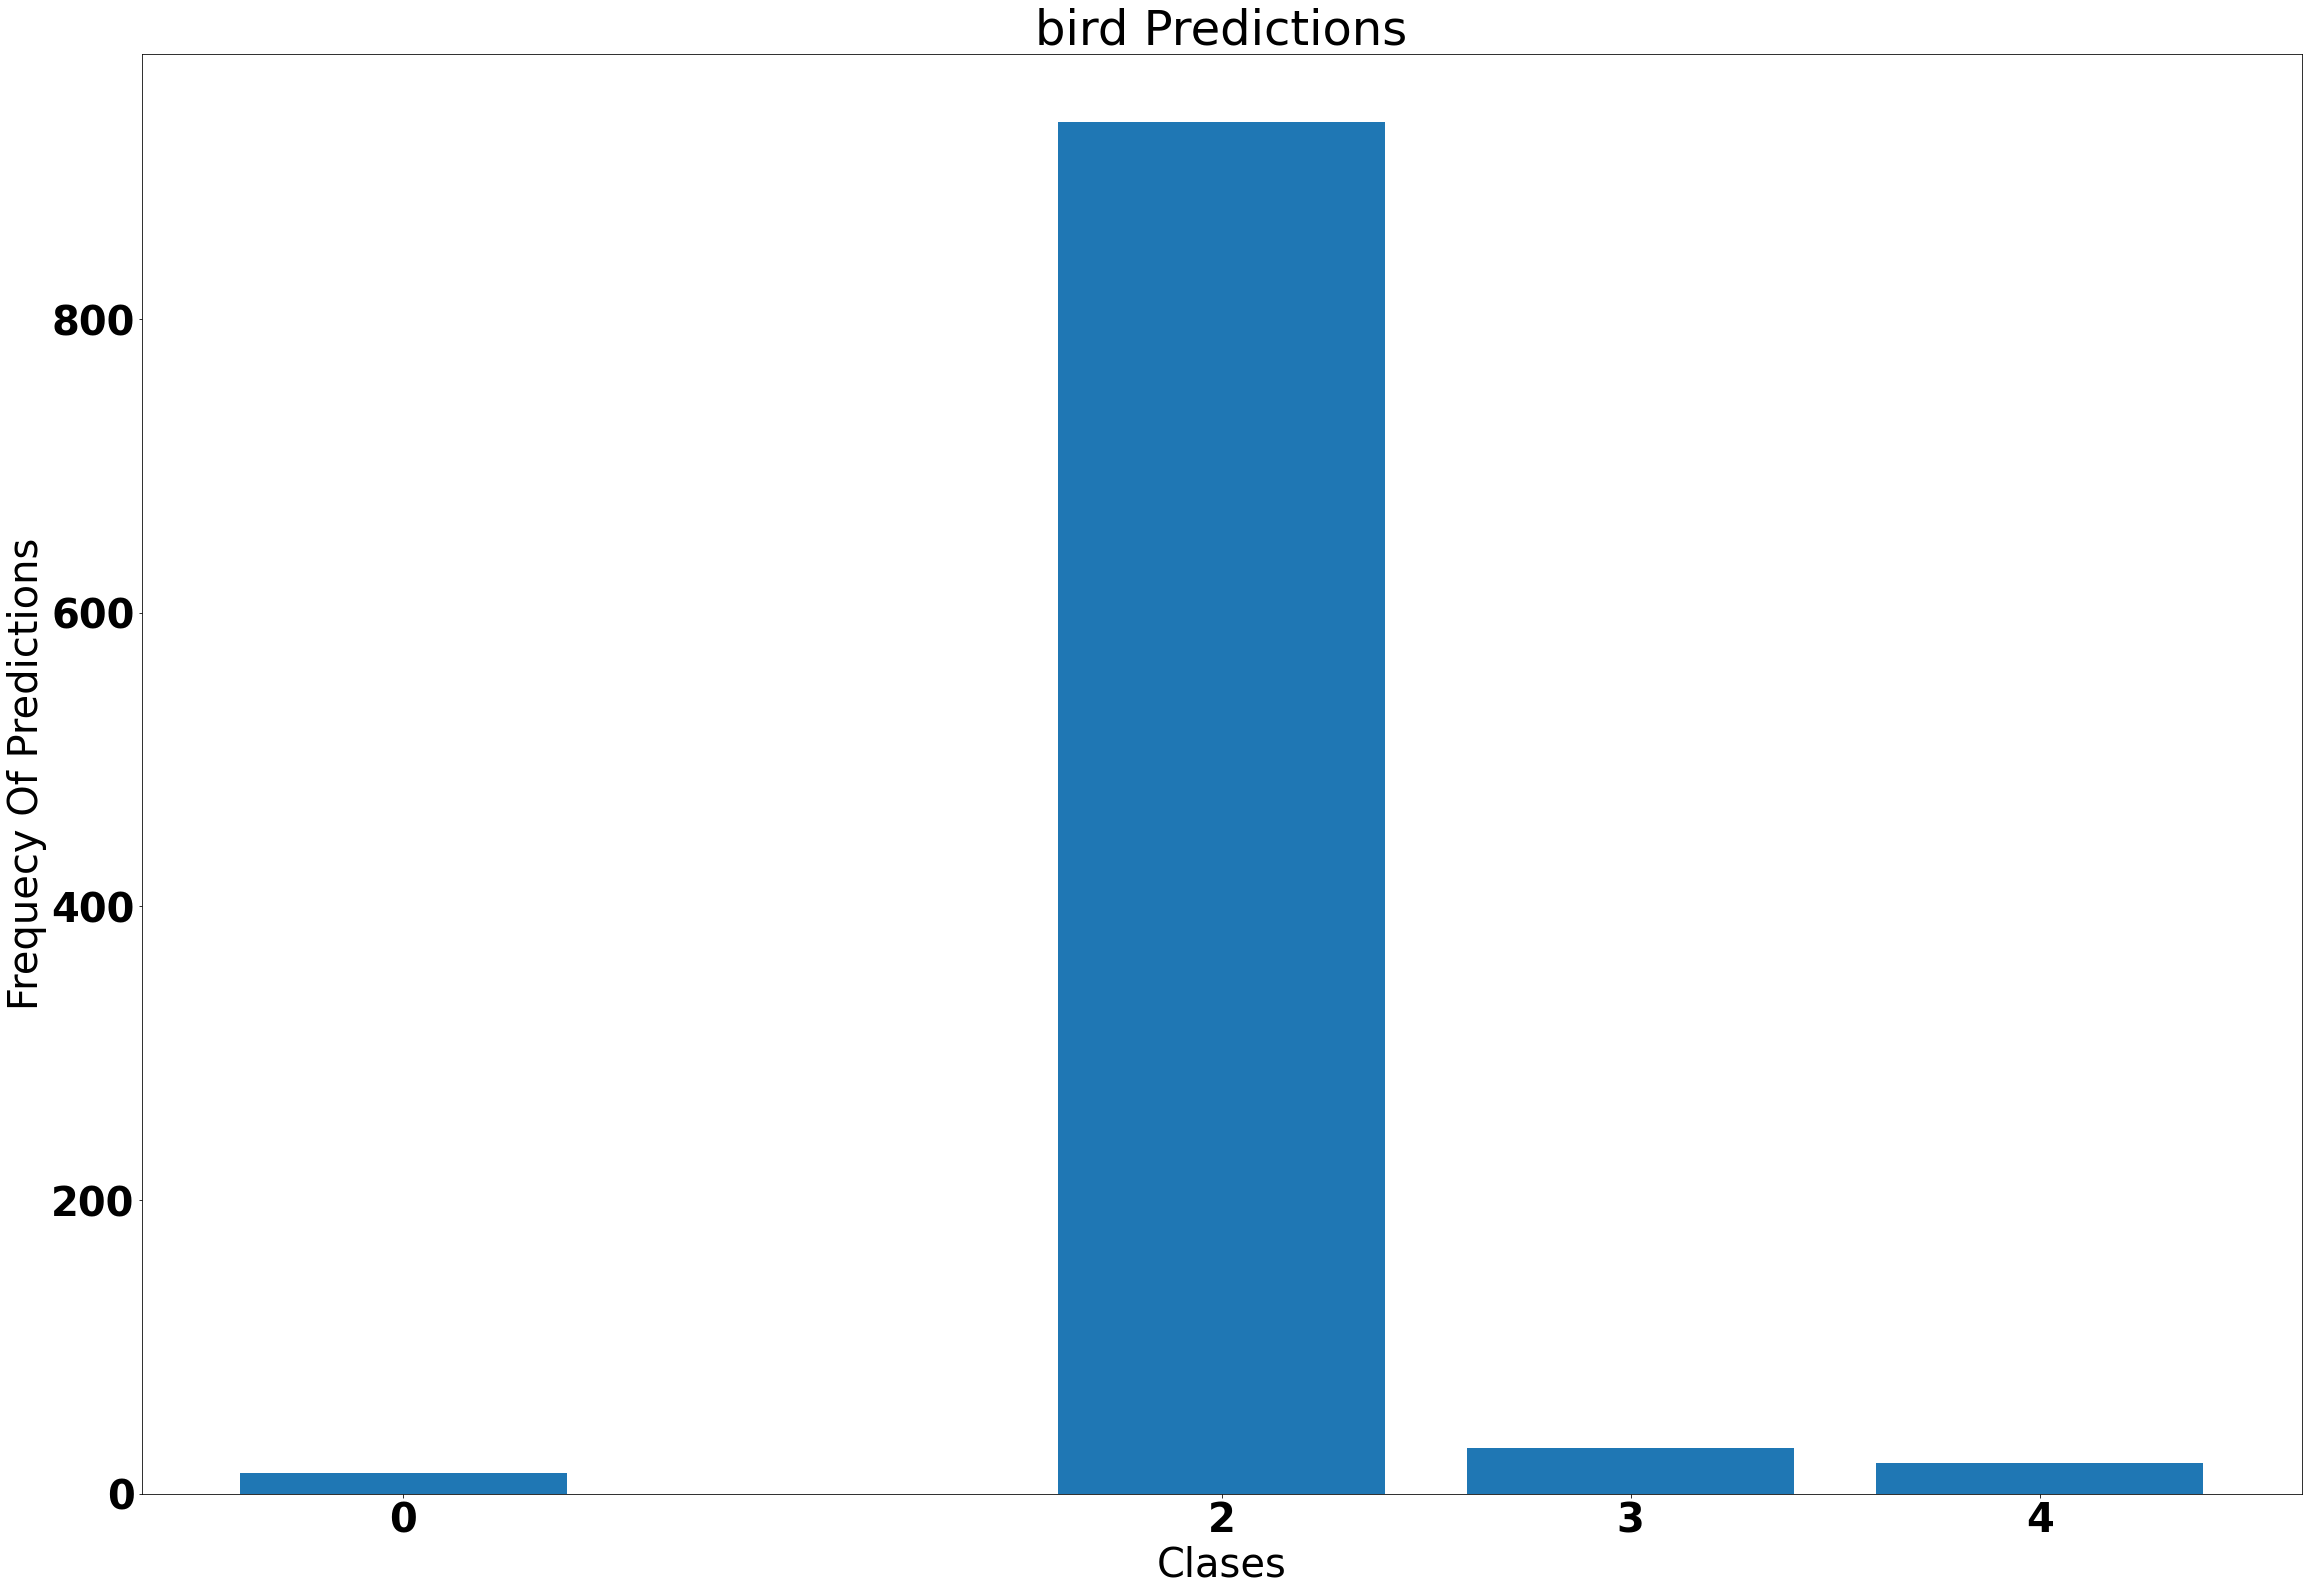

In [19]:
idx = 2
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #3


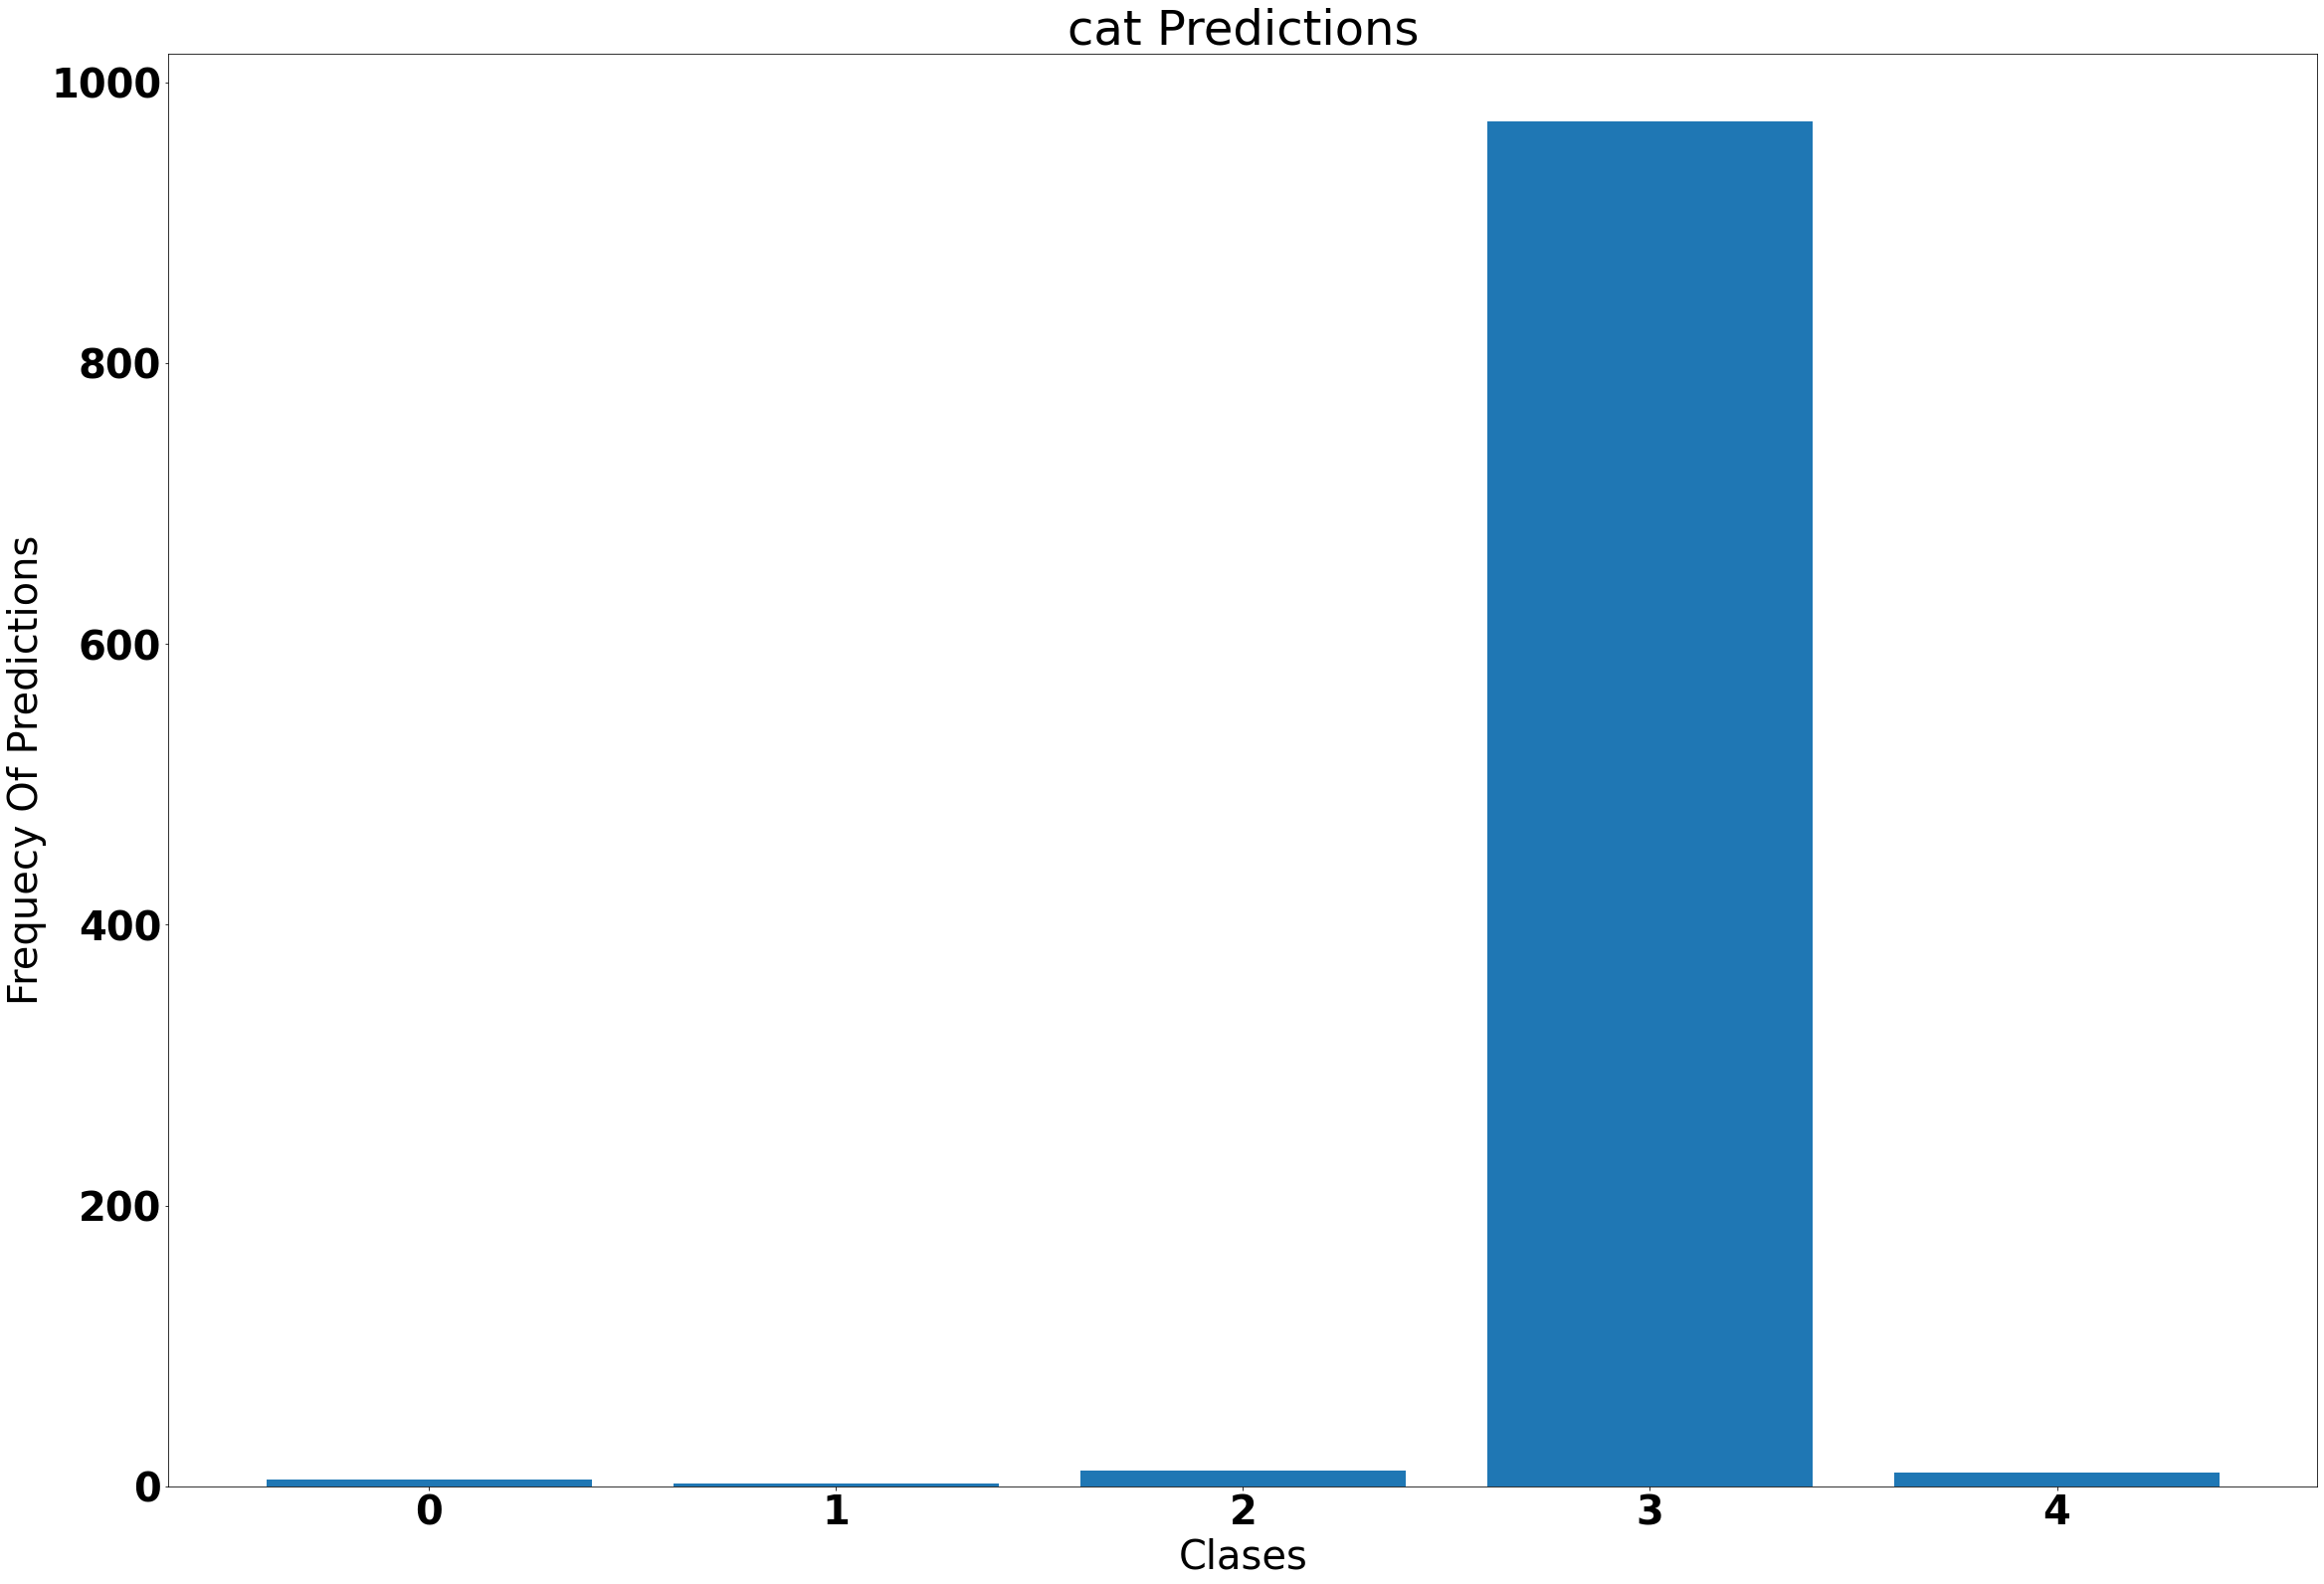

In [20]:
idx = 3
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #4


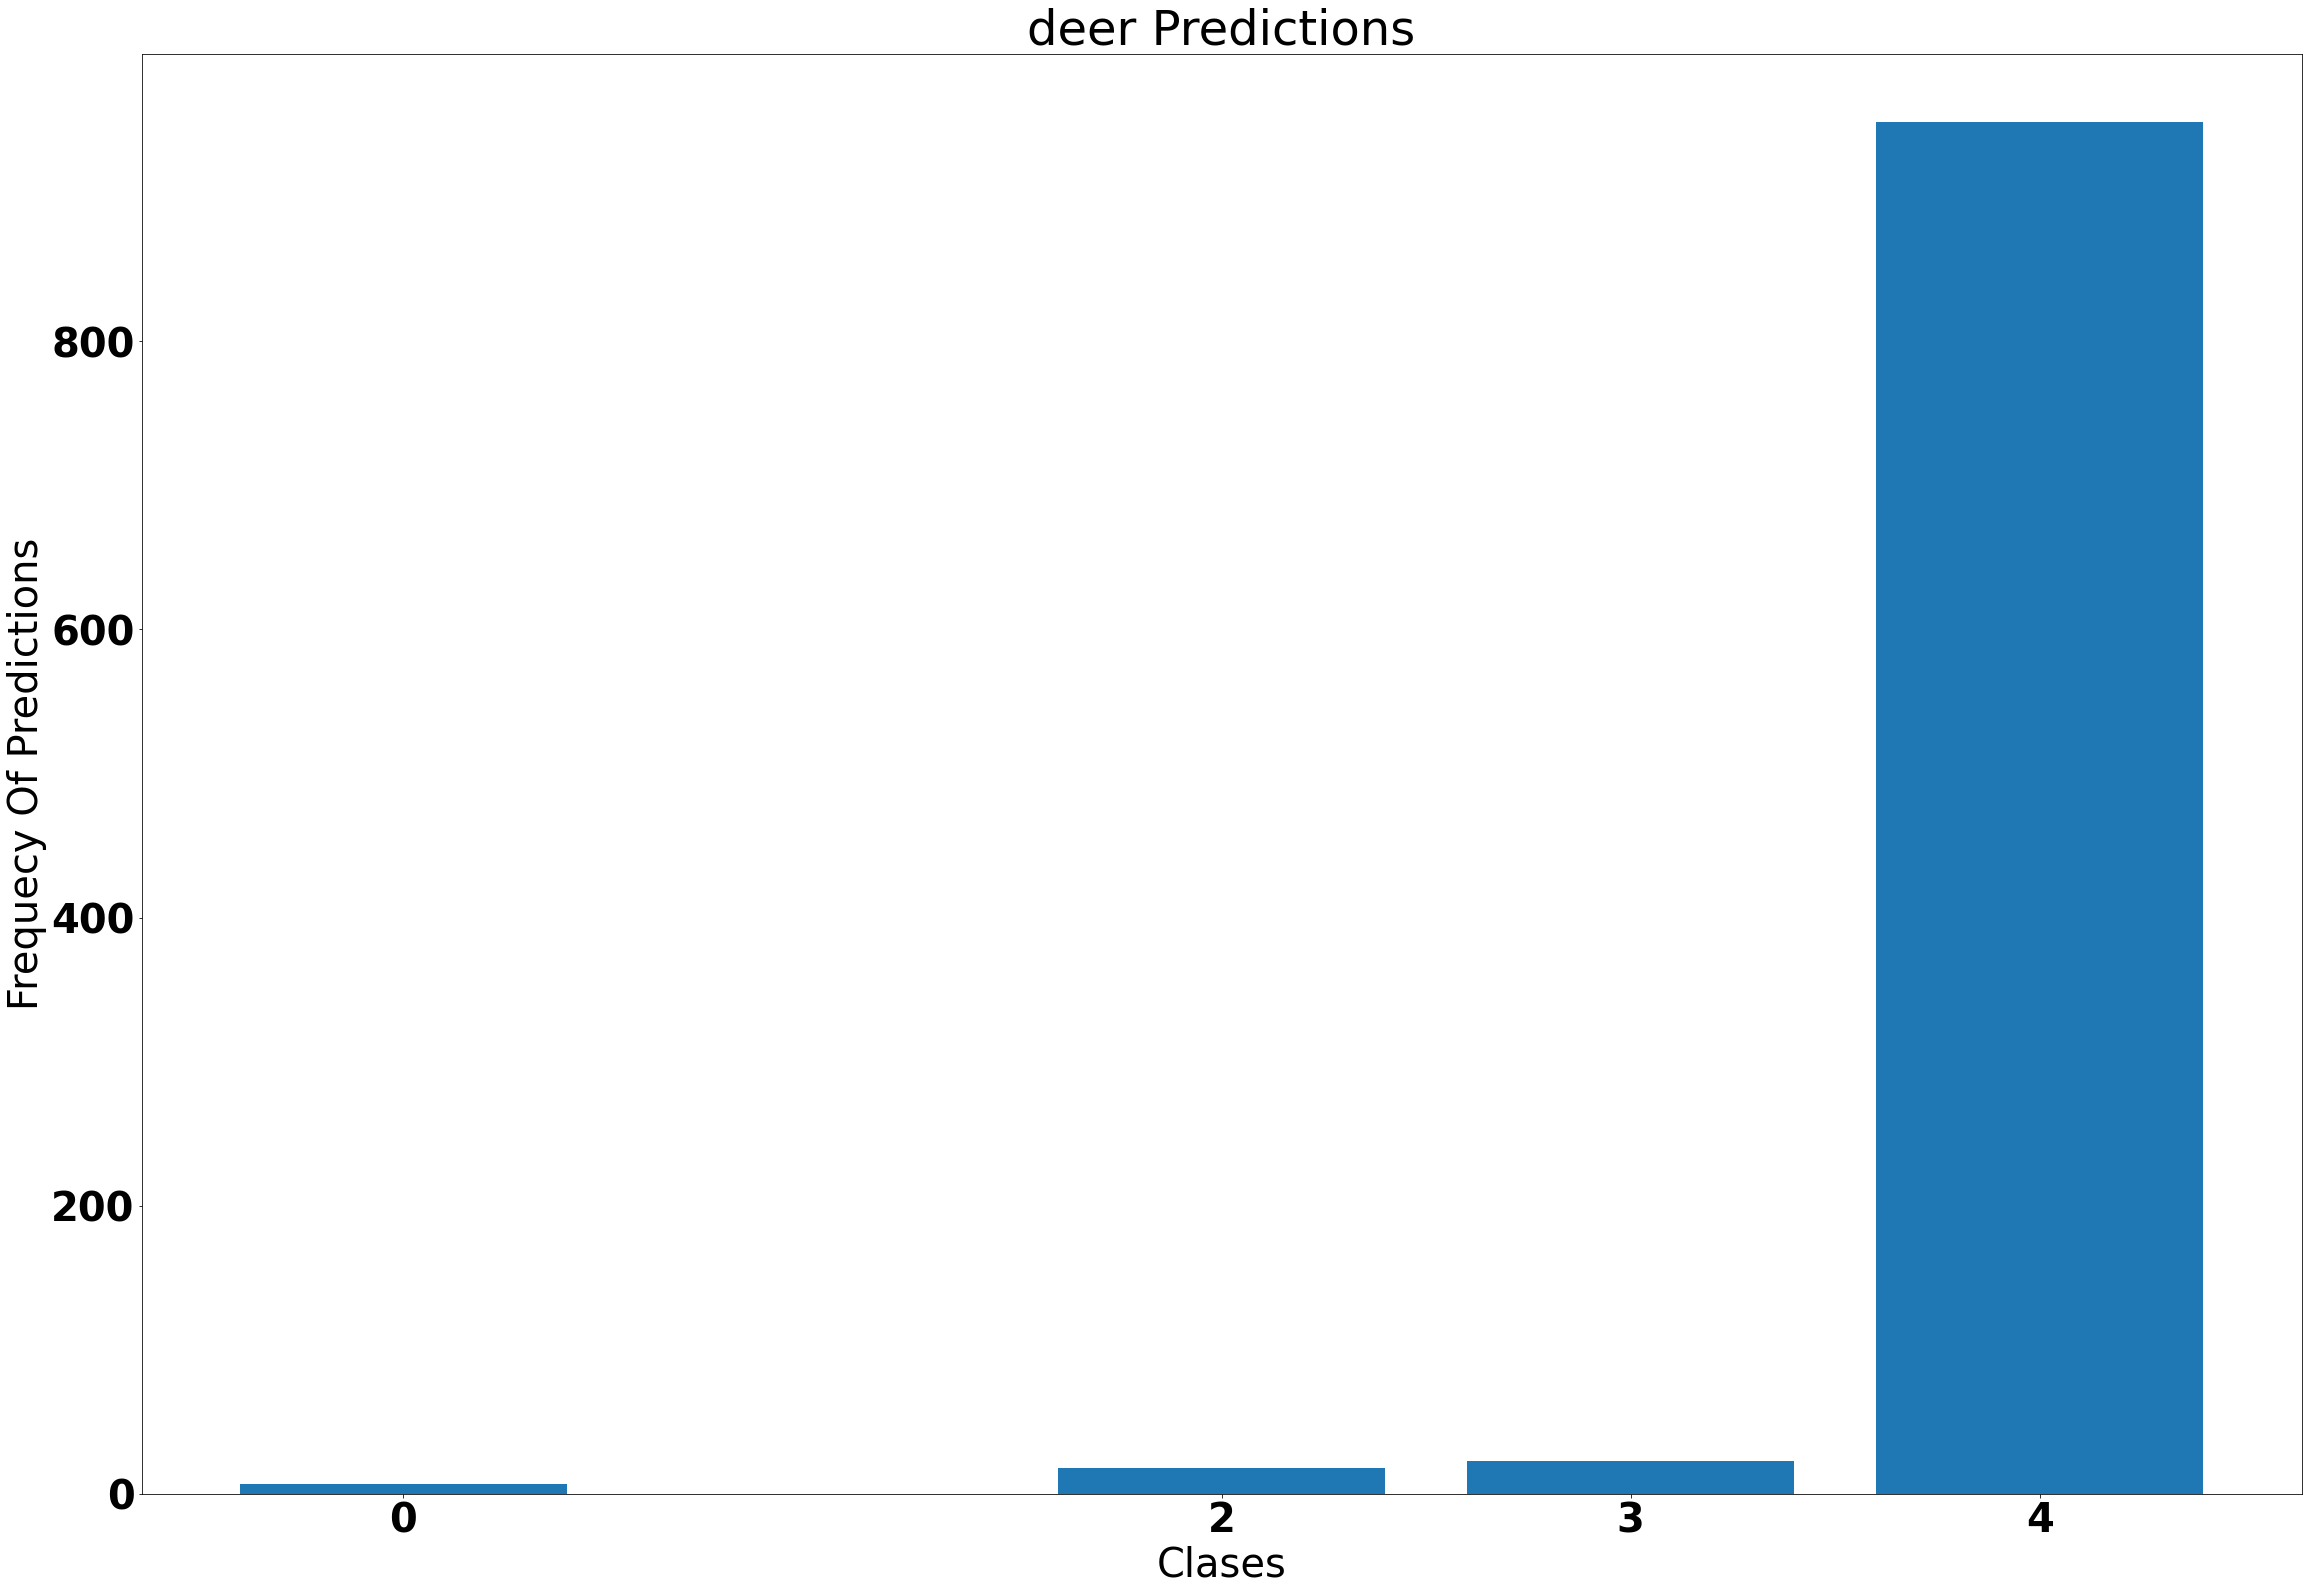

In [21]:
idx = 4
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

## Cifar New Classes 

In [22]:
### Selecting the classes
hold_in_test_classes = [5,6,7,8,9]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(testY,i)

In [23]:
from sklearn.metrics import accuracy_score 
groundTruth =np.argmax(testY[hold_in_test_classes_idx], axis = 1) -5
pred = vote.predict(np.vstack(test_feat1[hold_in_test_classes_idx]))

In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(groundTruth, pred, average = "macro")
acc = accuracy_score(groundTruth, pred)
recall = recall_score(groundTruth, pred,   average = "macro")

precision =precision_score(groundTruth, pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth), 
                tf.keras.utils.to_categorical(pred))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 32.04507674179077
Accuracy: 0.0722
F1 Score: 0.06422228974395175
recall Score: 0.0722
Precision Score: 0.05784784042456825


In [37]:
df_cm

,dog,frog,horse,ship,truck
dog,4,2,39,925,30
frog,37,1,837,81,44
horse,103,2,344,124,427
ship,883,73,31,12,1
truck,154,835,3,8,0


['dog', 'frog', 'horse', 'ship', 'truck']

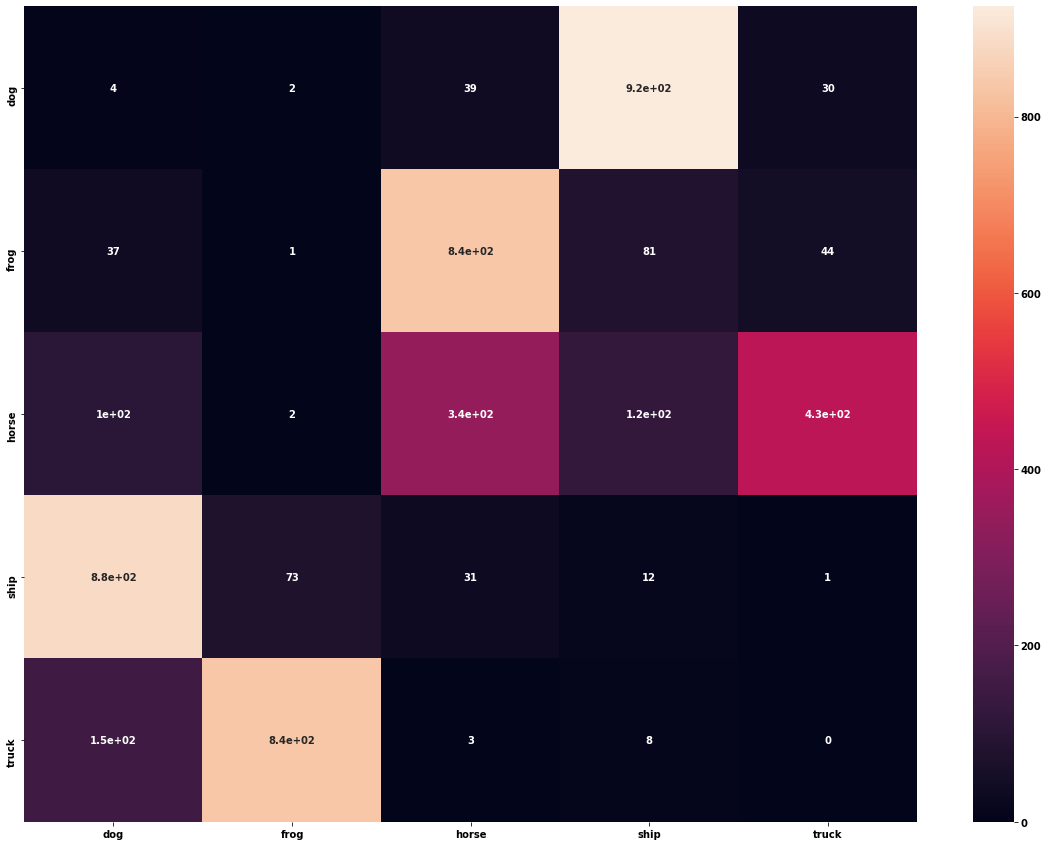

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
                'truck']
df_cm = pd.DataFrame(np.array(conf), index = labels_names[5:],
                  columns =  labels_names[5:])
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_svm/conf_Cifar New Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/conf_Cifar New Classes.pdf", dpi = 200)

<ipython-input-26-dca95727d7cf>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


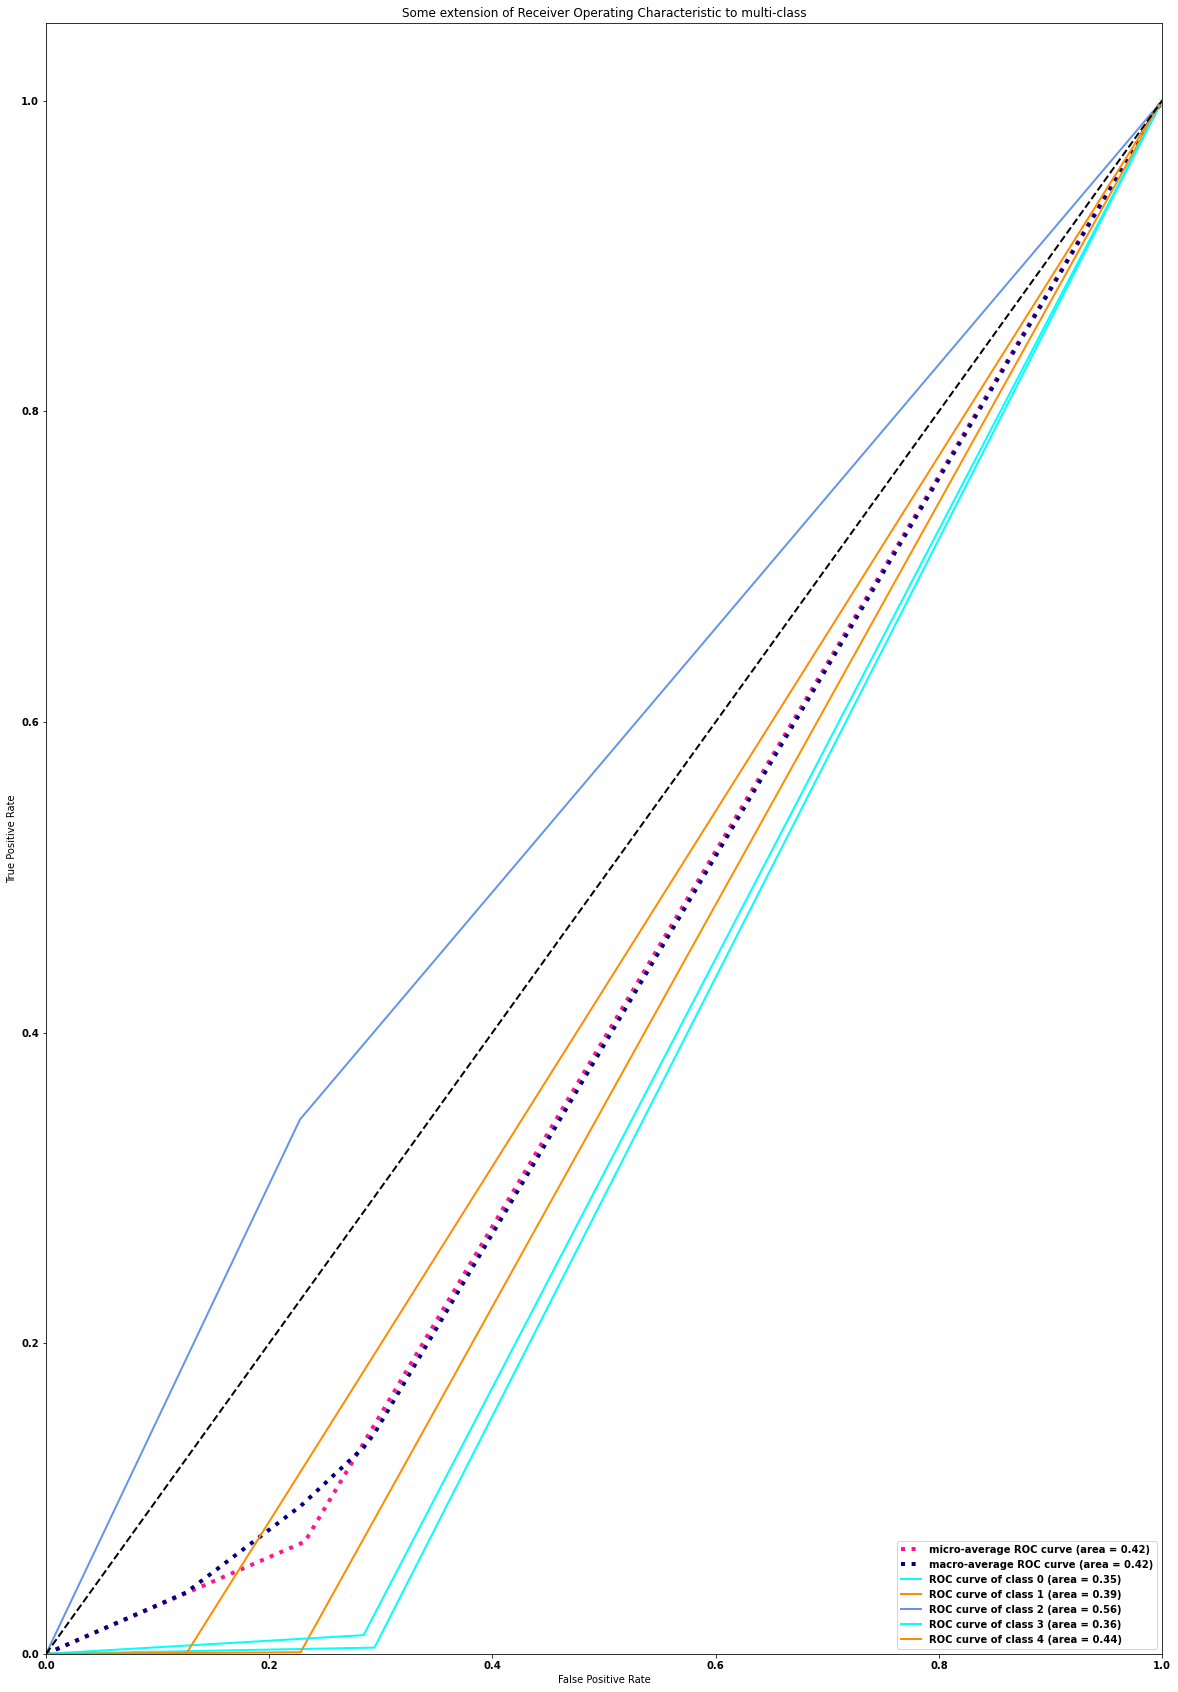

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(tf.keras.utils.to_categorical(pred))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_svm/roc_Cifar New Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/roc_Cifar New Classes.pdf", dpi = 200)
plt.show()

In [27]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)


In [28]:
cclasses = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck']

Class #0


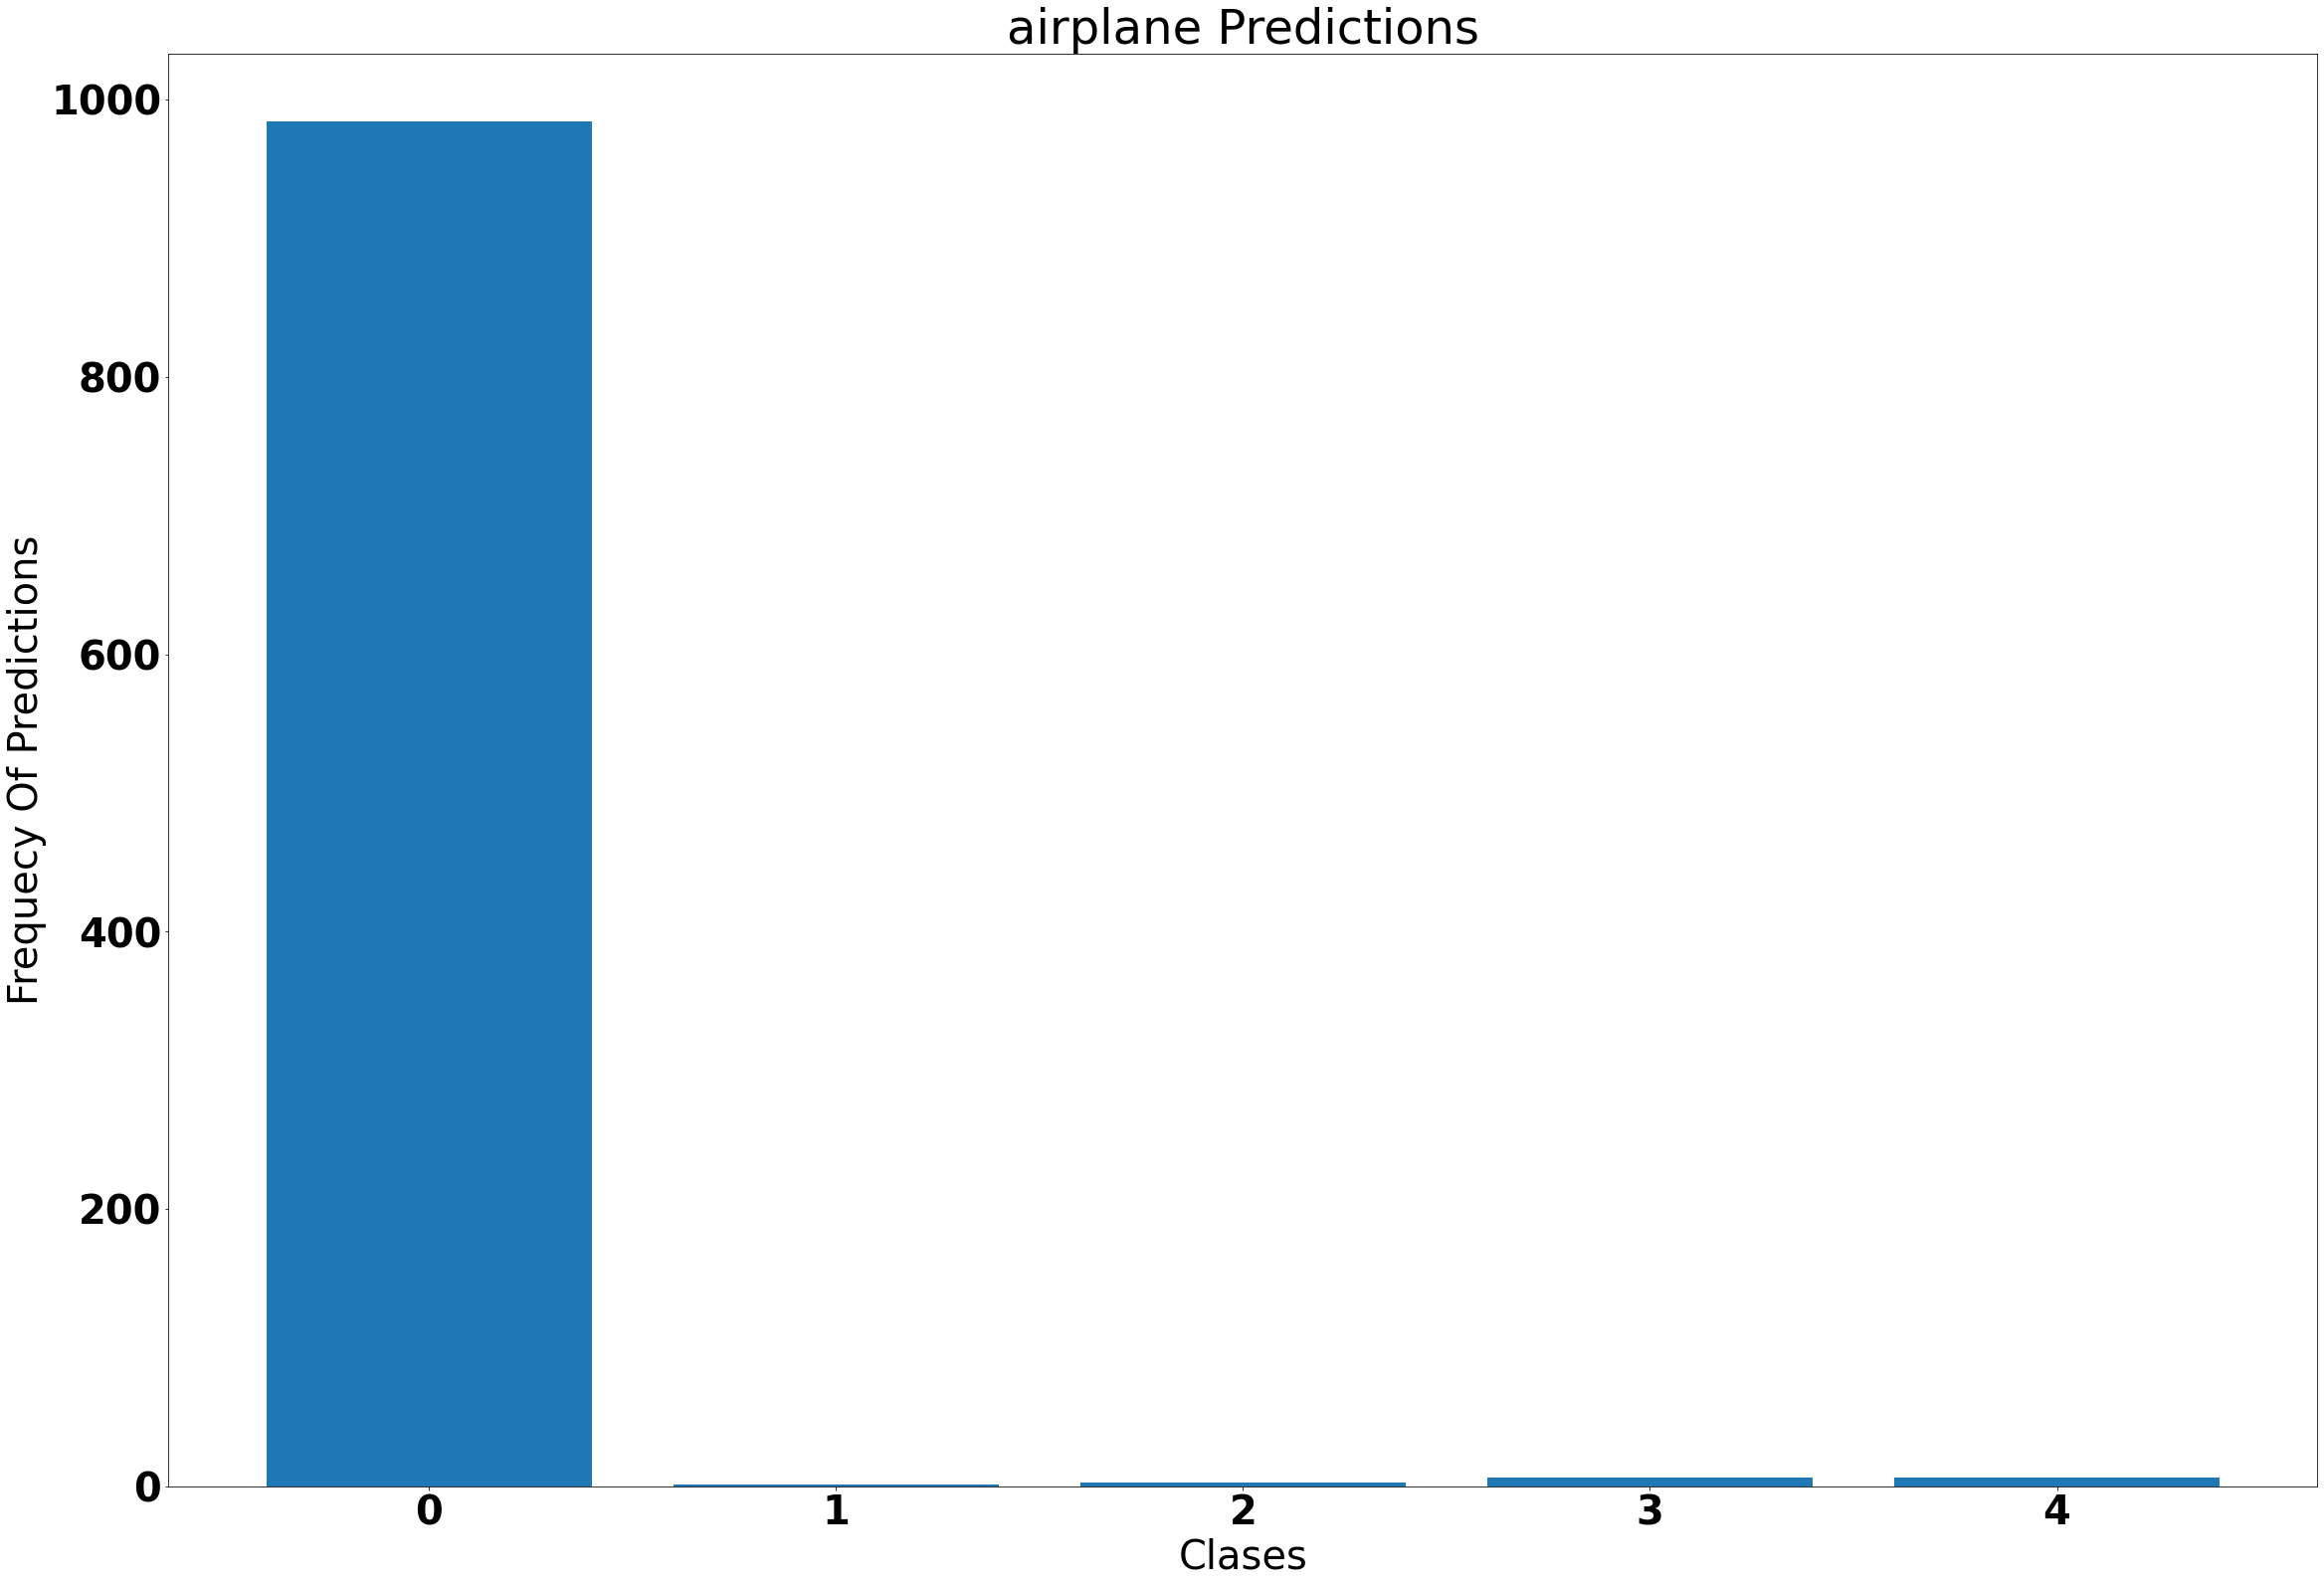

In [29]:
idx = 0
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #1


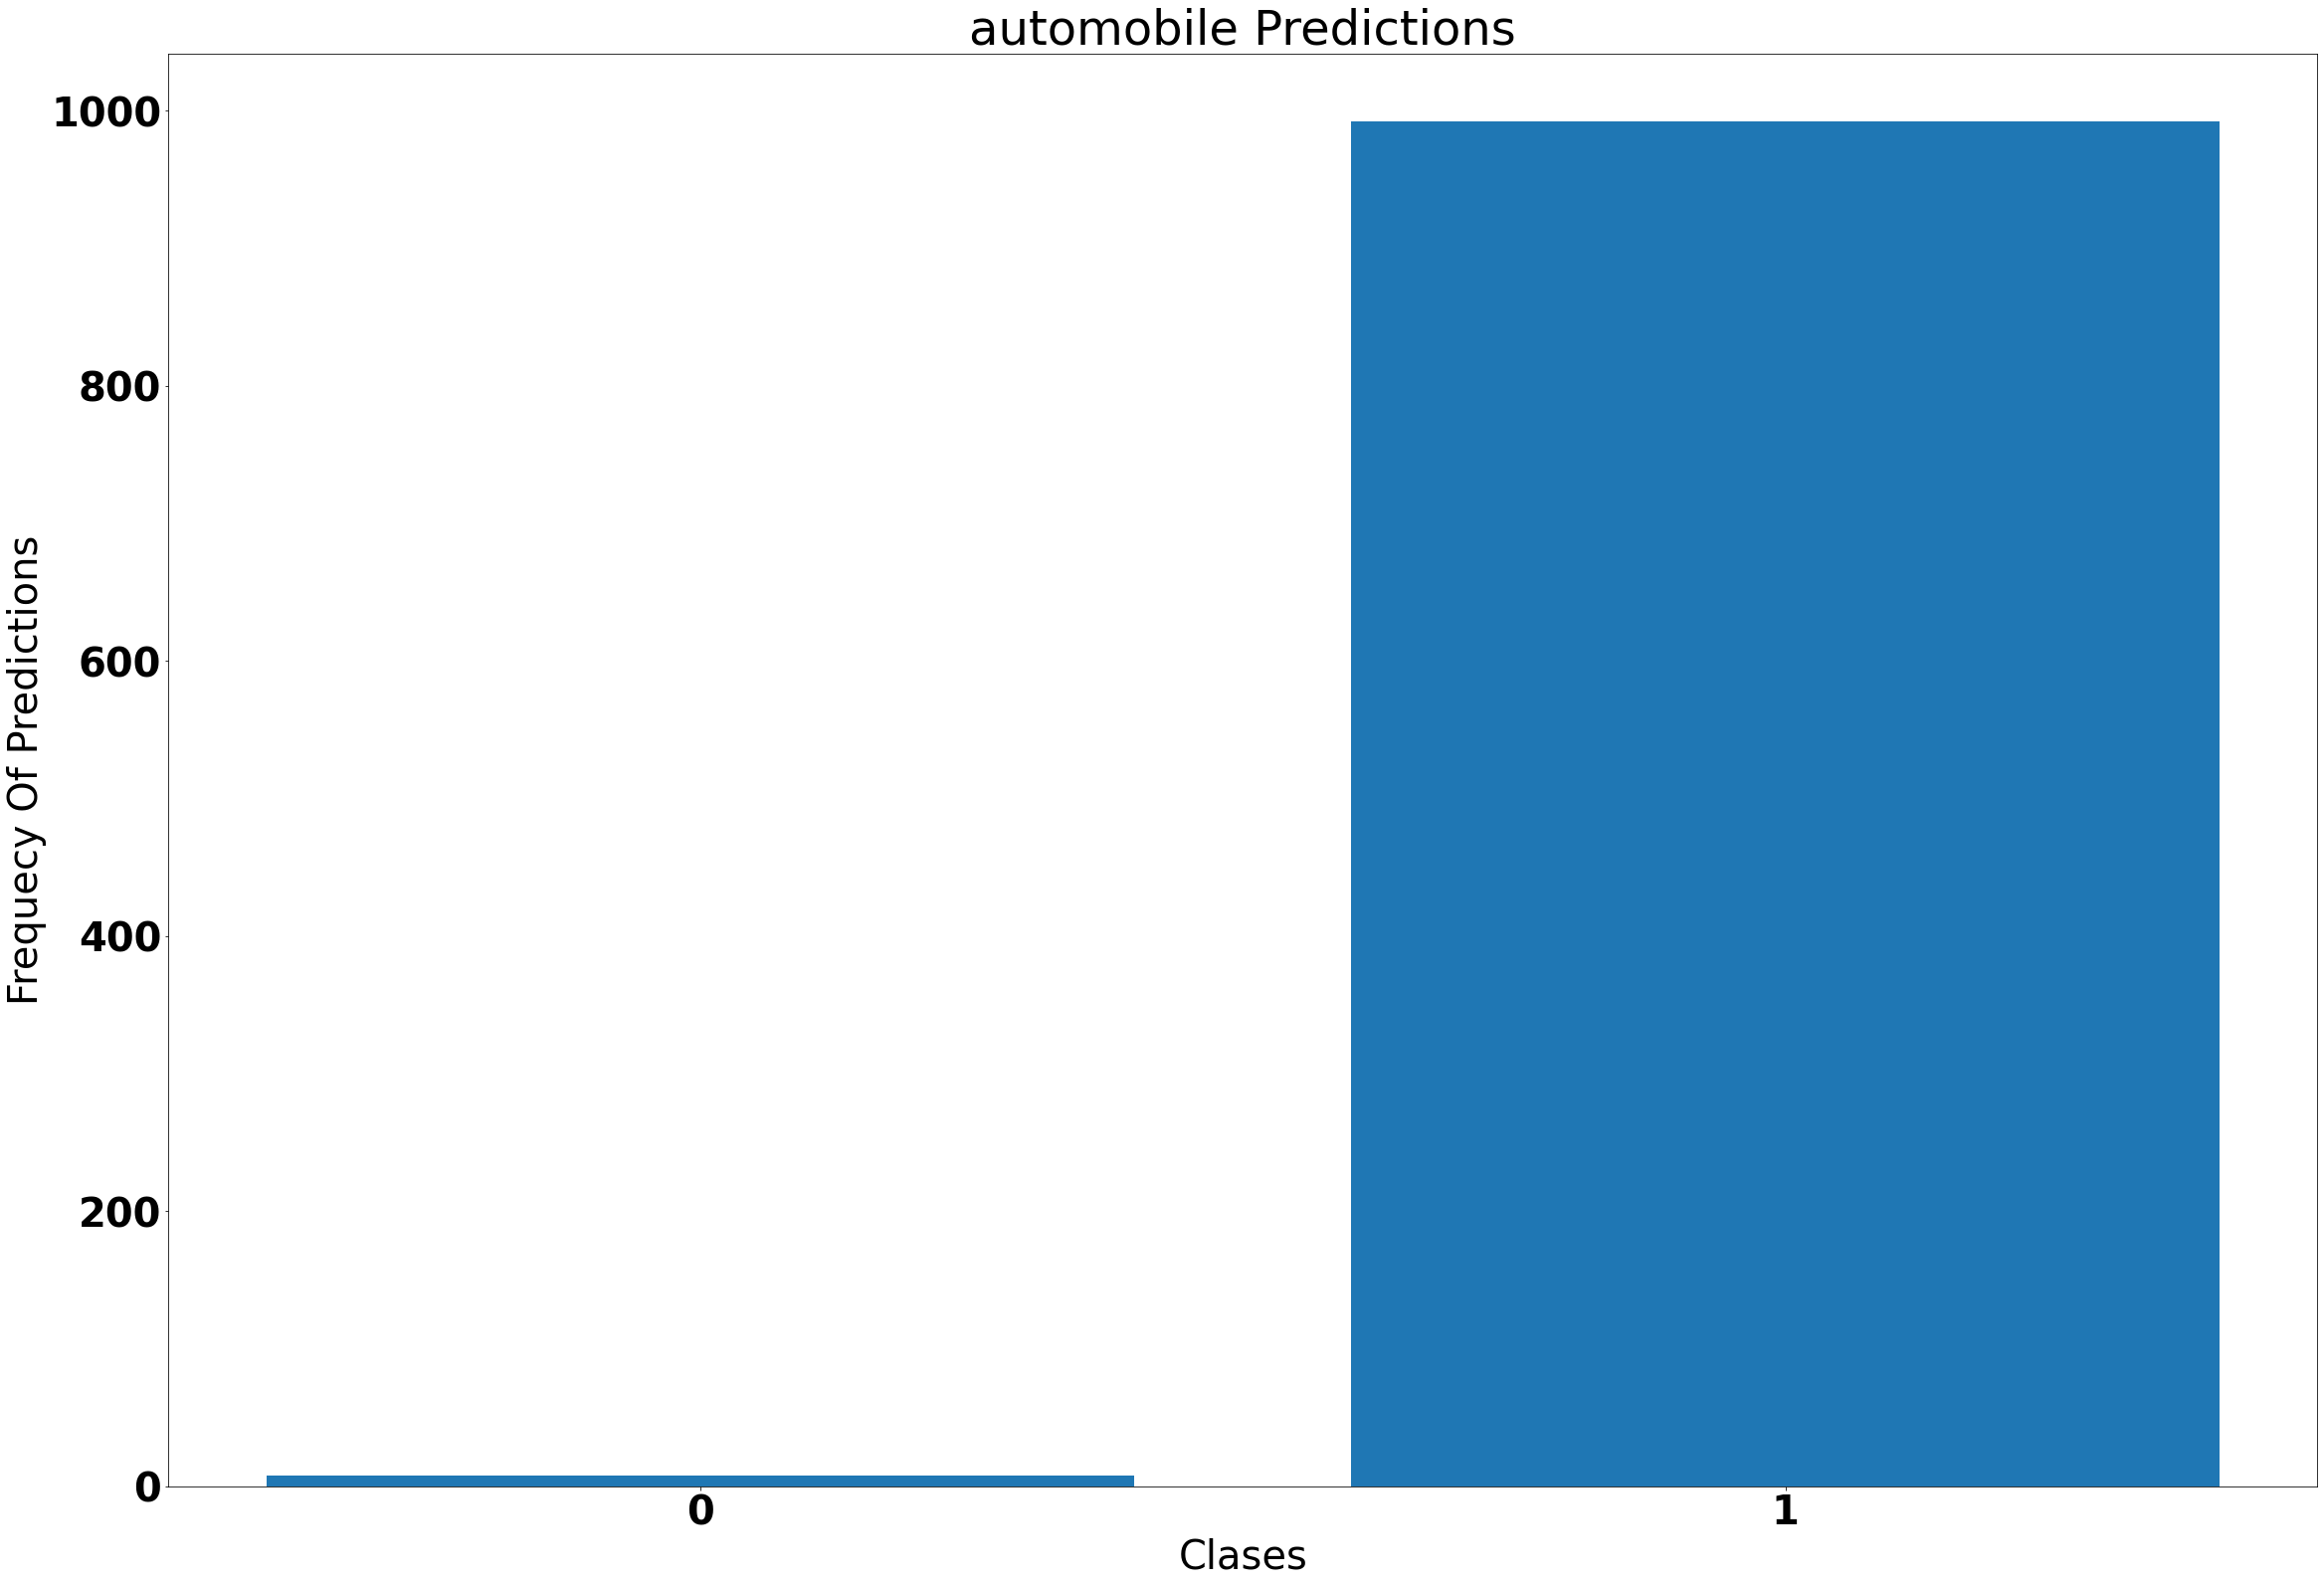

In [30]:
idx = 1
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #2


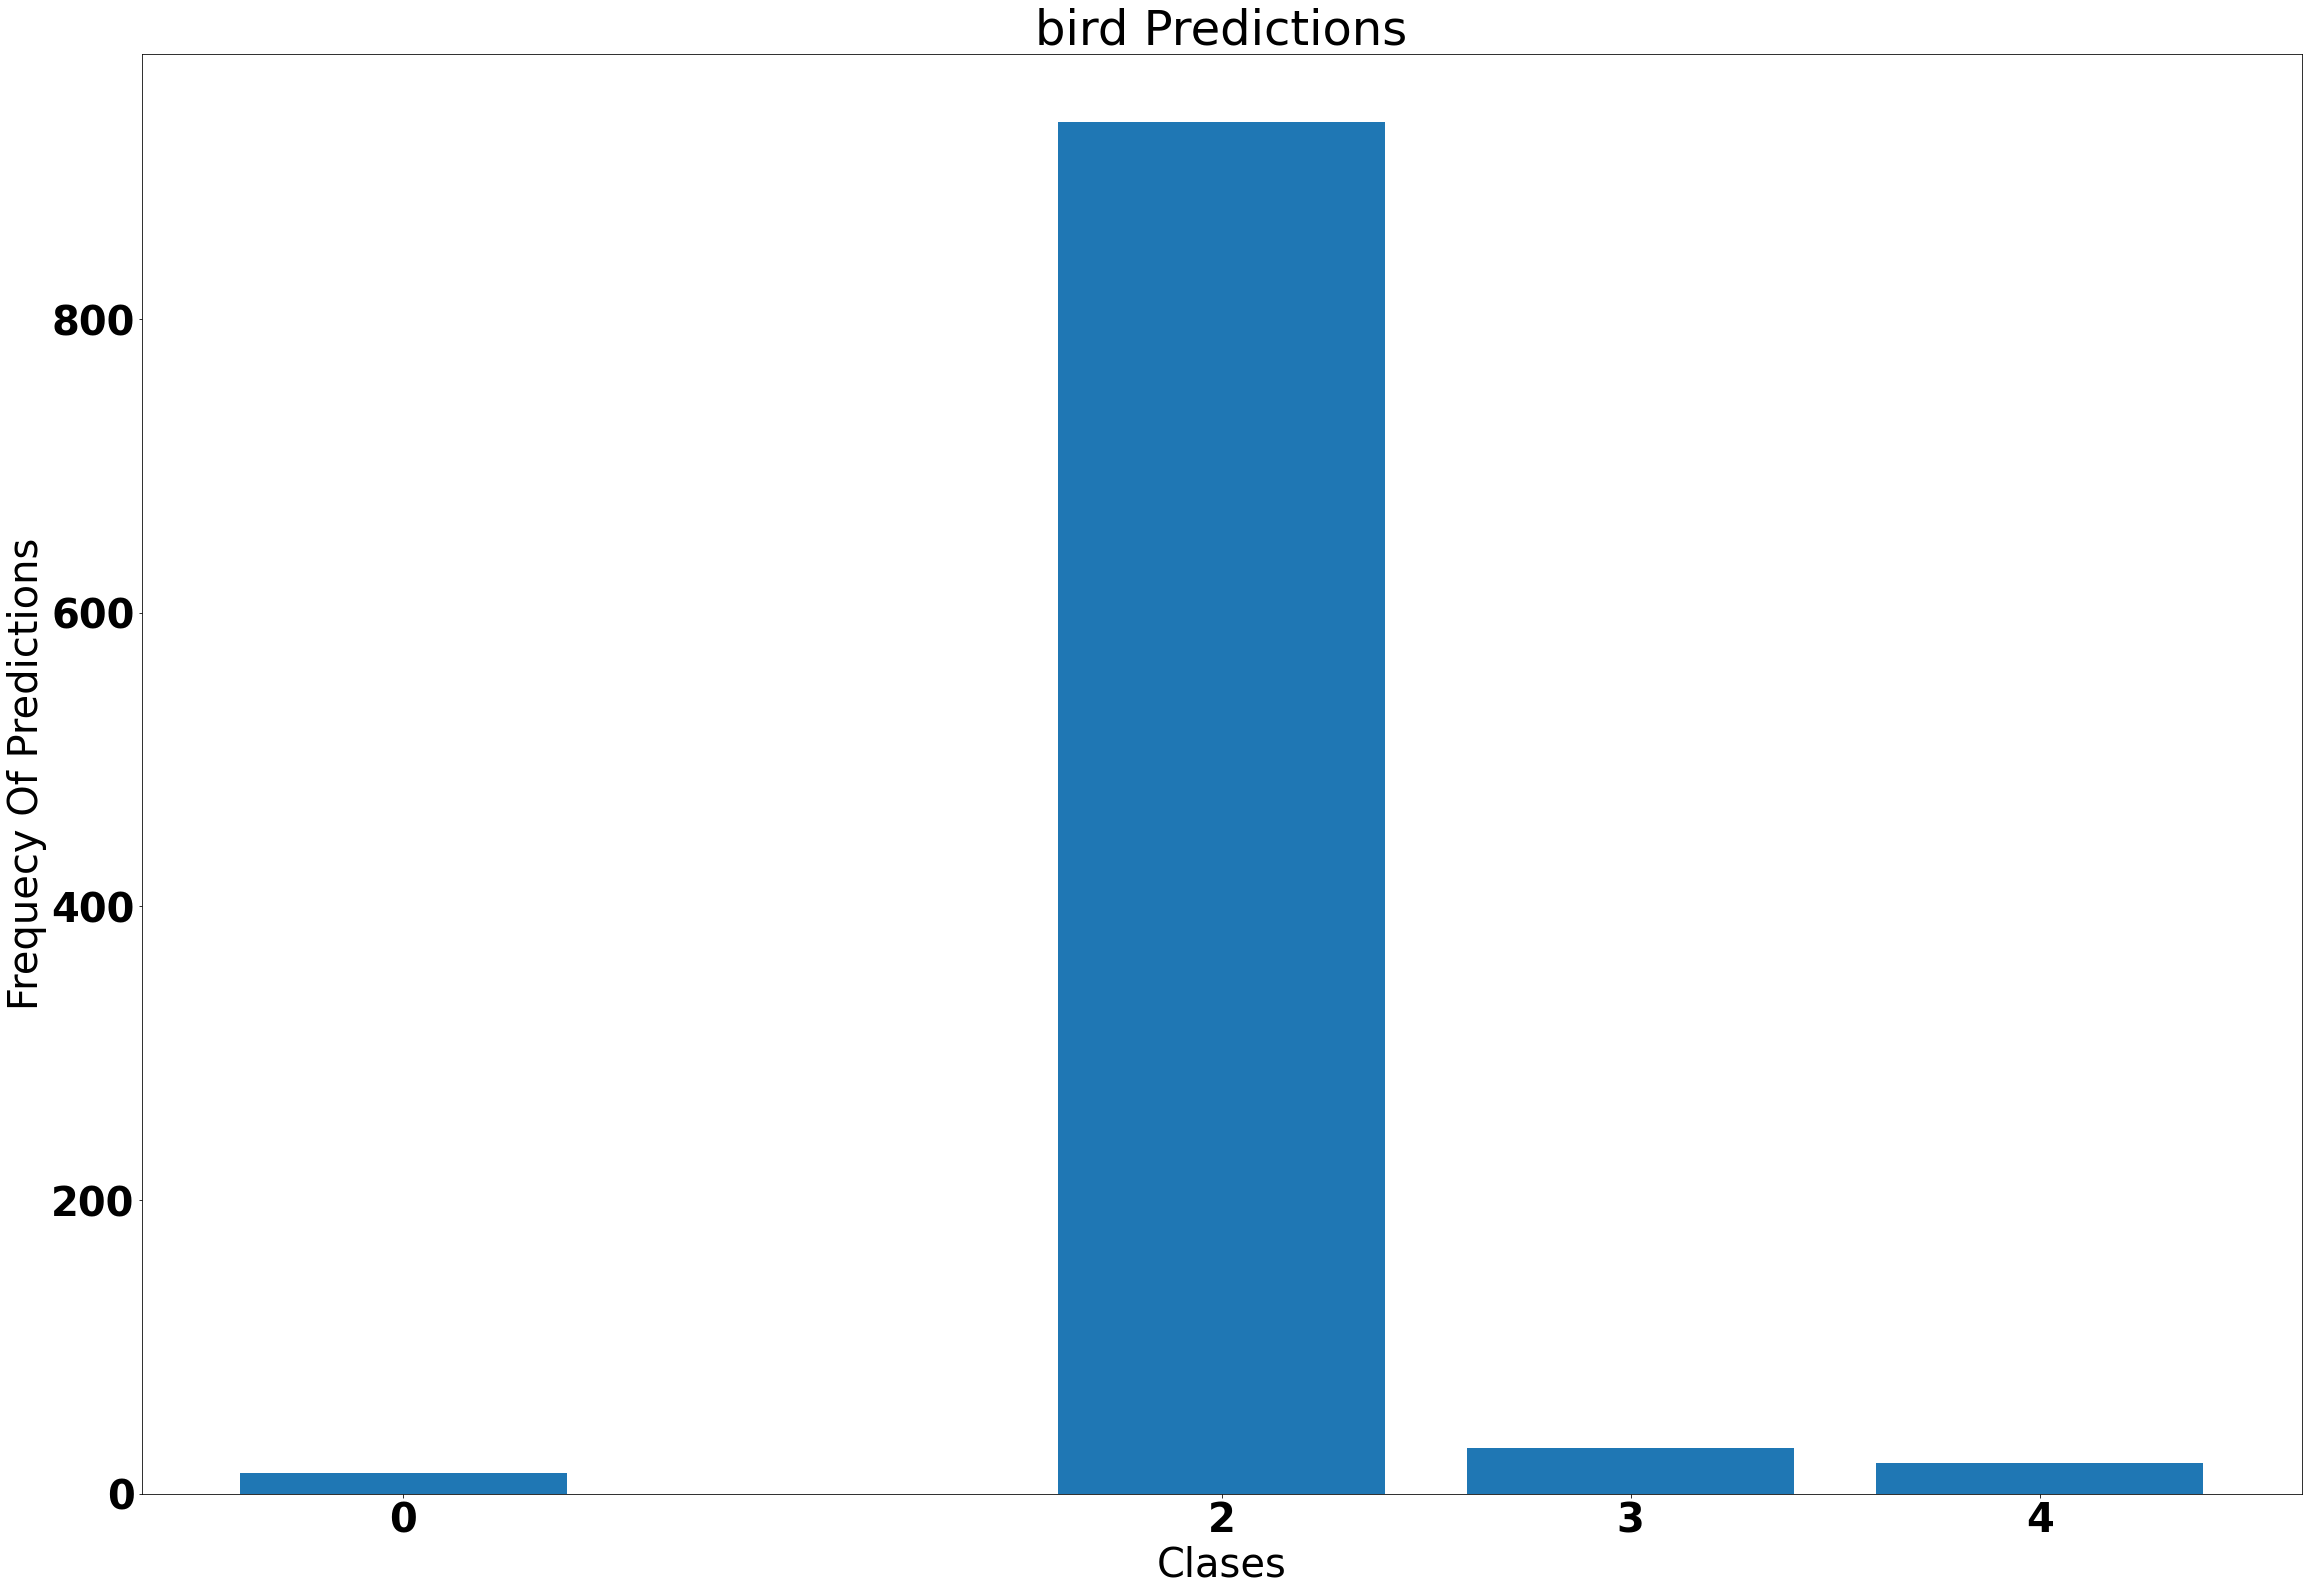

In [31]:
idx = 2
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #3


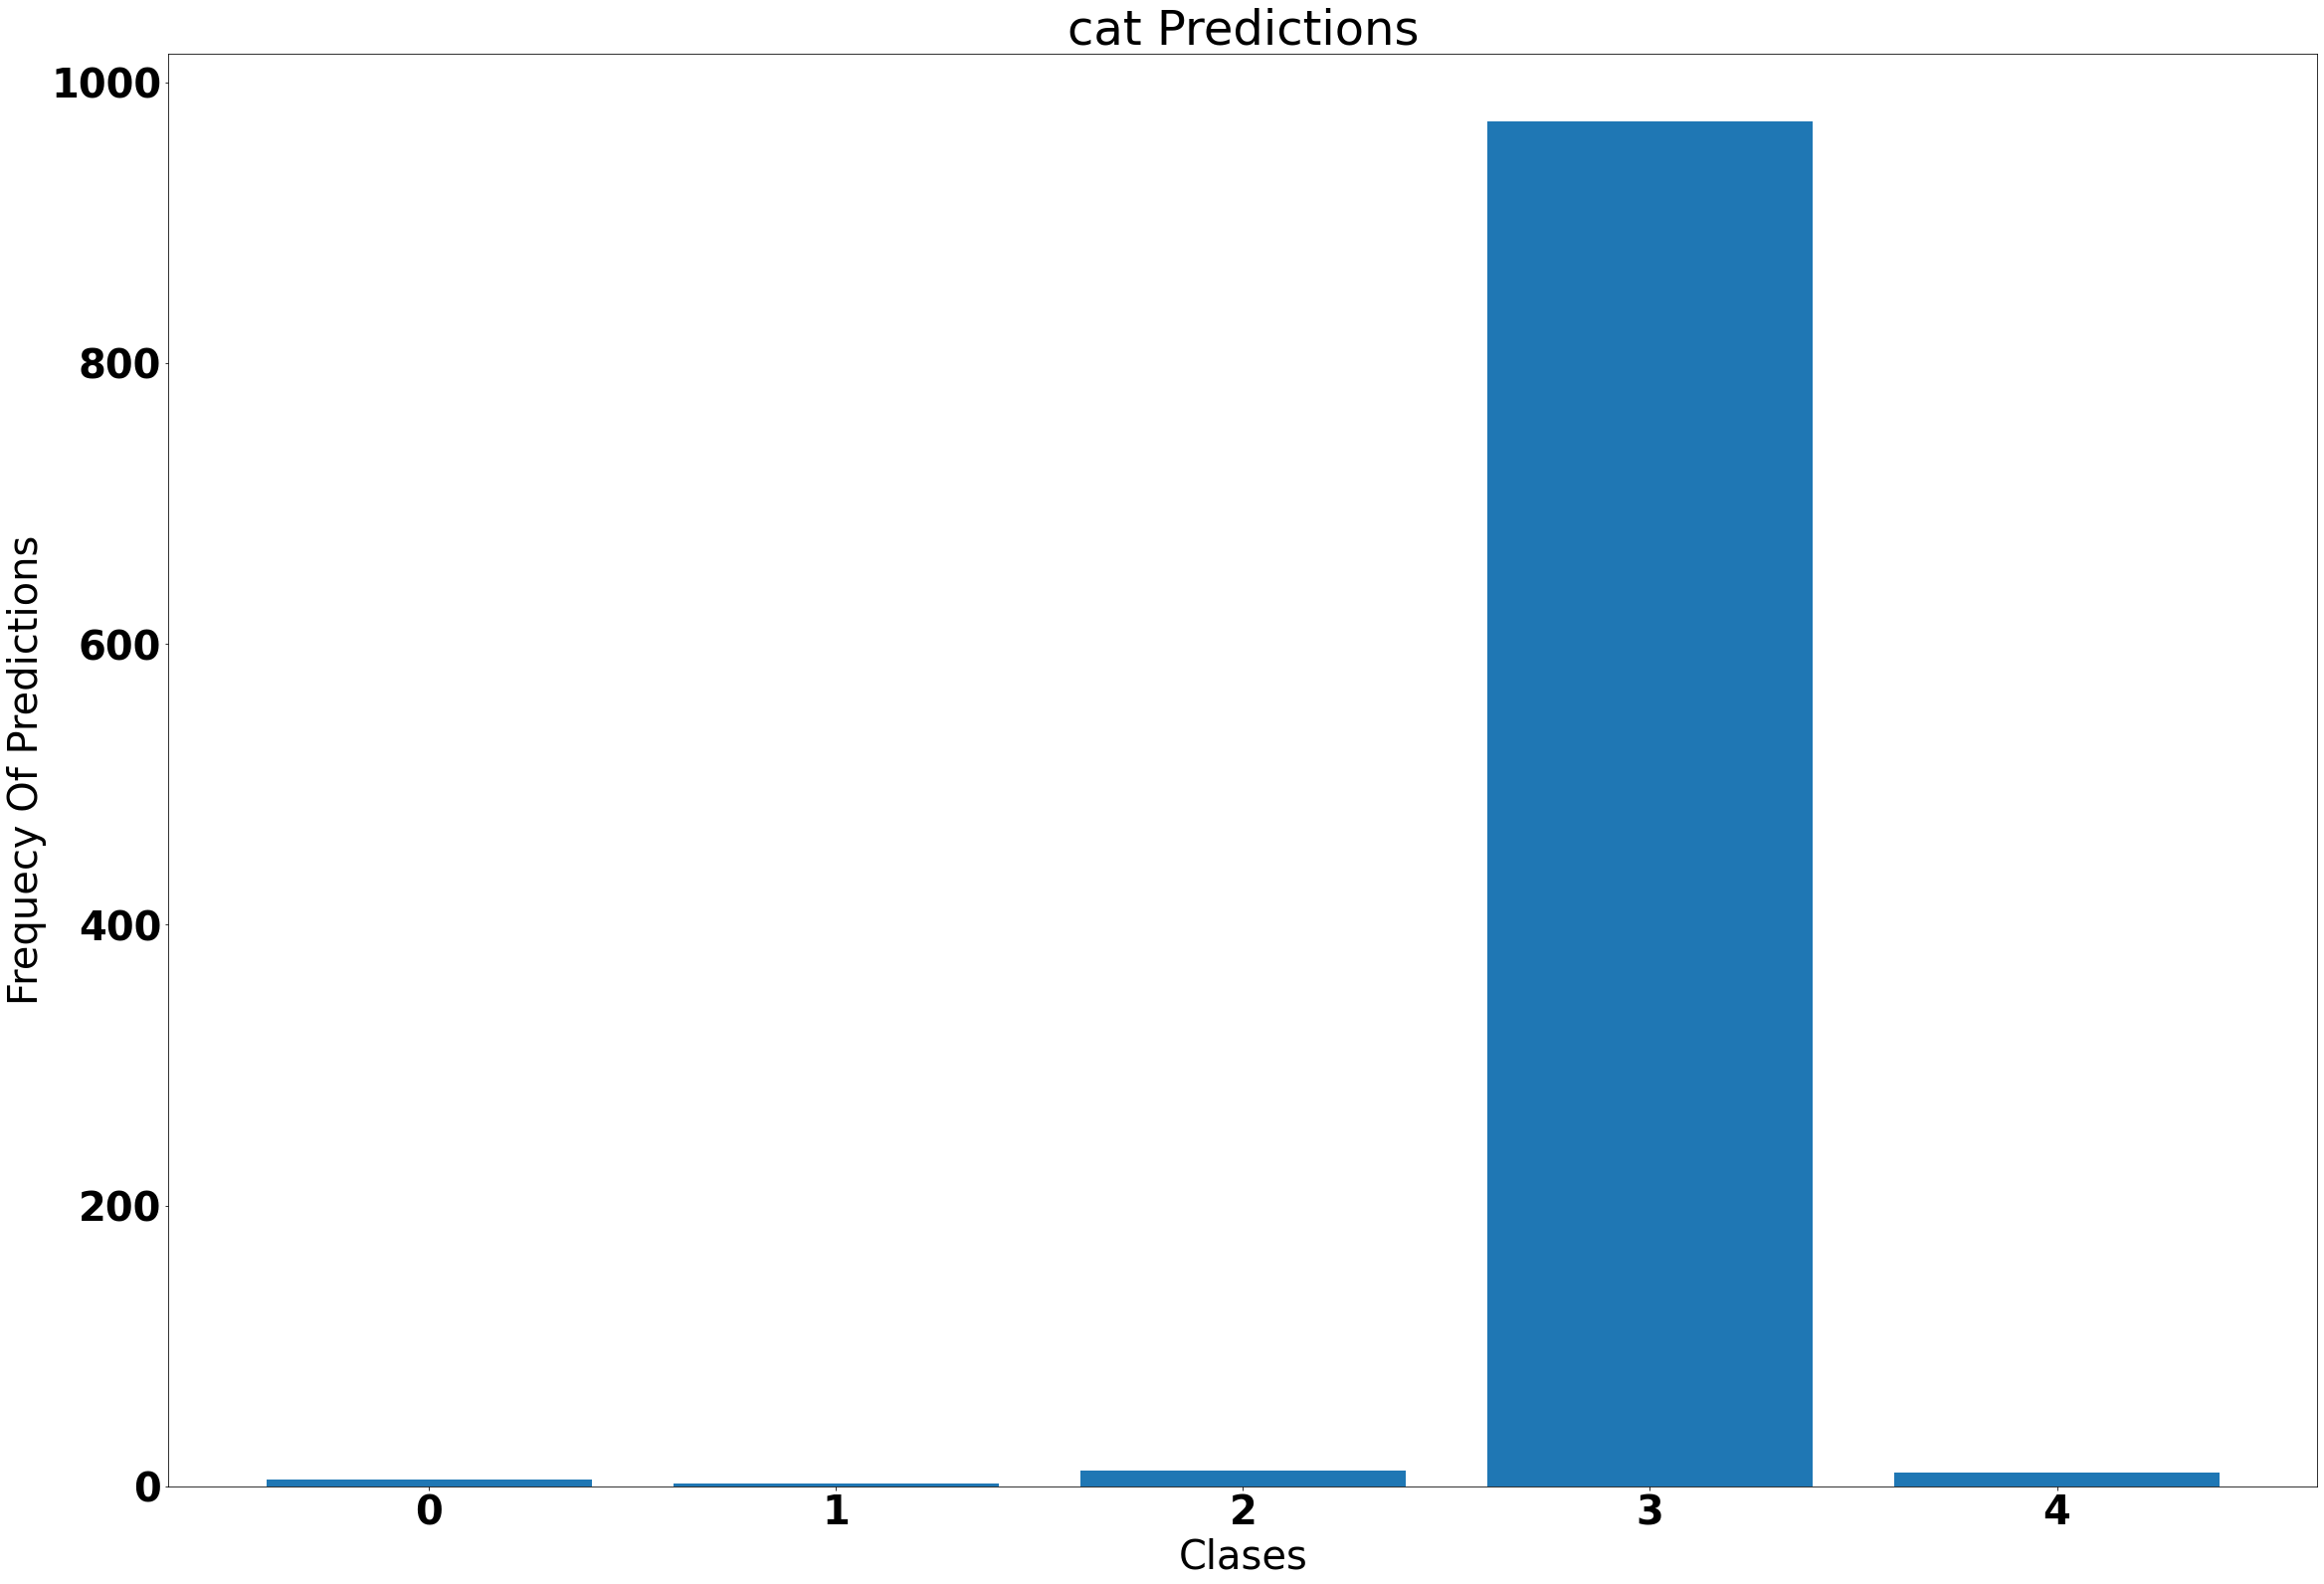

In [32]:
idx = 3
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

Class #4


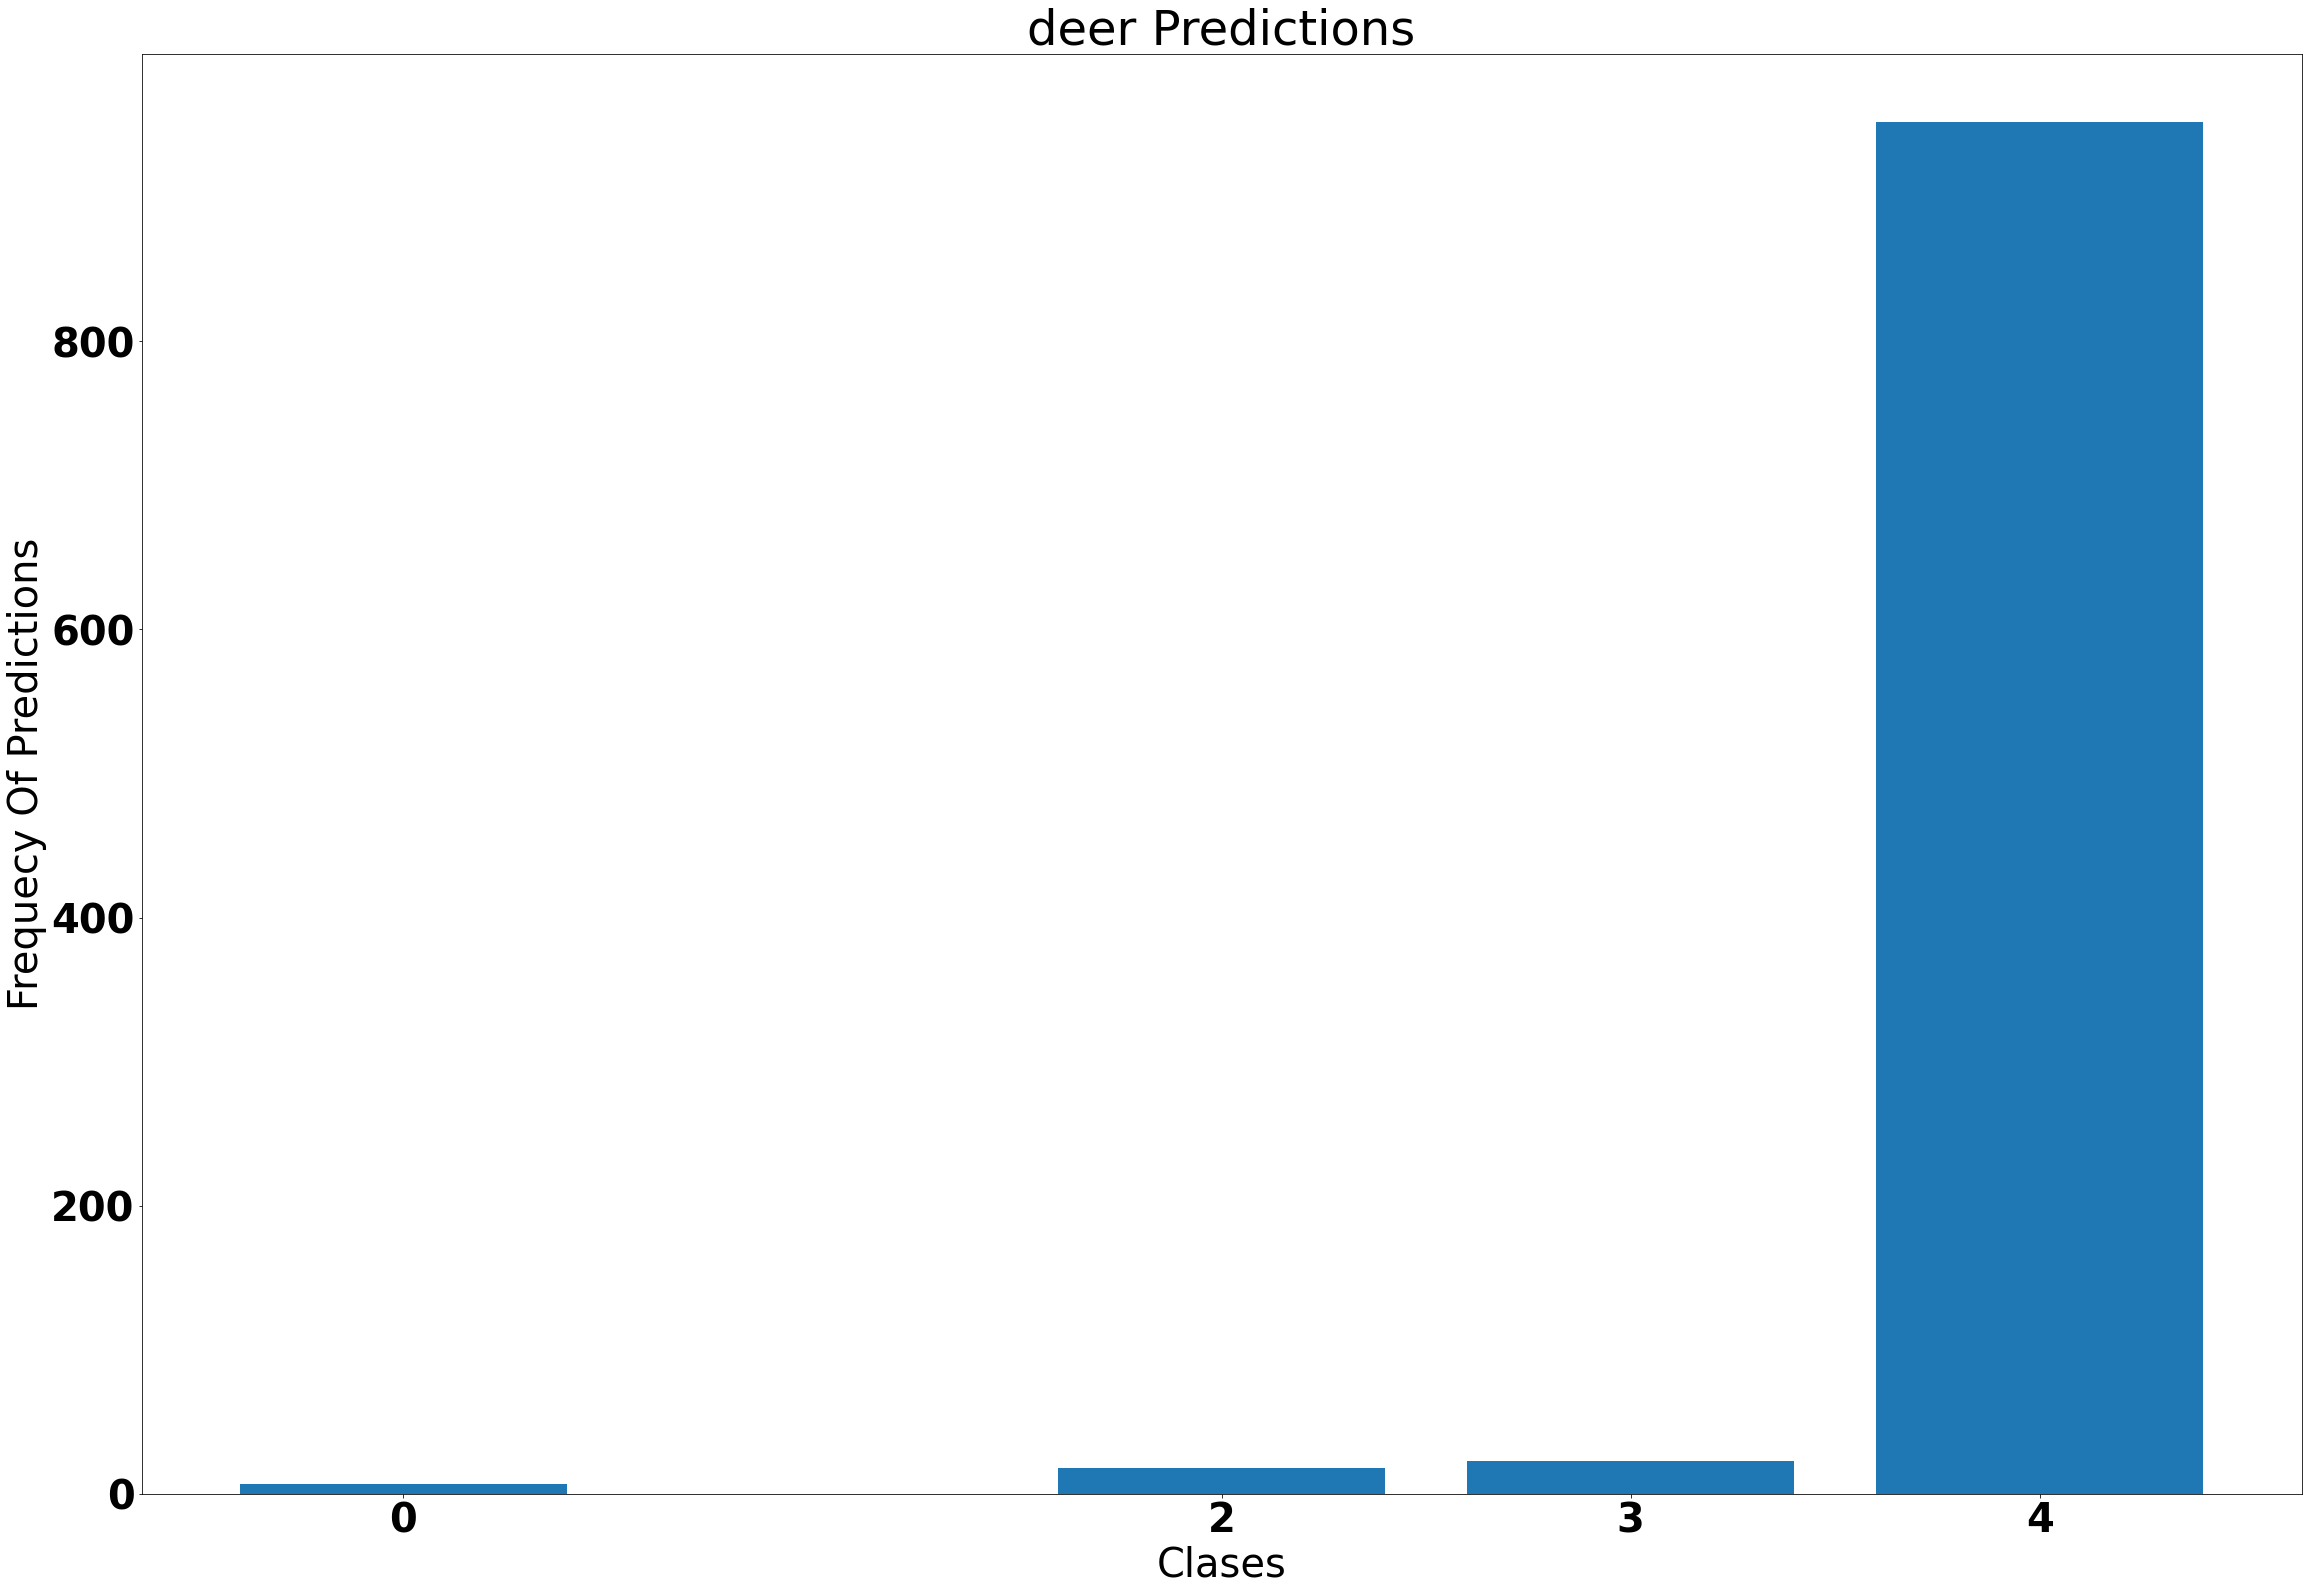

In [33]:
idx = 4
c = returnClassIndex(testY,idx)
preds = vote.predict(test_feat1[c])
plot_class_predictions(preds, idx,cclasses)

# SVM The Skin Disease Dataset

In [34]:
gnd_truth = pd.read_csv("data/SkinDiseaseDataset/ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))


# Dataset Summary

# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


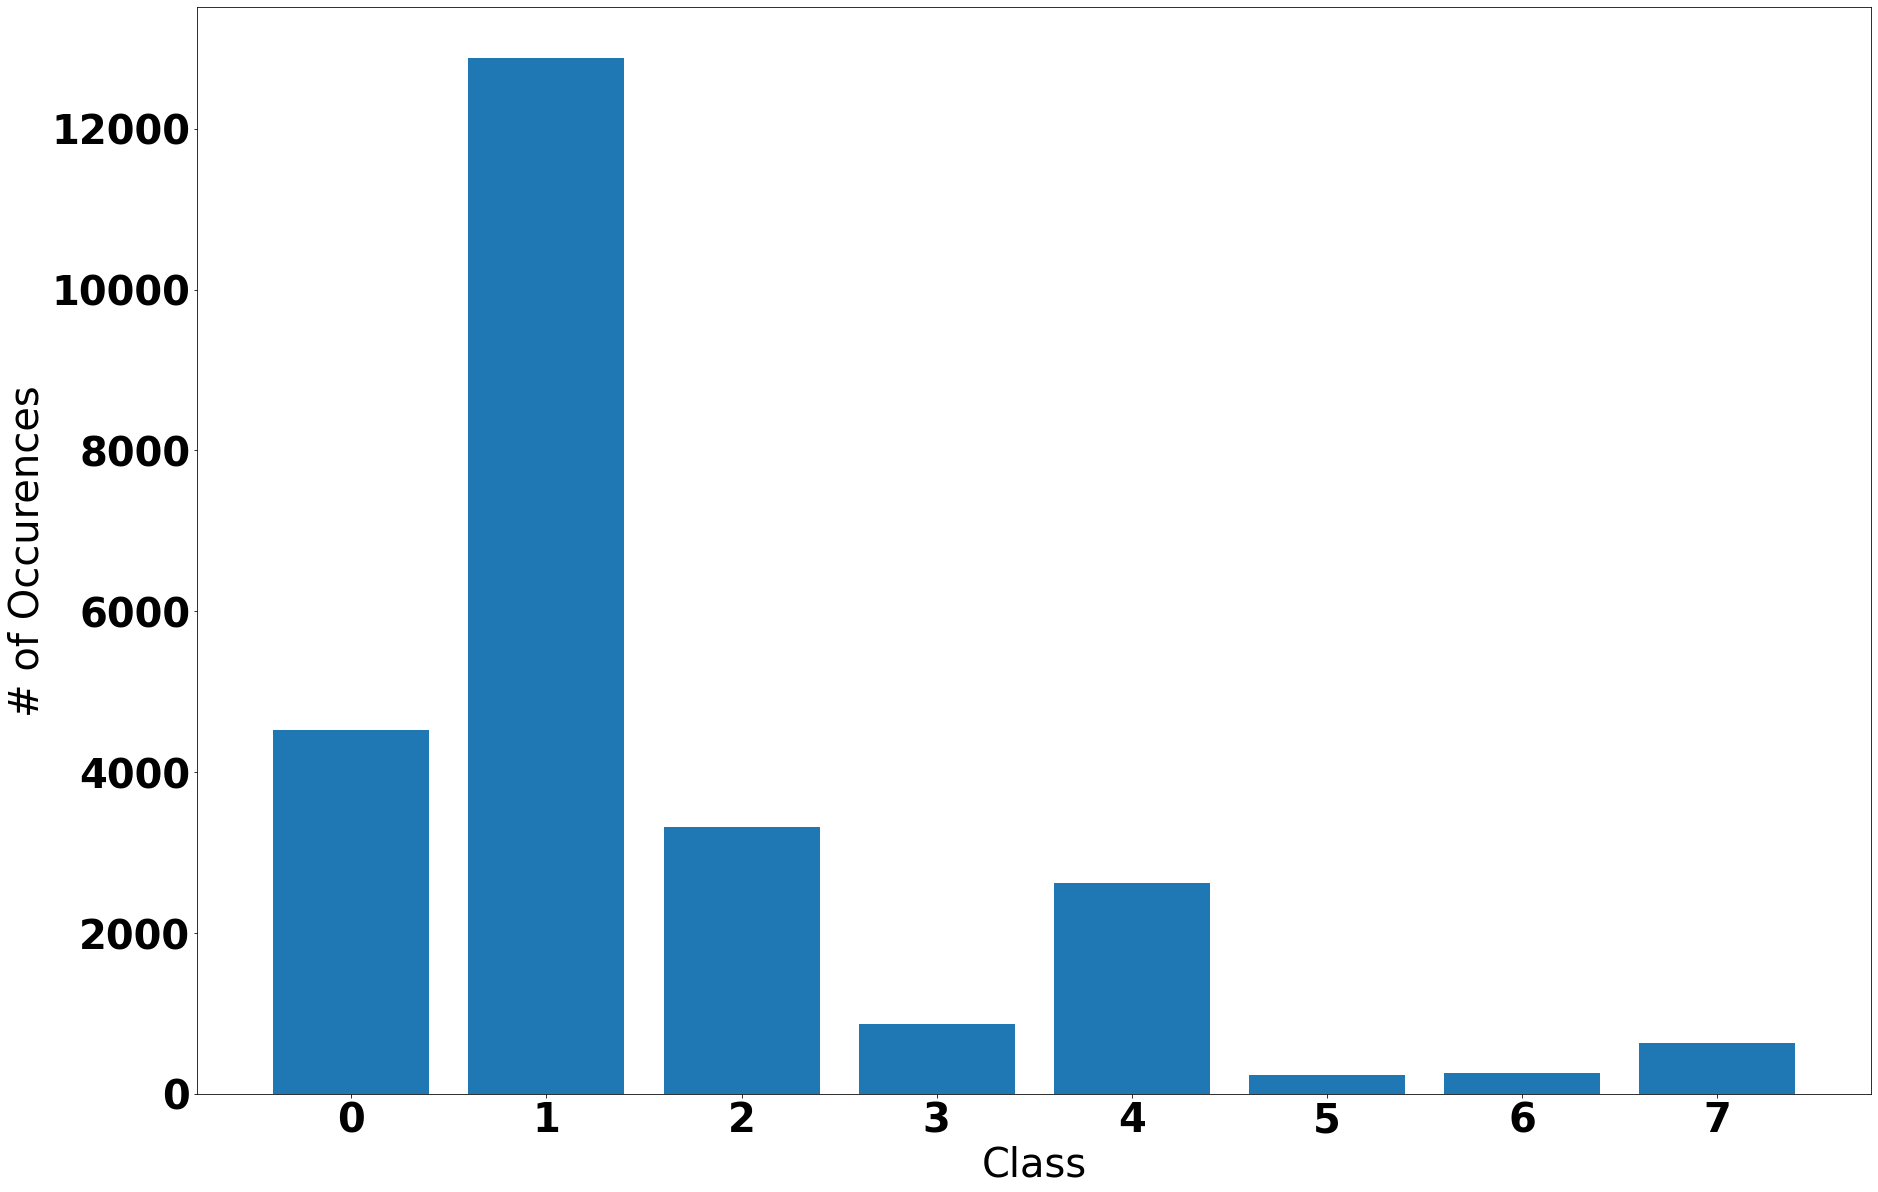

In [35]:
font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
matplotlib.rc('font', **font)
fig = plt.figure( figsize = (30,20))
c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [36]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]


### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])

paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [37]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 16

In [38]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths[smpl_train_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_train_idxs].astype(str)})
test_df = pd.DataFrame({"filename":paths[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size)
)

Found 18996 validated image filenames belonging to 8 classes.
Found 6335 validated image filenames belonging to 8 classes.


In [39]:
skin_trainY = []
skin_feat_train = []
for i in tqdm(range(len(train_generator))):
    tmp = next(train_generator)
    skin_feat_train.append(extractor0.predict(tmp[0]))
    skin_trainY.append(tmp[1])

100%|██████████| 1188/1188 [18:35<00:00,  1.07it/s]


In [40]:
skin_testY = []
skin_feat_test = []
for i in tqdm(range(len(test_generator))):
    tmp = next(test_generator)
    skin_feat_test.append(extractor0.predict(tmp[0]))
    skin_testY.append(tmp[1])

100%|██████████| 396/396 [04:43<00:00,  1.40it/s]


In [41]:
skin_trainY_ = np.vstack(skin_trainY)
skin_feat_train_ = np.vstack(skin_feat_train)
skin_testY_ = np.vstack(skin_testY)
skin_feat_test_ = np.vstack(skin_feat_test)

In [42]:
### Selecting the classes
hold_in_train_classes = [0,1,2,3]
hold_in_train_classes_idx = []
for i in hold_in_train_classes:
    hold_in_train_classes_idx = hold_in_train_classes_idx+returnClassIndex(skin_trainY_,i)

In [43]:
max(np.argmax(skin_trainY_[hold_in_train_classes_idx], axis =1))

3

# SVM Voting Ensemble with different kernels

In [44]:
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC
ss1 = SVC(C= 0.7, kernel = 'linear')
ss2 = SVC(C= 0.7,kernel = 'rbf')
ss3 = SVC(C= 0.7,kernel = 'poly', degree = 2)
ss4 = SVC(C= 0.7,kernel = 'sigmoid')
skin_estimators = [('linSVC',ss1),('rbfSVC',ss2),('polySVC', ss3),
              ('sigmoid',ss4)]

svote = VotingClassifier(skin_estimators)
svote.fit(skin_feat_train_[hold_in_train_classes_idx], 
          np.argmax(skin_trainY_[hold_in_train_classes_idx], axis =1))

VotingClassifier(estimators=[('linSVC', SVC(C=0.7, kernel='linear')),
                             ('rbfSVC', SVC(C=0.7)),
                             ('polySVC', SVC(C=0.7, degree=2, kernel='poly')),
                             ('sigmoid', SVC(C=0.7, kernel='sigmoid'))])

In [45]:
### Selecting the classes
hold_in_test_classes = [0,1,2,3]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(skin_testY_,i)

In [46]:
from sklearn.metrics import accuracy_score 
s_groundTruth =np.argmax(skin_testY_[hold_in_test_classes_idx], axis = 1)
s_pred = svote.predict(np.vstack(skin_feat_test_[hold_in_test_classes_idx]))

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(s_groundTruth, s_pred, average = "macro")
acc = accuracy_score(s_groundTruth, s_pred)
recall = recall_score(s_groundTruth, s_pred,   average = "macro")

precision =precision_score(s_groundTruth, s_pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(s_groundTruth), 
                tf.keras.utils.to_categorical(s_pred, num_classes =4 ))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 12.489753895576197
Accuracy: 0.6383845868840311
F1 Score: 0.2962201713906709
recall Score: 0.3104741882906952
Precision Score: 0.5120325061671307


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


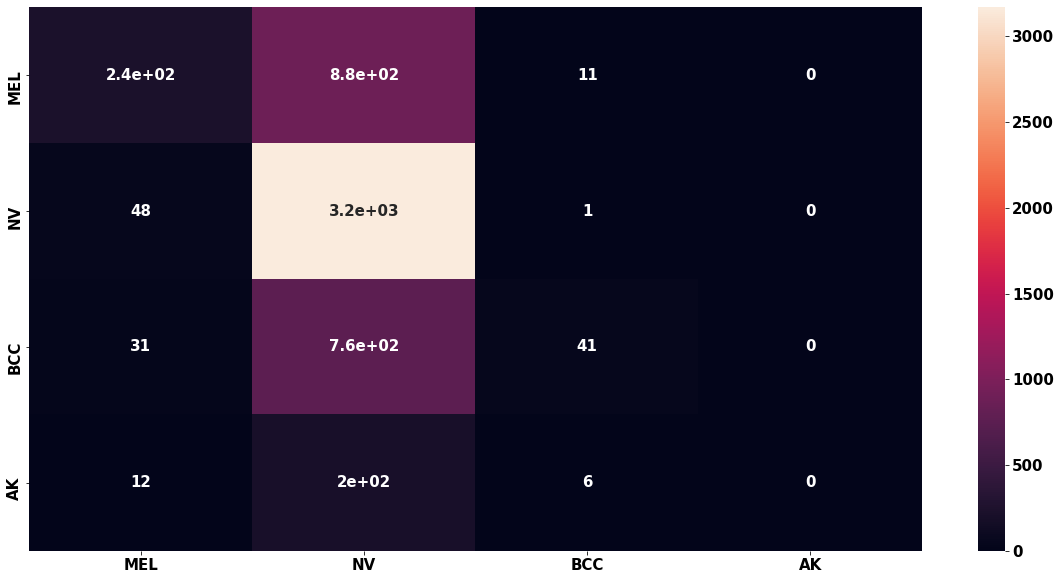

In [48]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(s_groundTruth,s_pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])[:4]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_svm/conf_skin.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/conf_skin.pdf", dpi = 200)

In [49]:
y_test.shape

(5000, 5)

<ipython-input-50-c7cf6562cb98>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


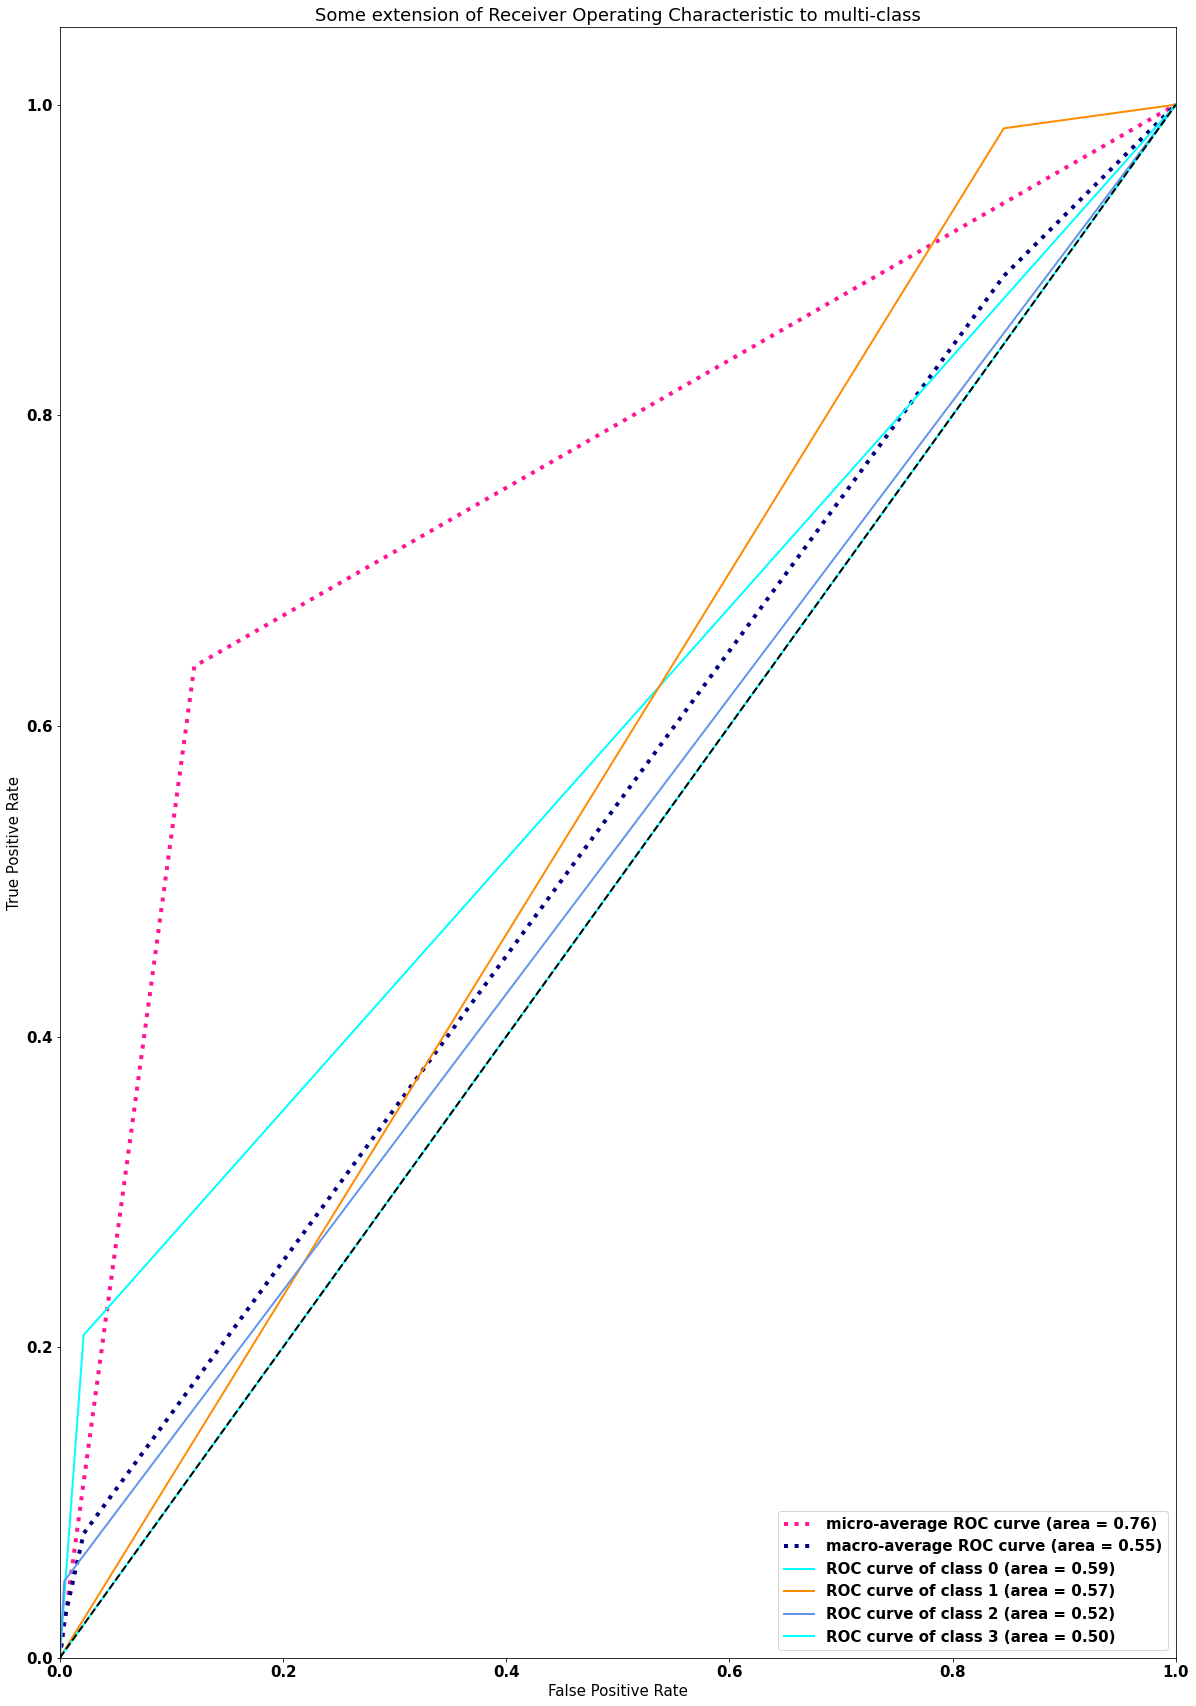

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical( s_groundTruth, num_classes = 4))
y_score = np.copy(tf.keras.utils.to_categorical(s_pred, num_classes =4 ))
n_classes =  4
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_svm/roc_skin old.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/roc_skin old.pdf", dpi = 200)
plt.show()

In [51]:
sclasses =list(gnd_truth.columns[1:-1])

Missing classes on the bar chart indicate that there are no prediction for them

Class #0


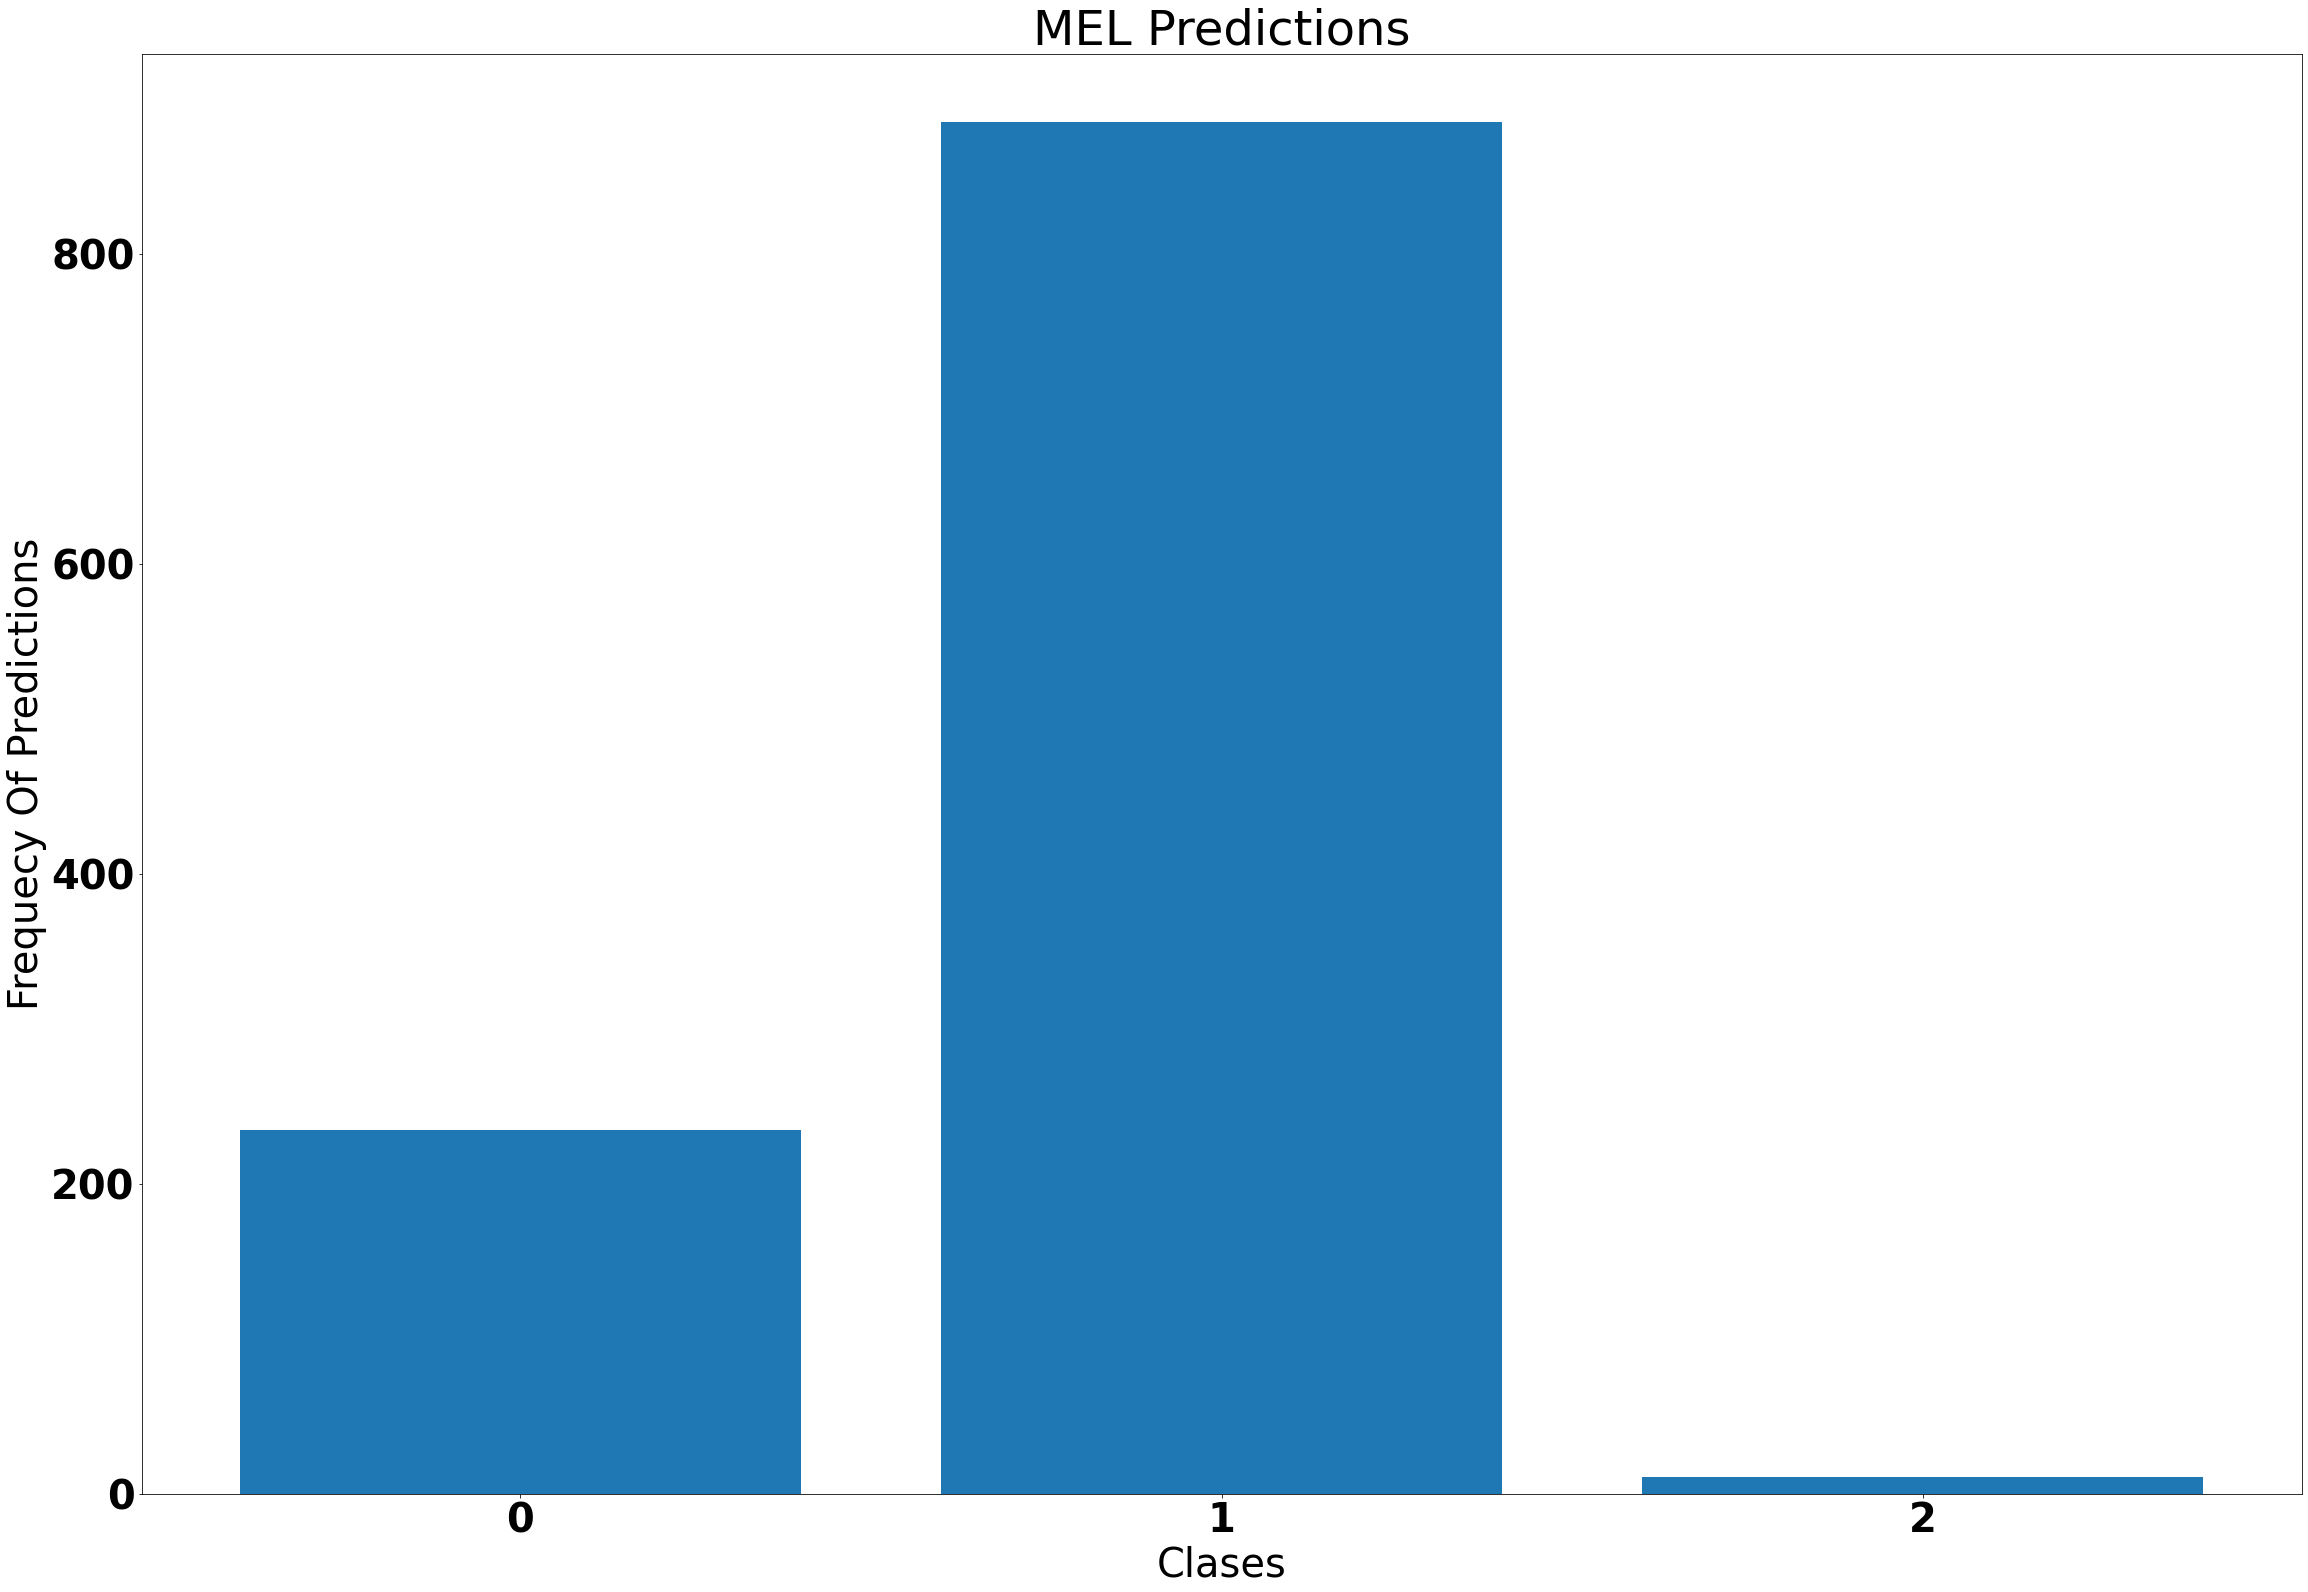

In [52]:
sclasses =list(gnd_truth.columns[1:-1])[:4]
idx = 0
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #1


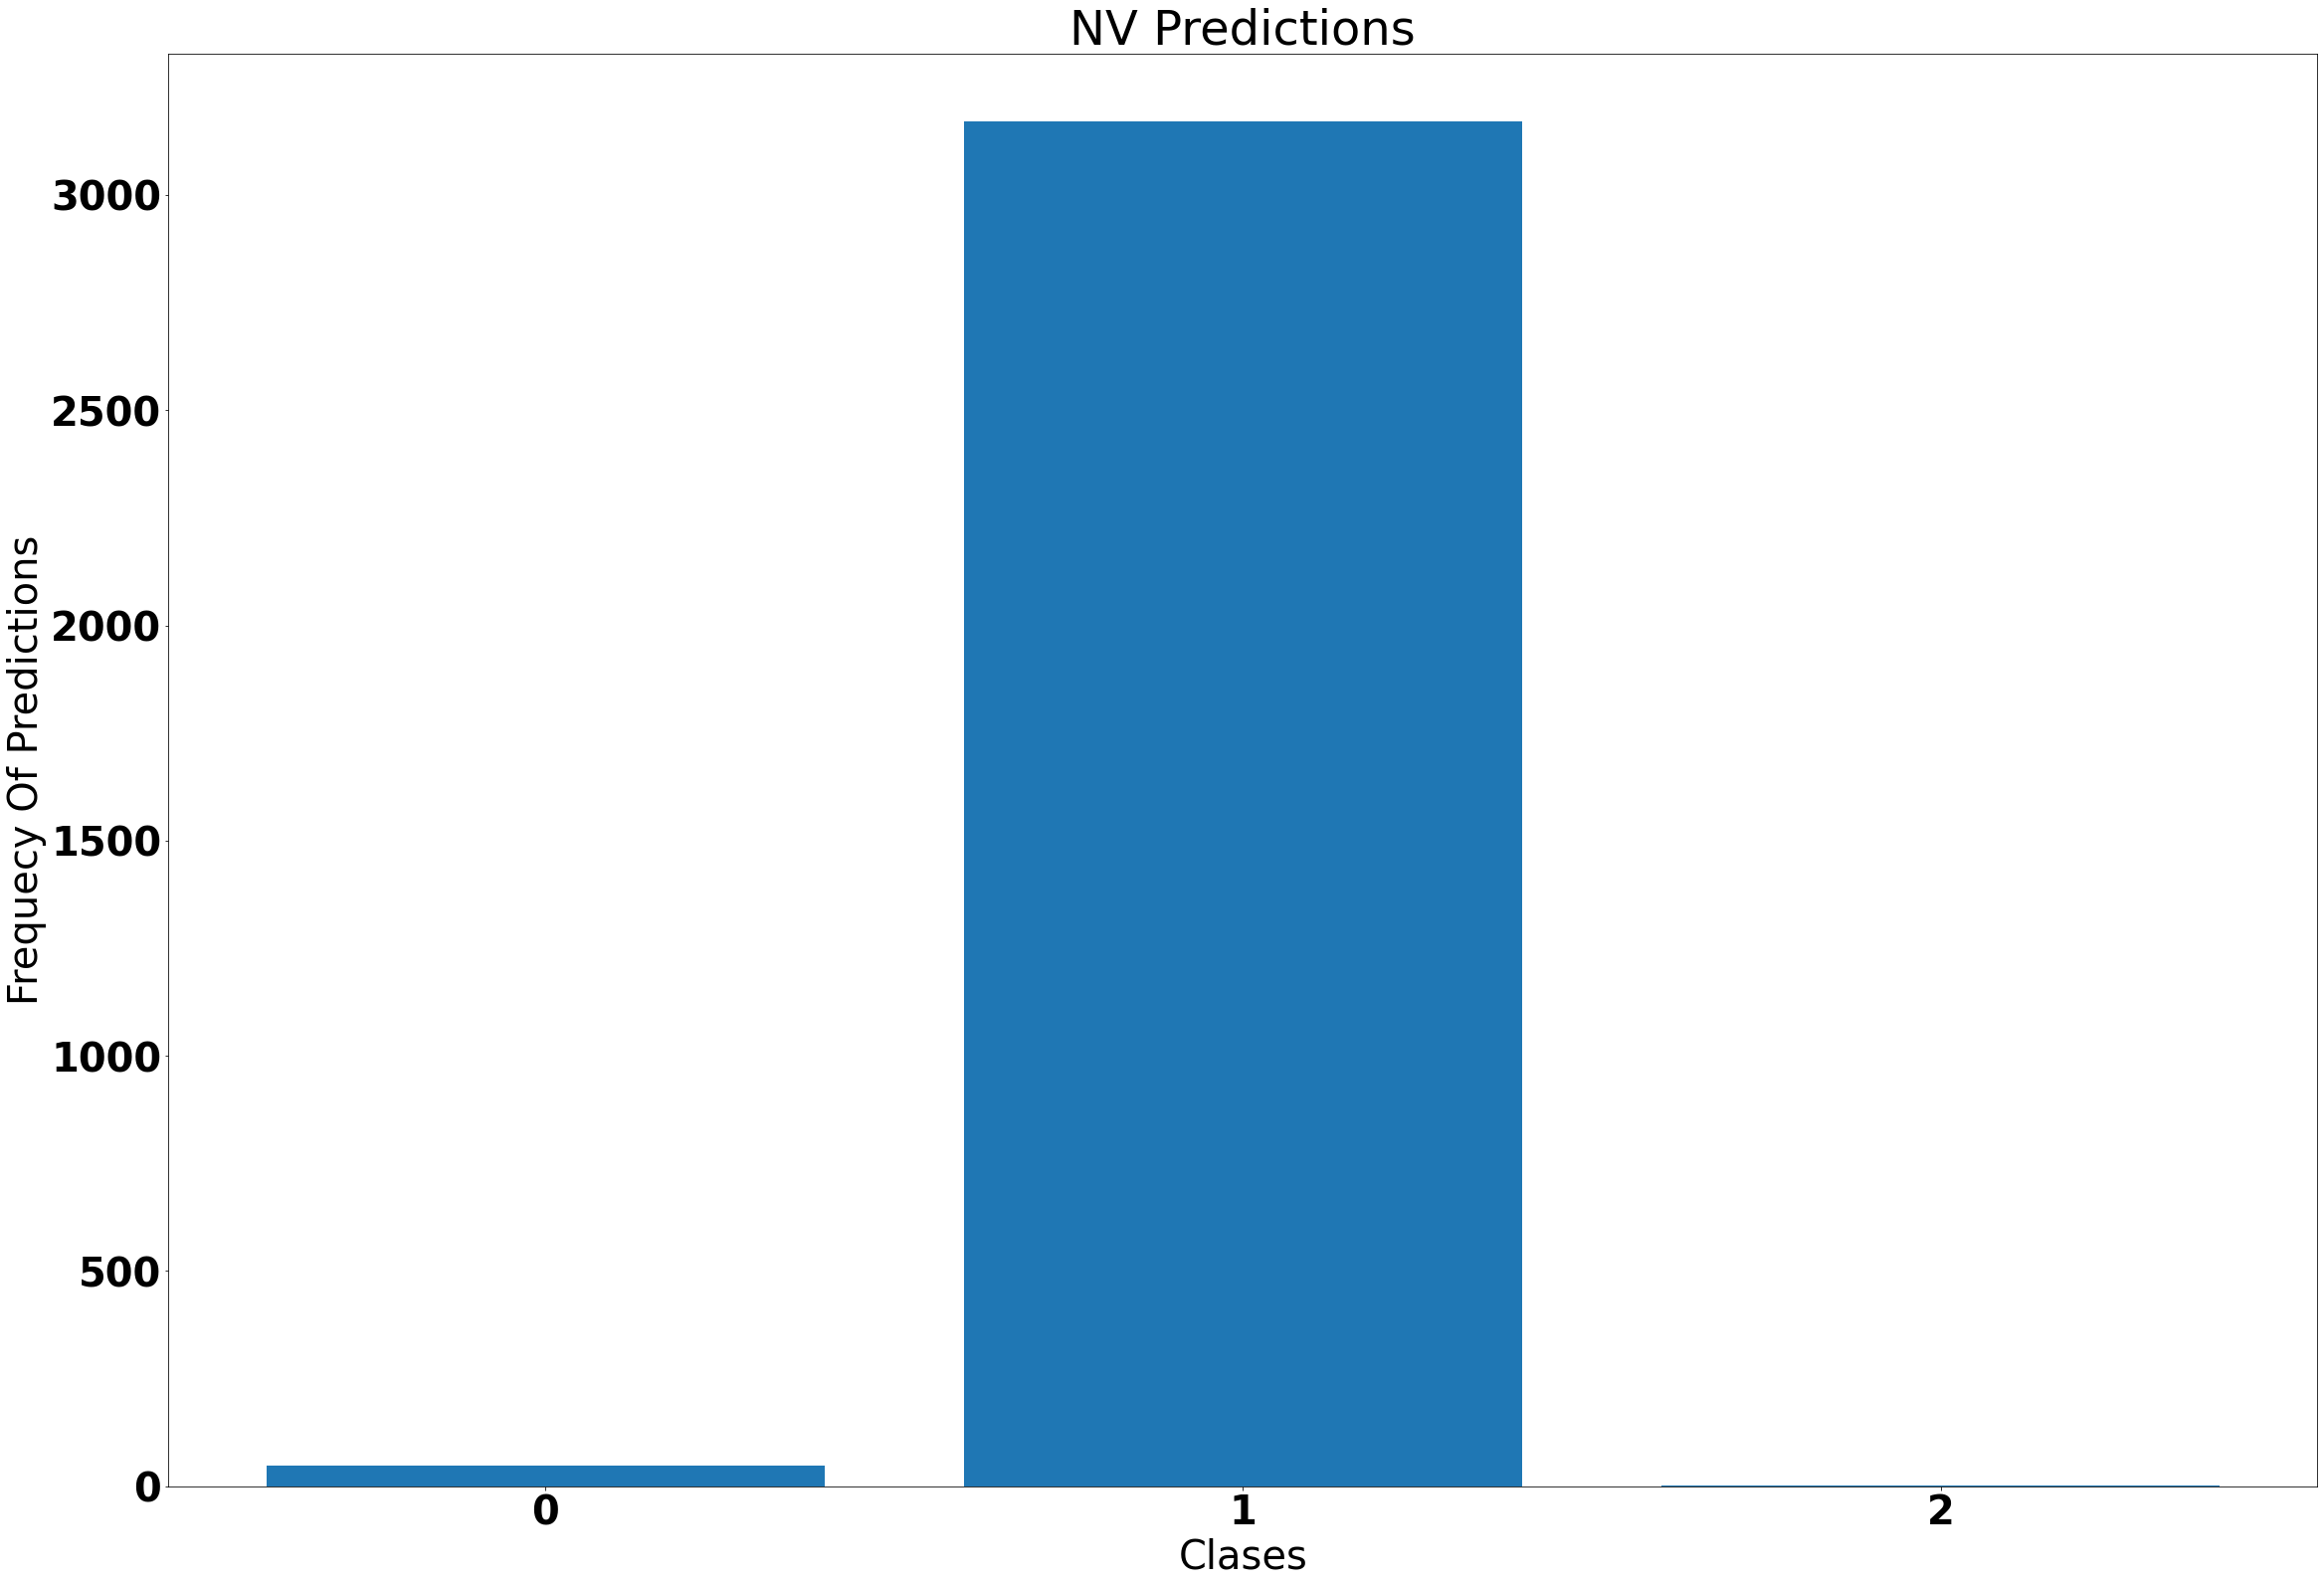

In [53]:
idx = 1
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)

Class #2


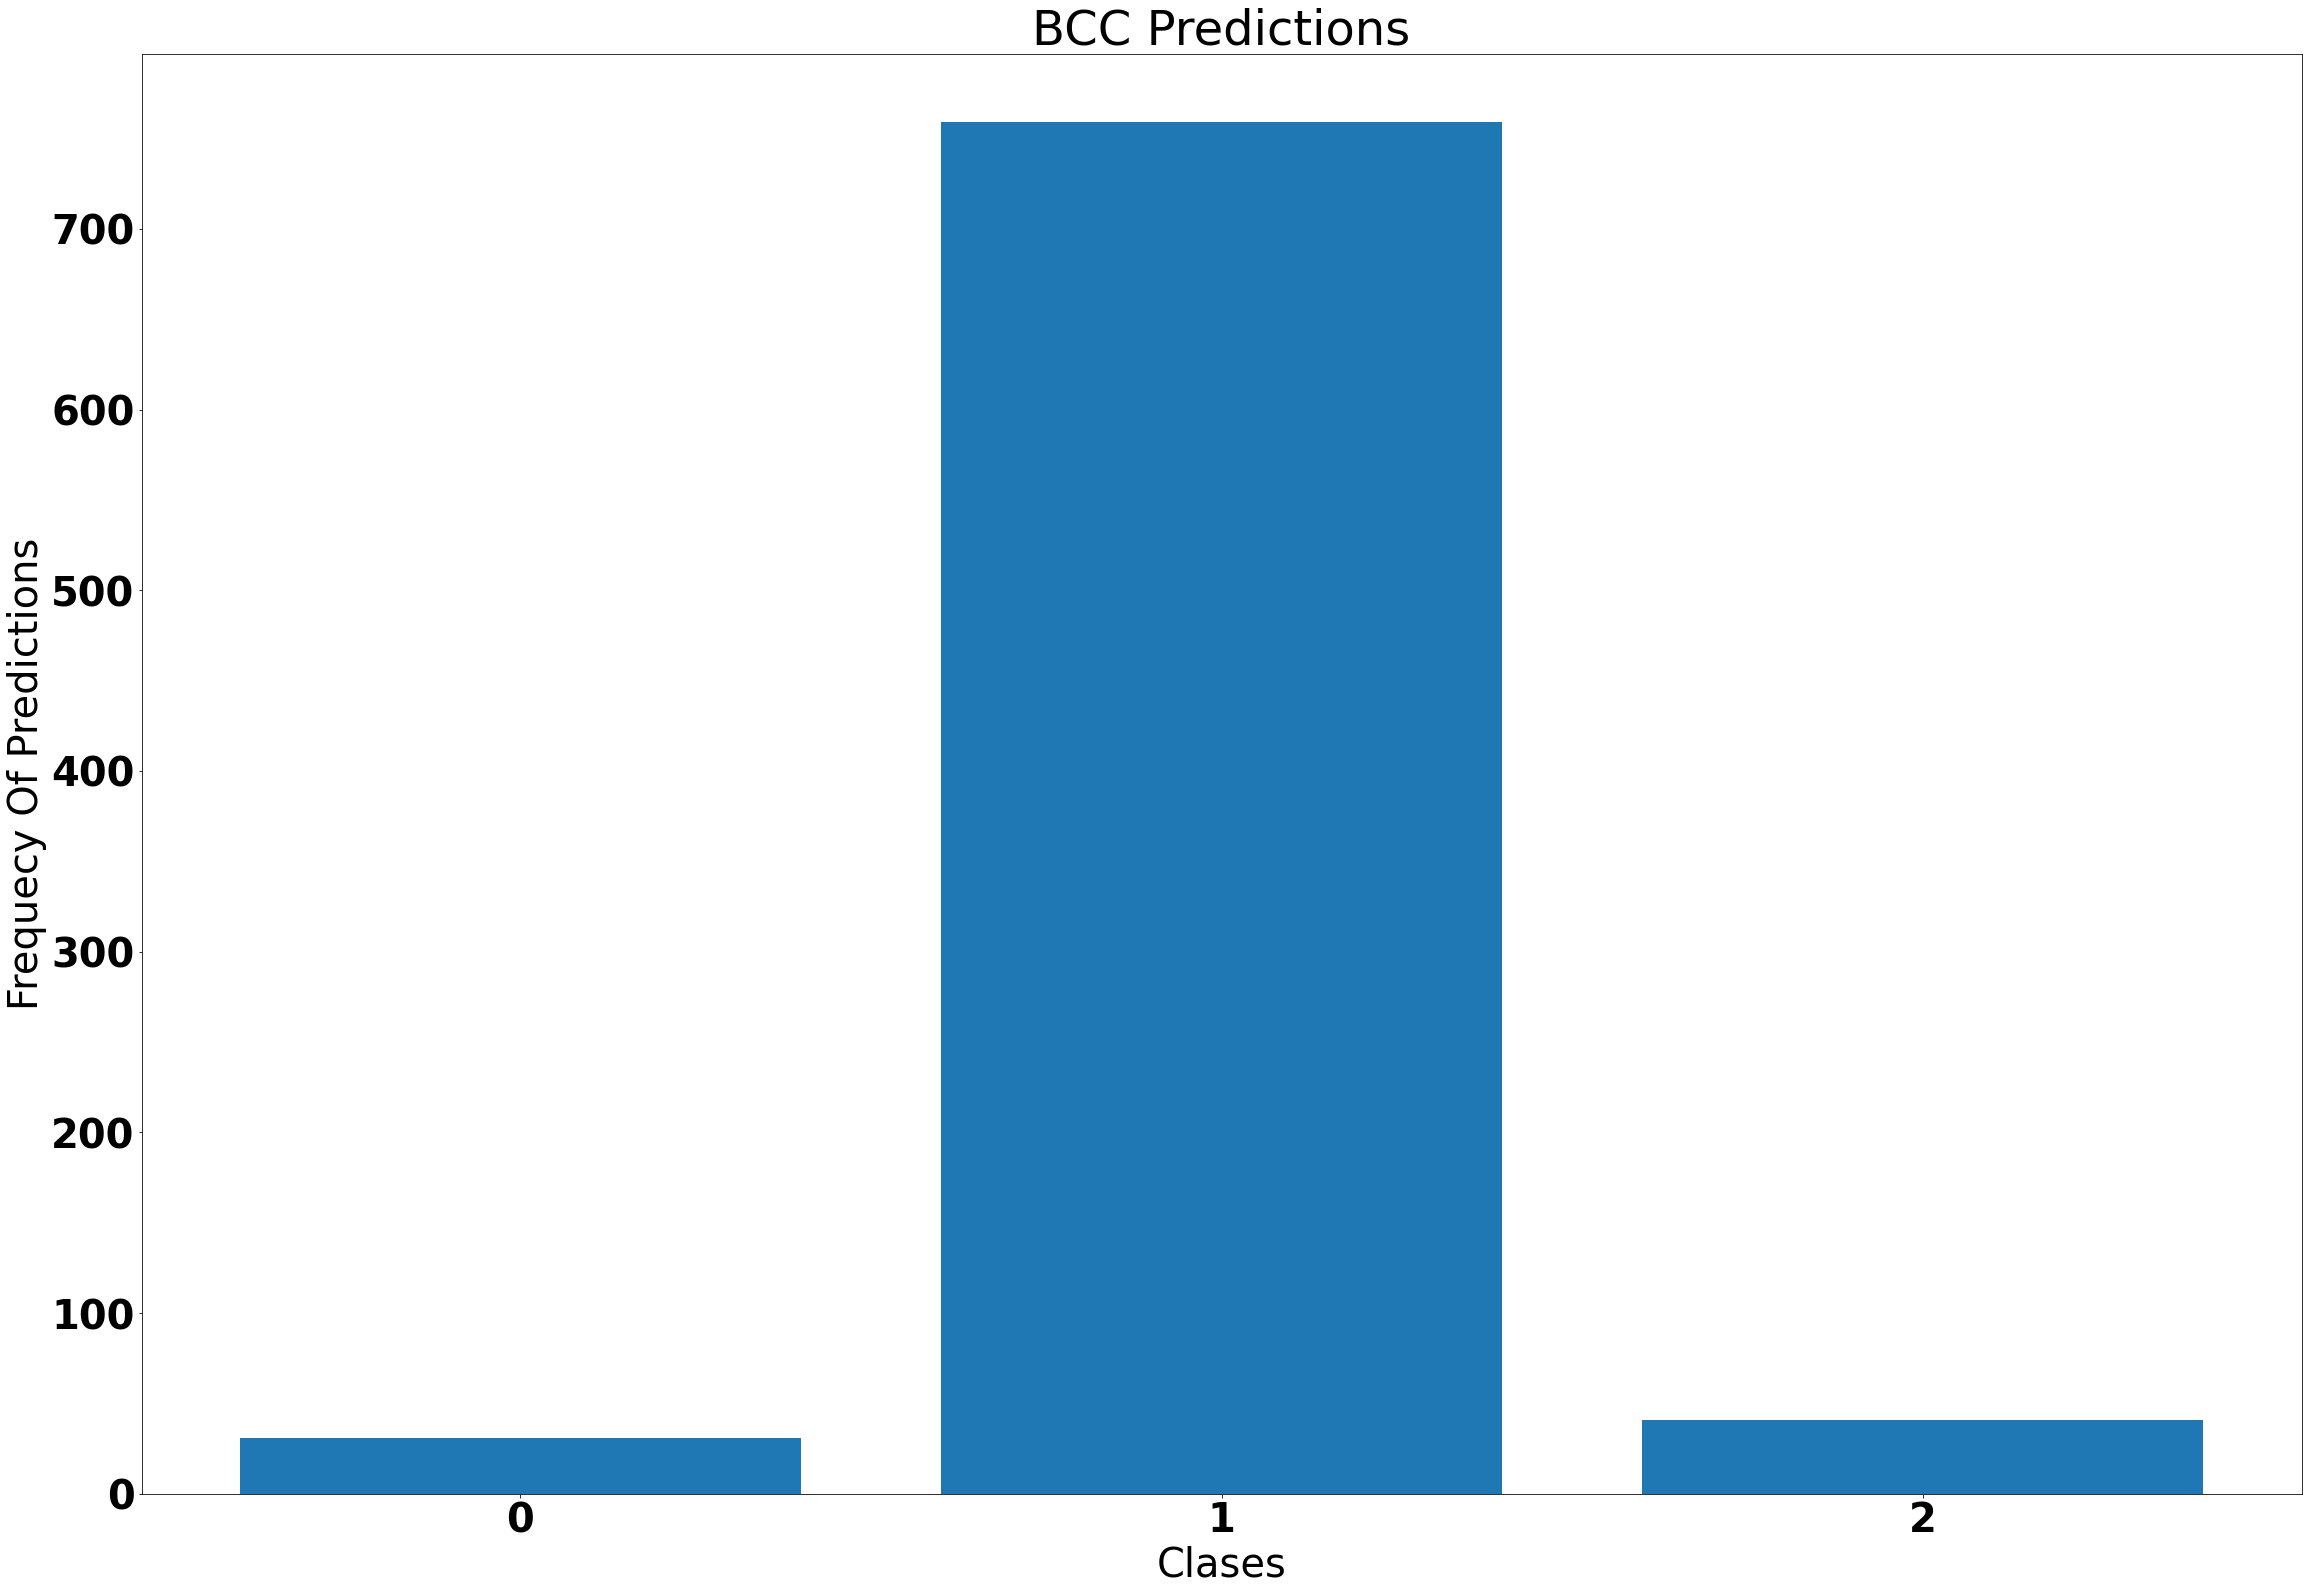

In [54]:
idx = 2
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)

Class #3


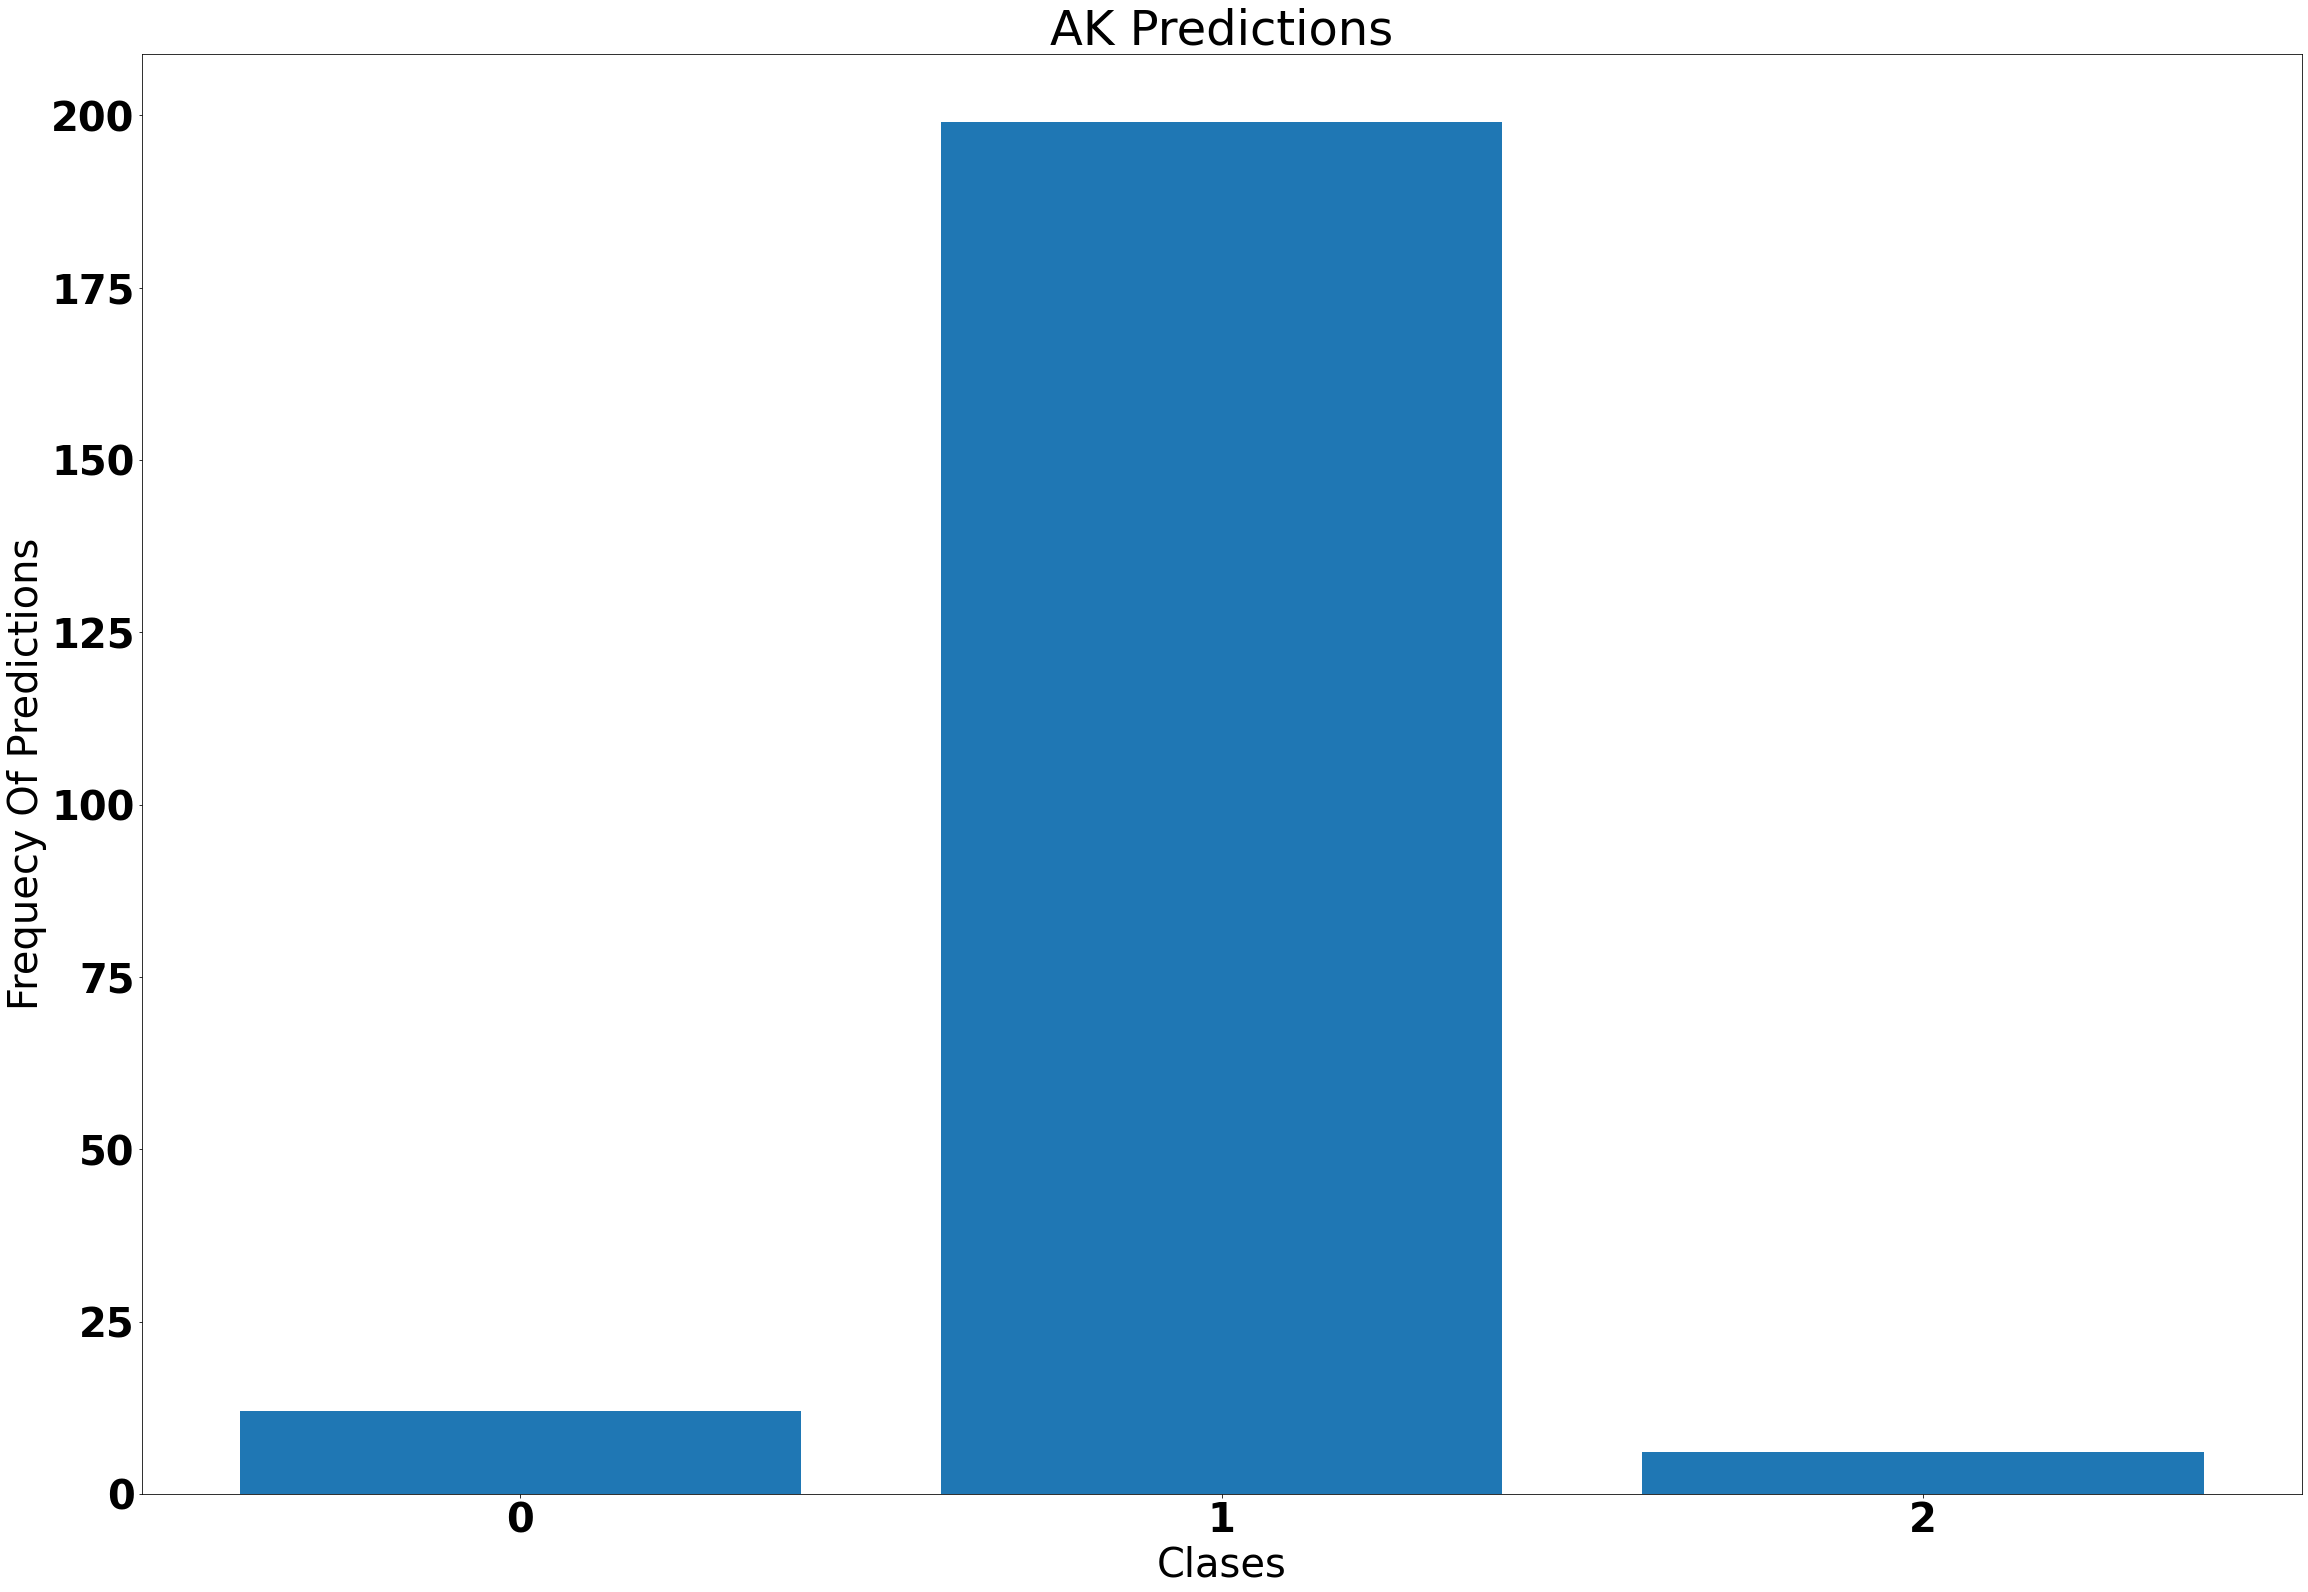

In [55]:
idx = 3
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)

## Skin Disease (New clases) 

In [56]:
### Selecting the classes
hold_in_test_classes = [4,5,6,7]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(skin_testY_,i)

In [57]:
from sklearn.metrics import accuracy_score 
s_groundTruth =np.argmax(skin_testY_[hold_in_test_classes_idx], axis = 1)-4
s_pred = svote.predict(np.vstack(skin_feat_test_[hold_in_test_classes_idx]))

In [58]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(s_groundTruth, s_pred, average = "macro")
acc = accuracy_score(s_groundTruth, s_pred)
recall = recall_score(s_groundTruth, s_pred,   average = "macro")

precision =precision_score(s_groundTruth, s_pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(s_groundTruth), 
                tf.keras.utils.to_categorical(s_pred, num_classes =4 ))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 30.926396368916286
Accuracy: 0.10458911419423693
F1 Score: 0.06511939138765613
recall Score: 0.2566501524390244
Precision Score: 0.21634603289609403


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


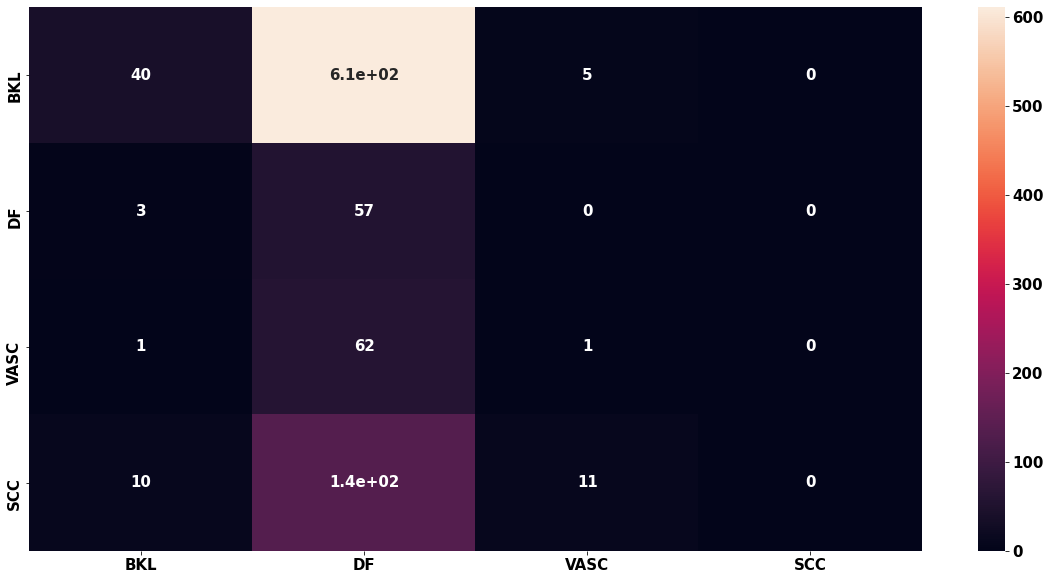

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(s_groundTruth,s_pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])[-4:]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_svm/conf_skin New Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/conf_skin New Classes.pdf", dpi = 200)

In [60]:
y_test.shape

(5398, 4)

<ipython-input-61-ad3b88650711>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


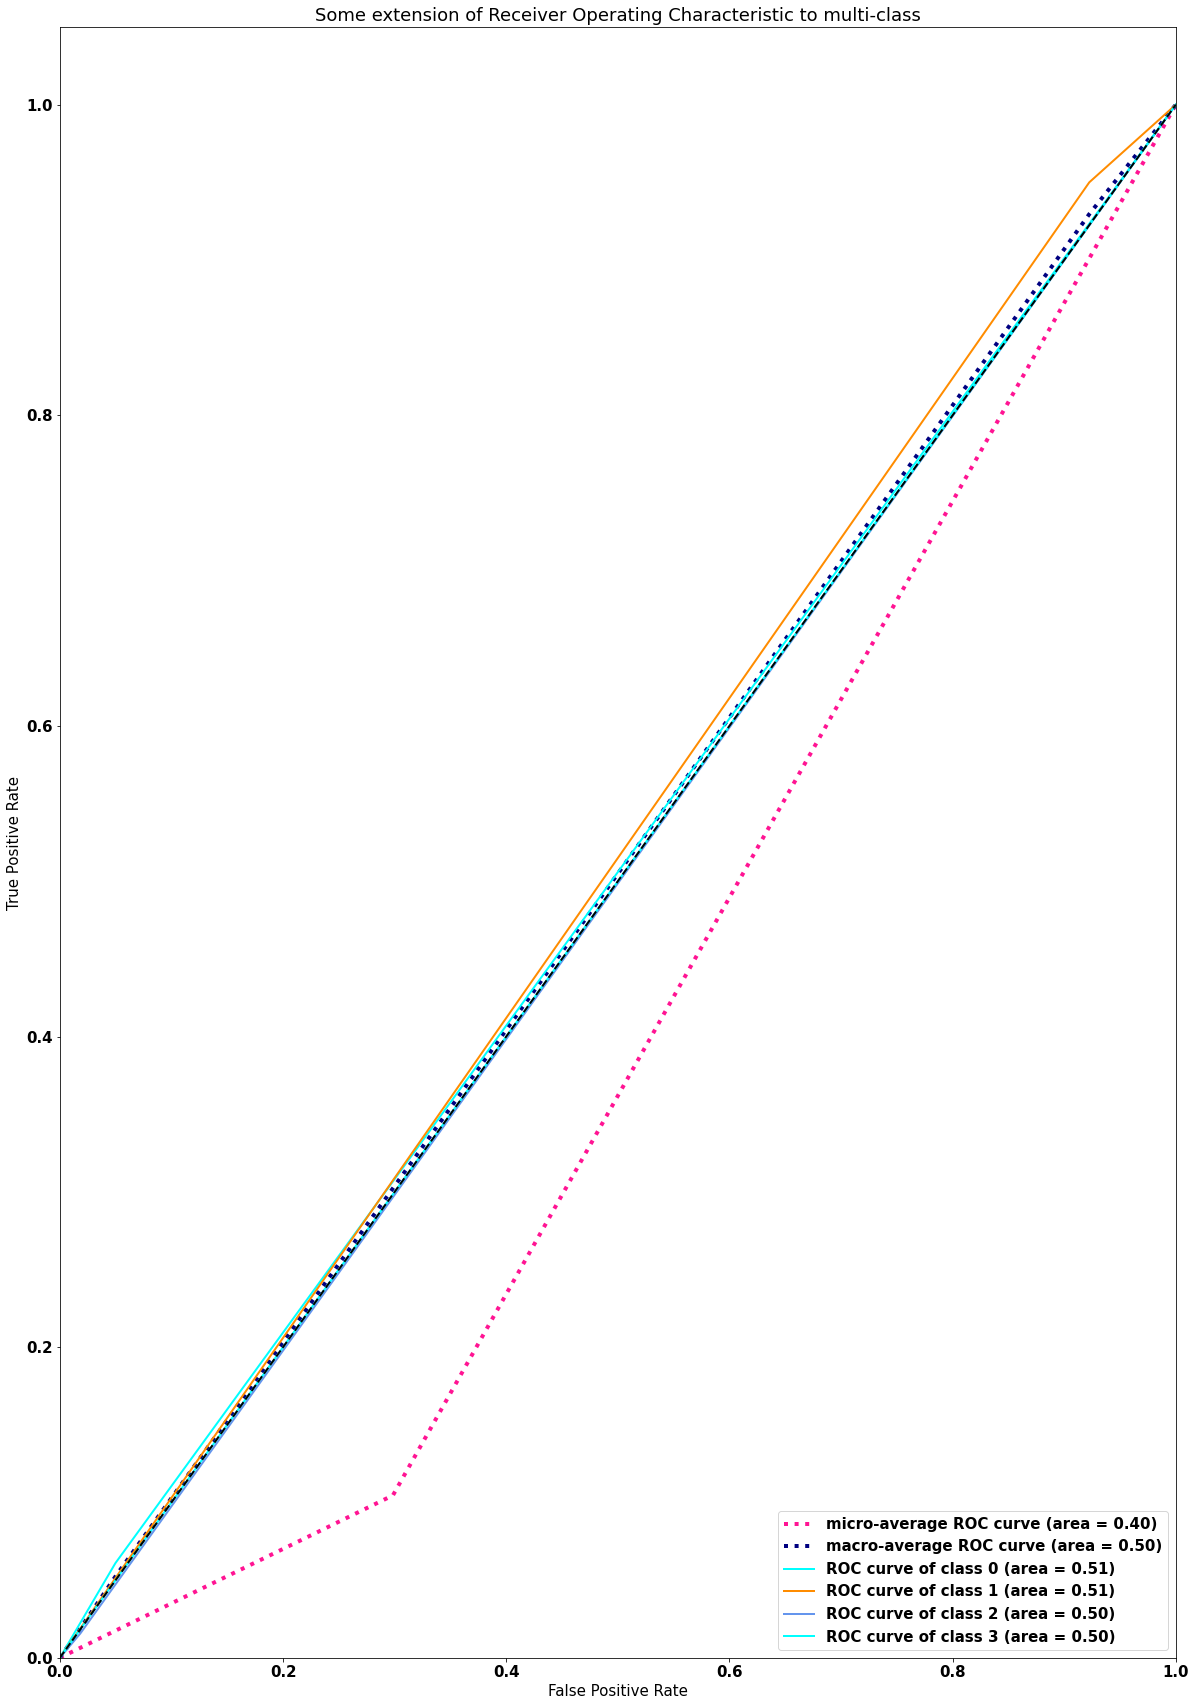

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical( s_groundTruth, num_classes = 4))
y_score = np.copy(tf.keras.utils.to_categorical(s_pred, num_classes =4 ))
n_classes =  4
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_svm/roc_skin New Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_svm/roc_skin New Classes.pdf", dpi = 200)
plt.show()

Missing classes on the bar chart indicate that there are no prediction for them

Class #0


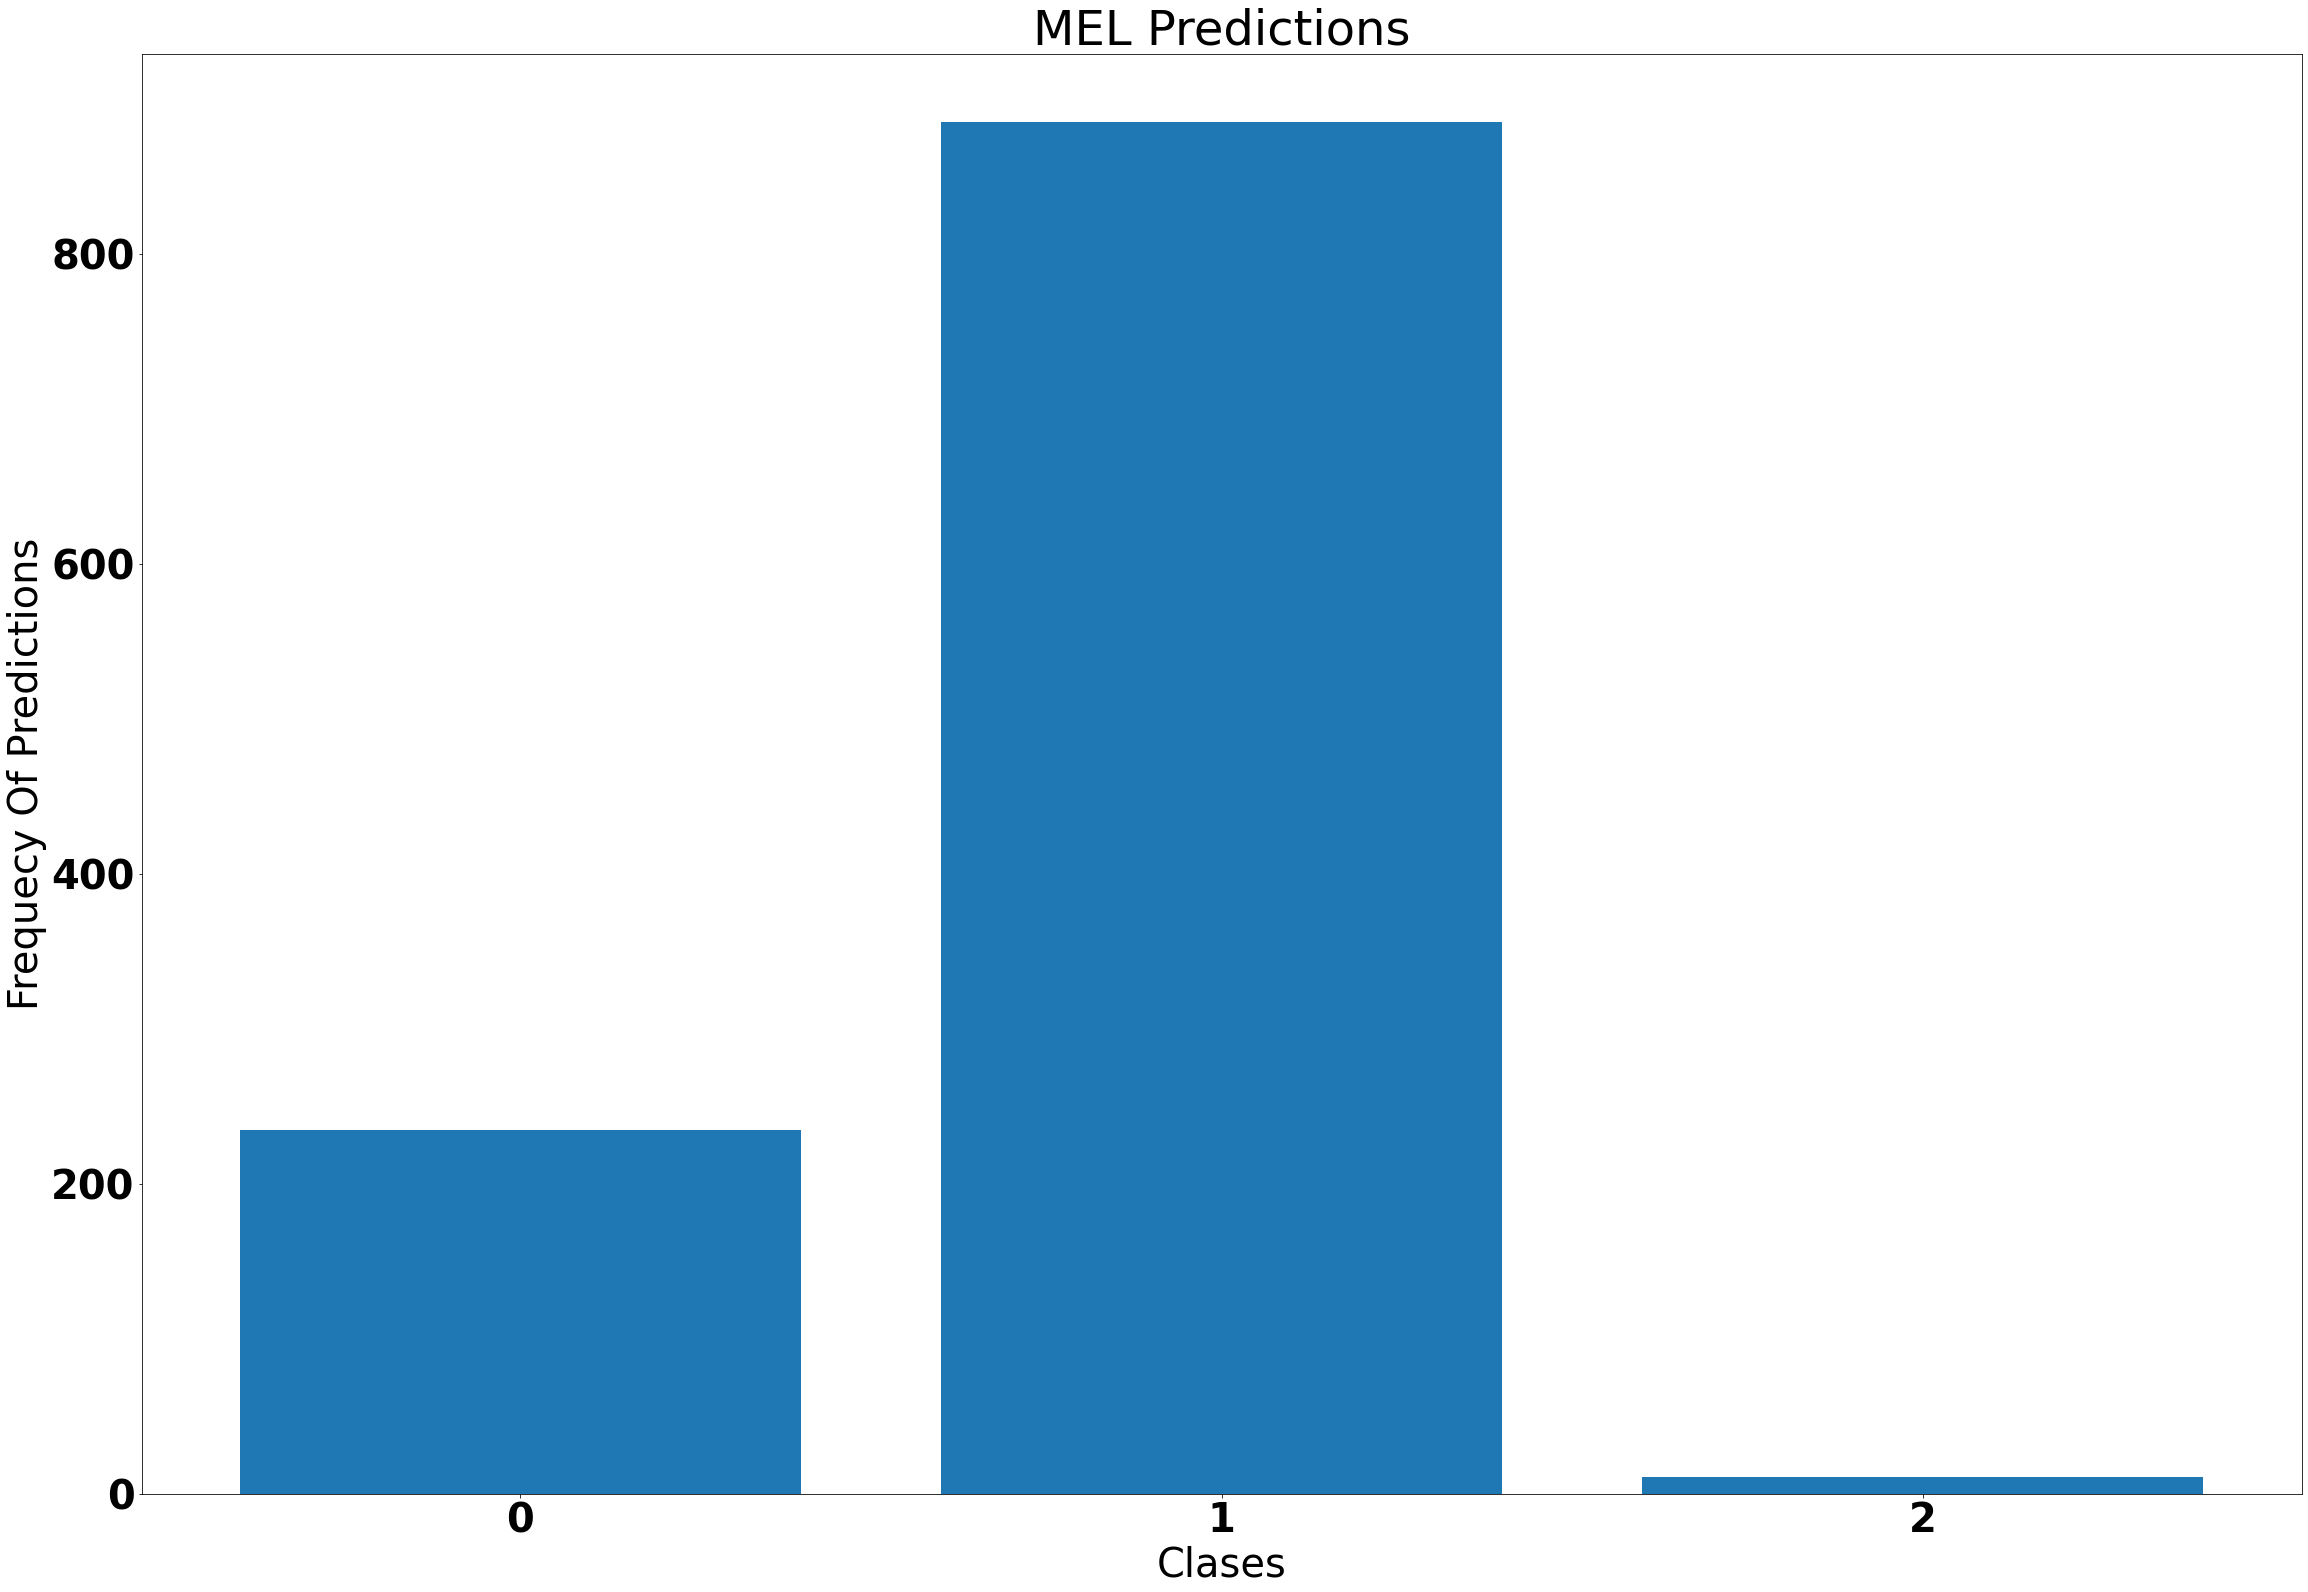

In [62]:
sclasses =list(gnd_truth.columns[1:-1])[:4]
idx = 0
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #1


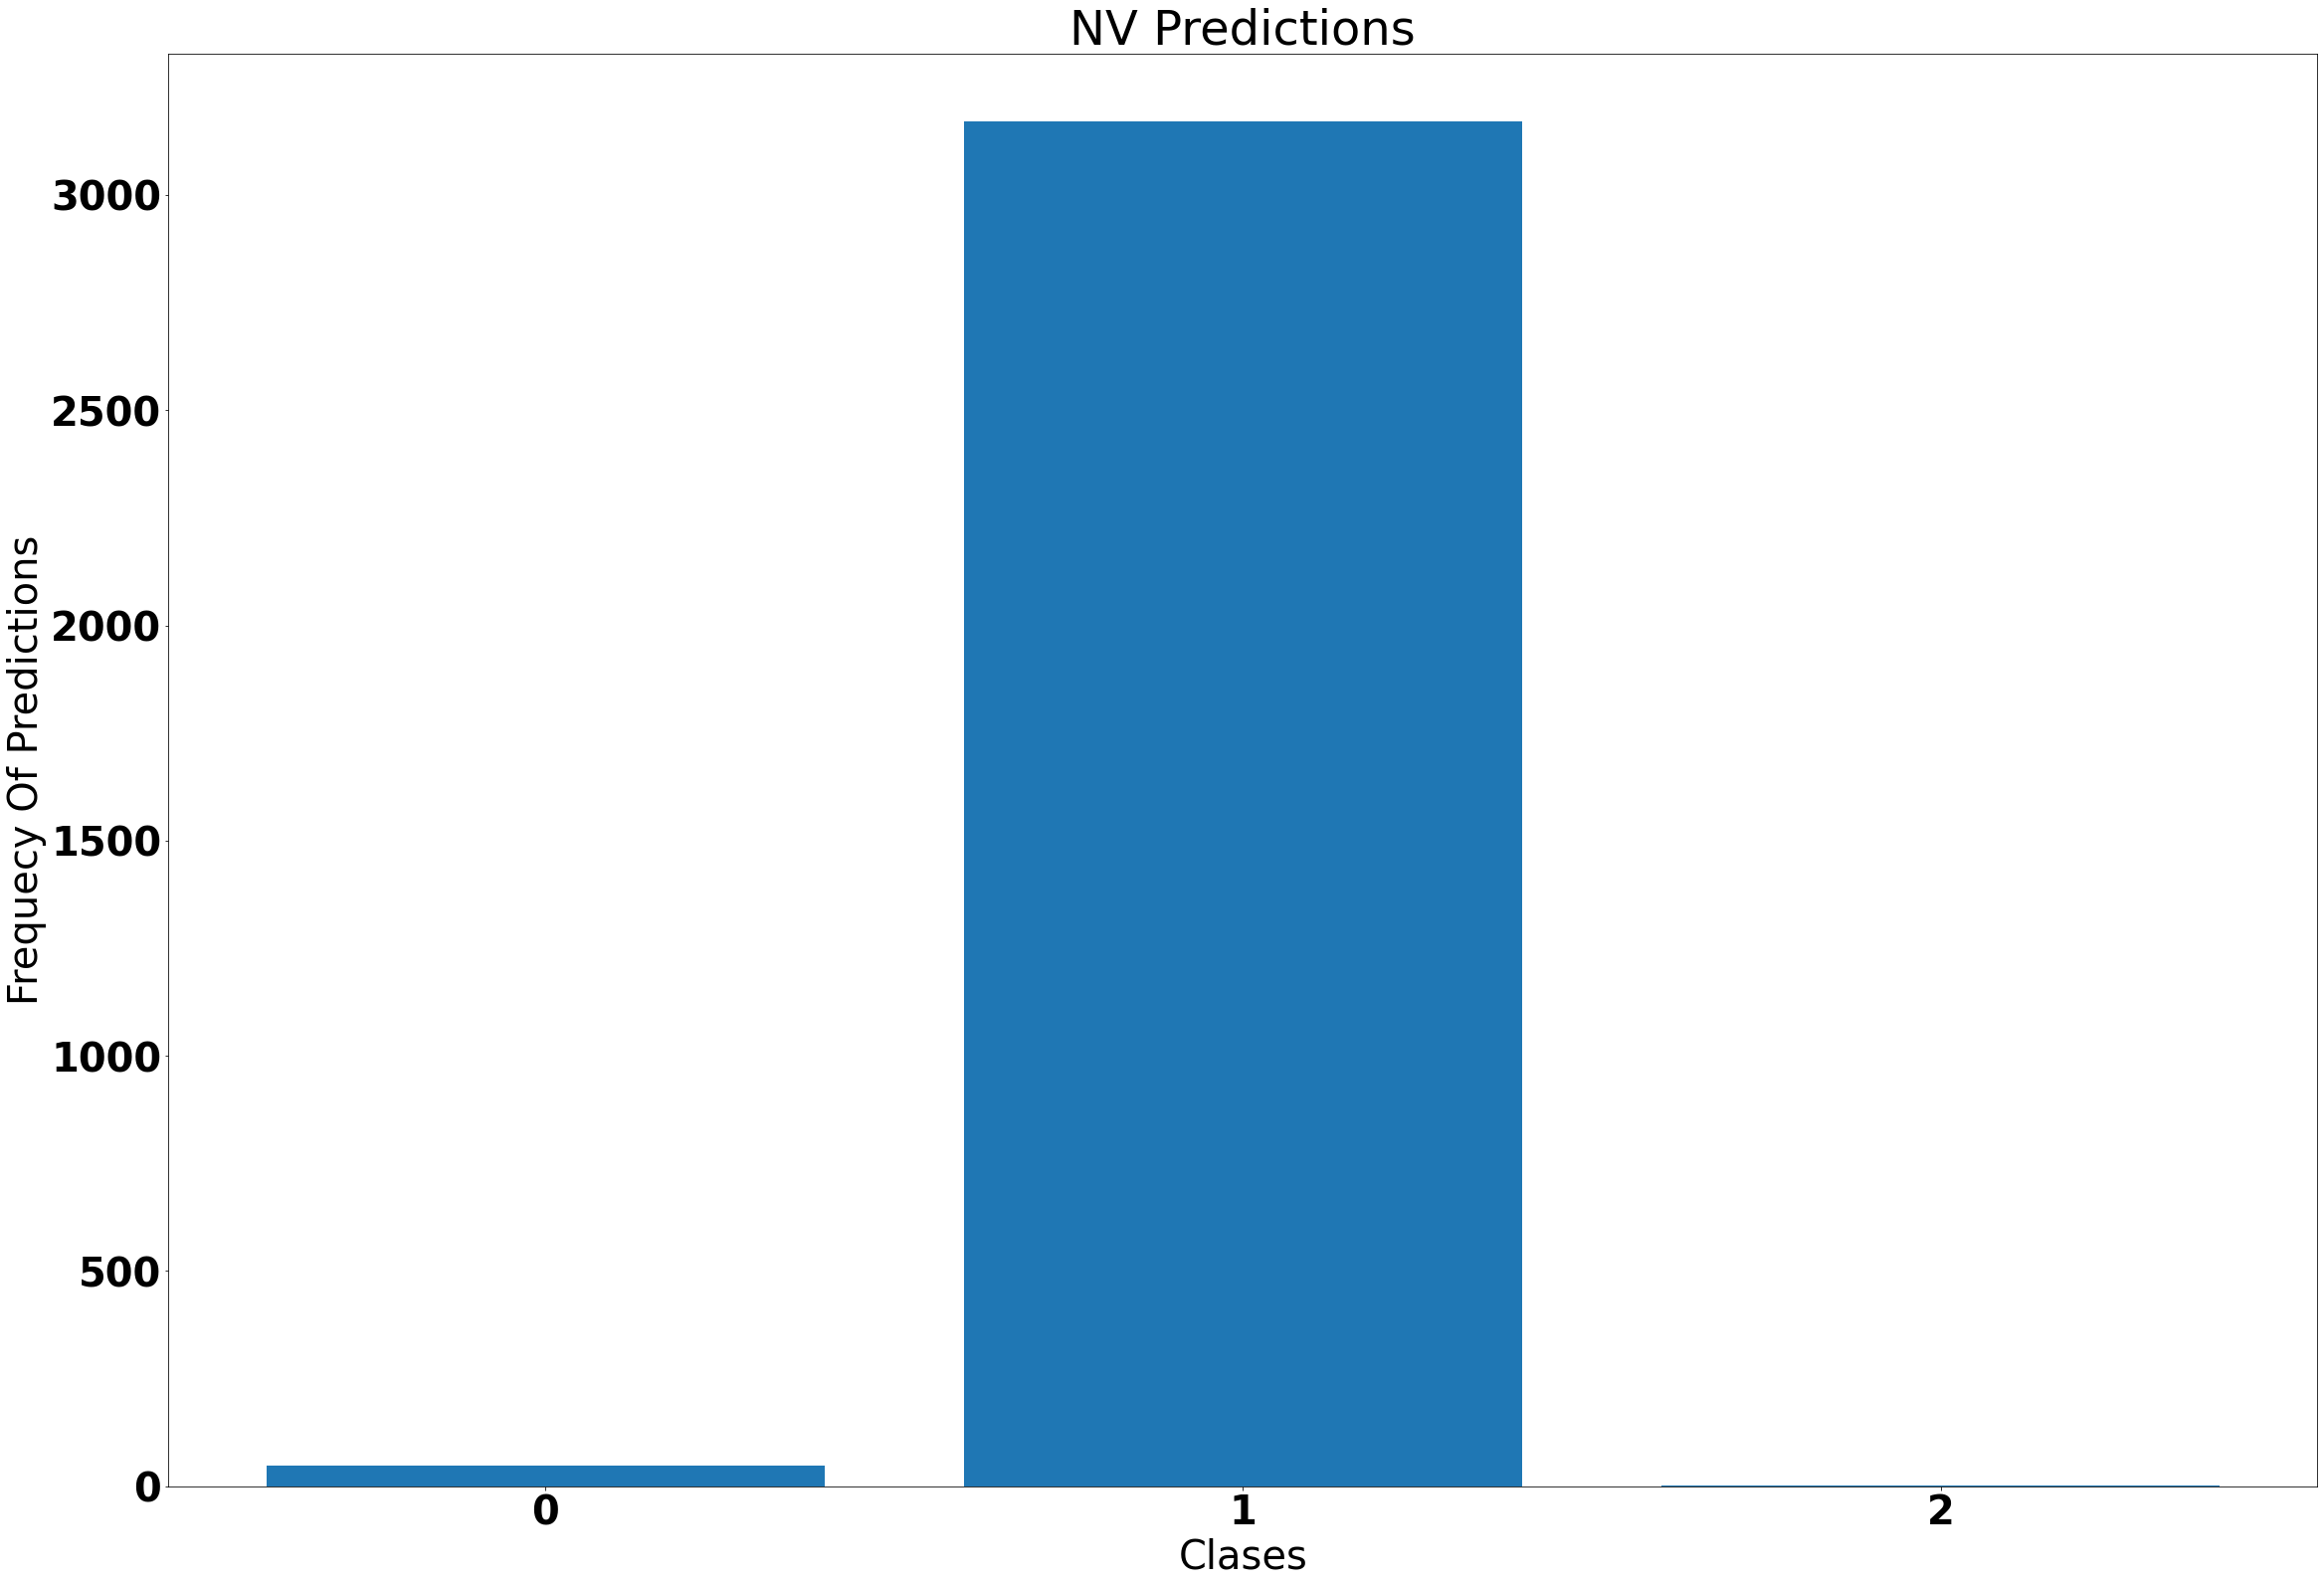

In [63]:
idx = 1
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)

Class #2


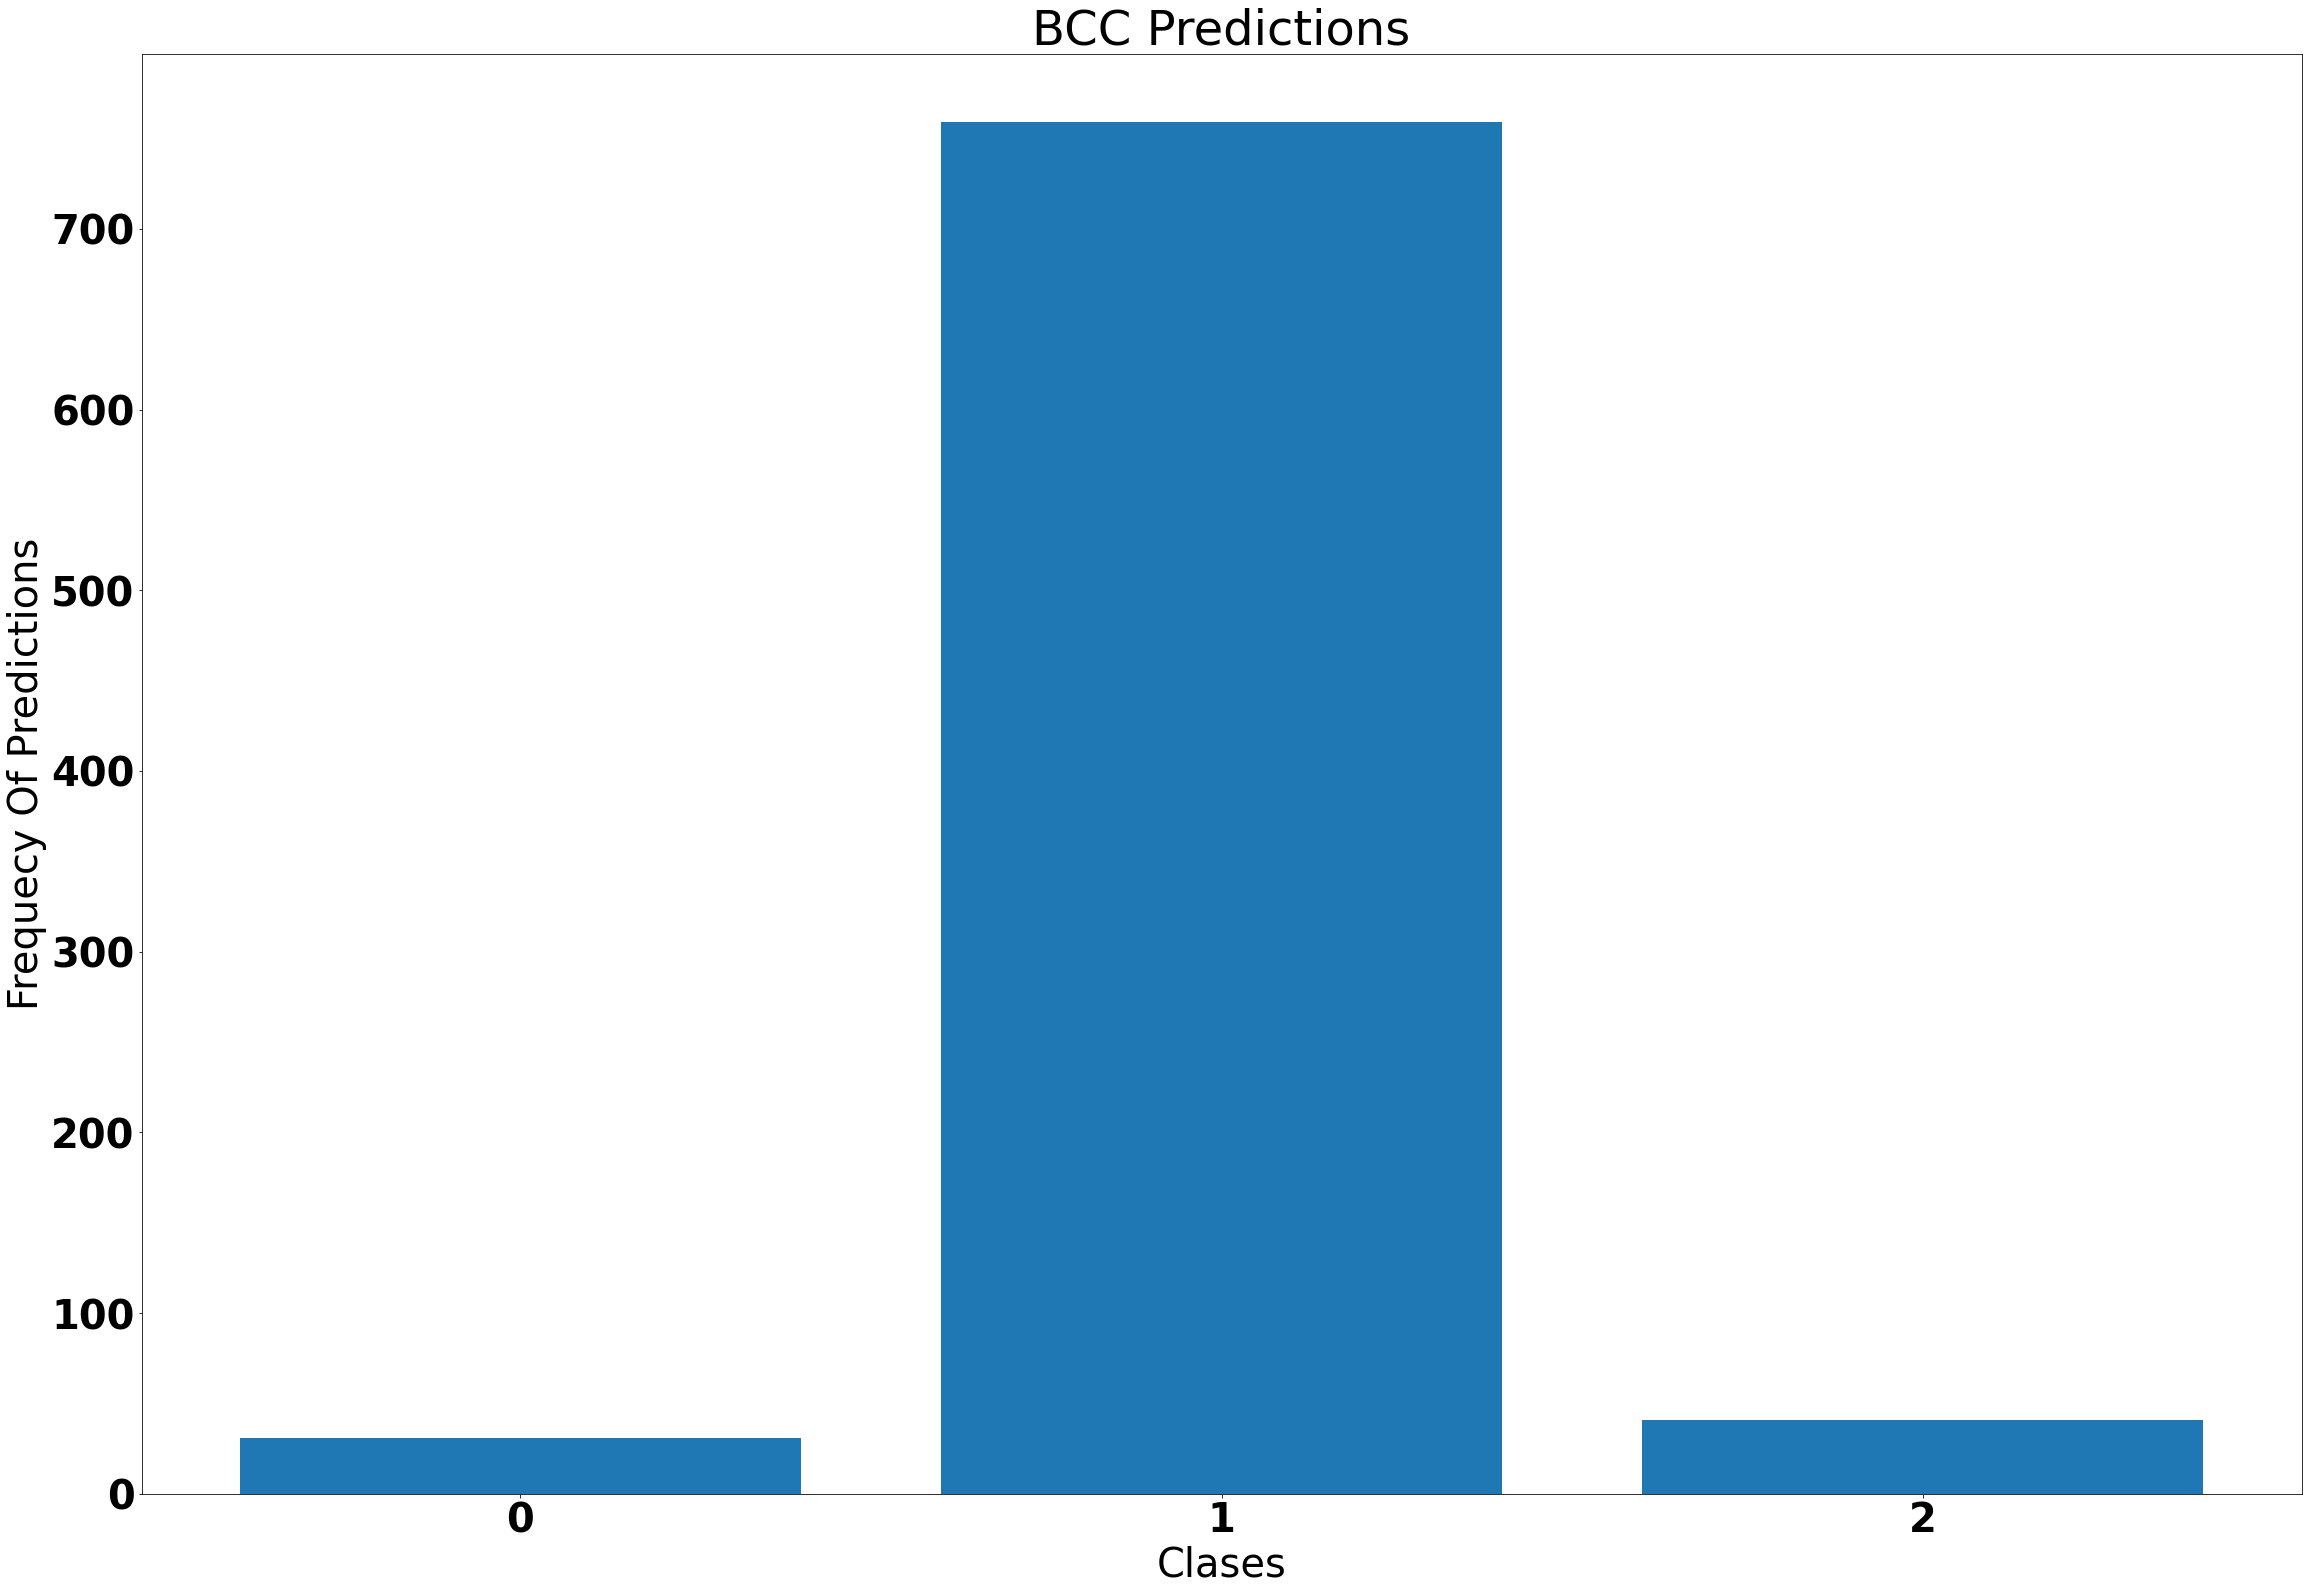

In [64]:
idx = 2
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)

Class #3


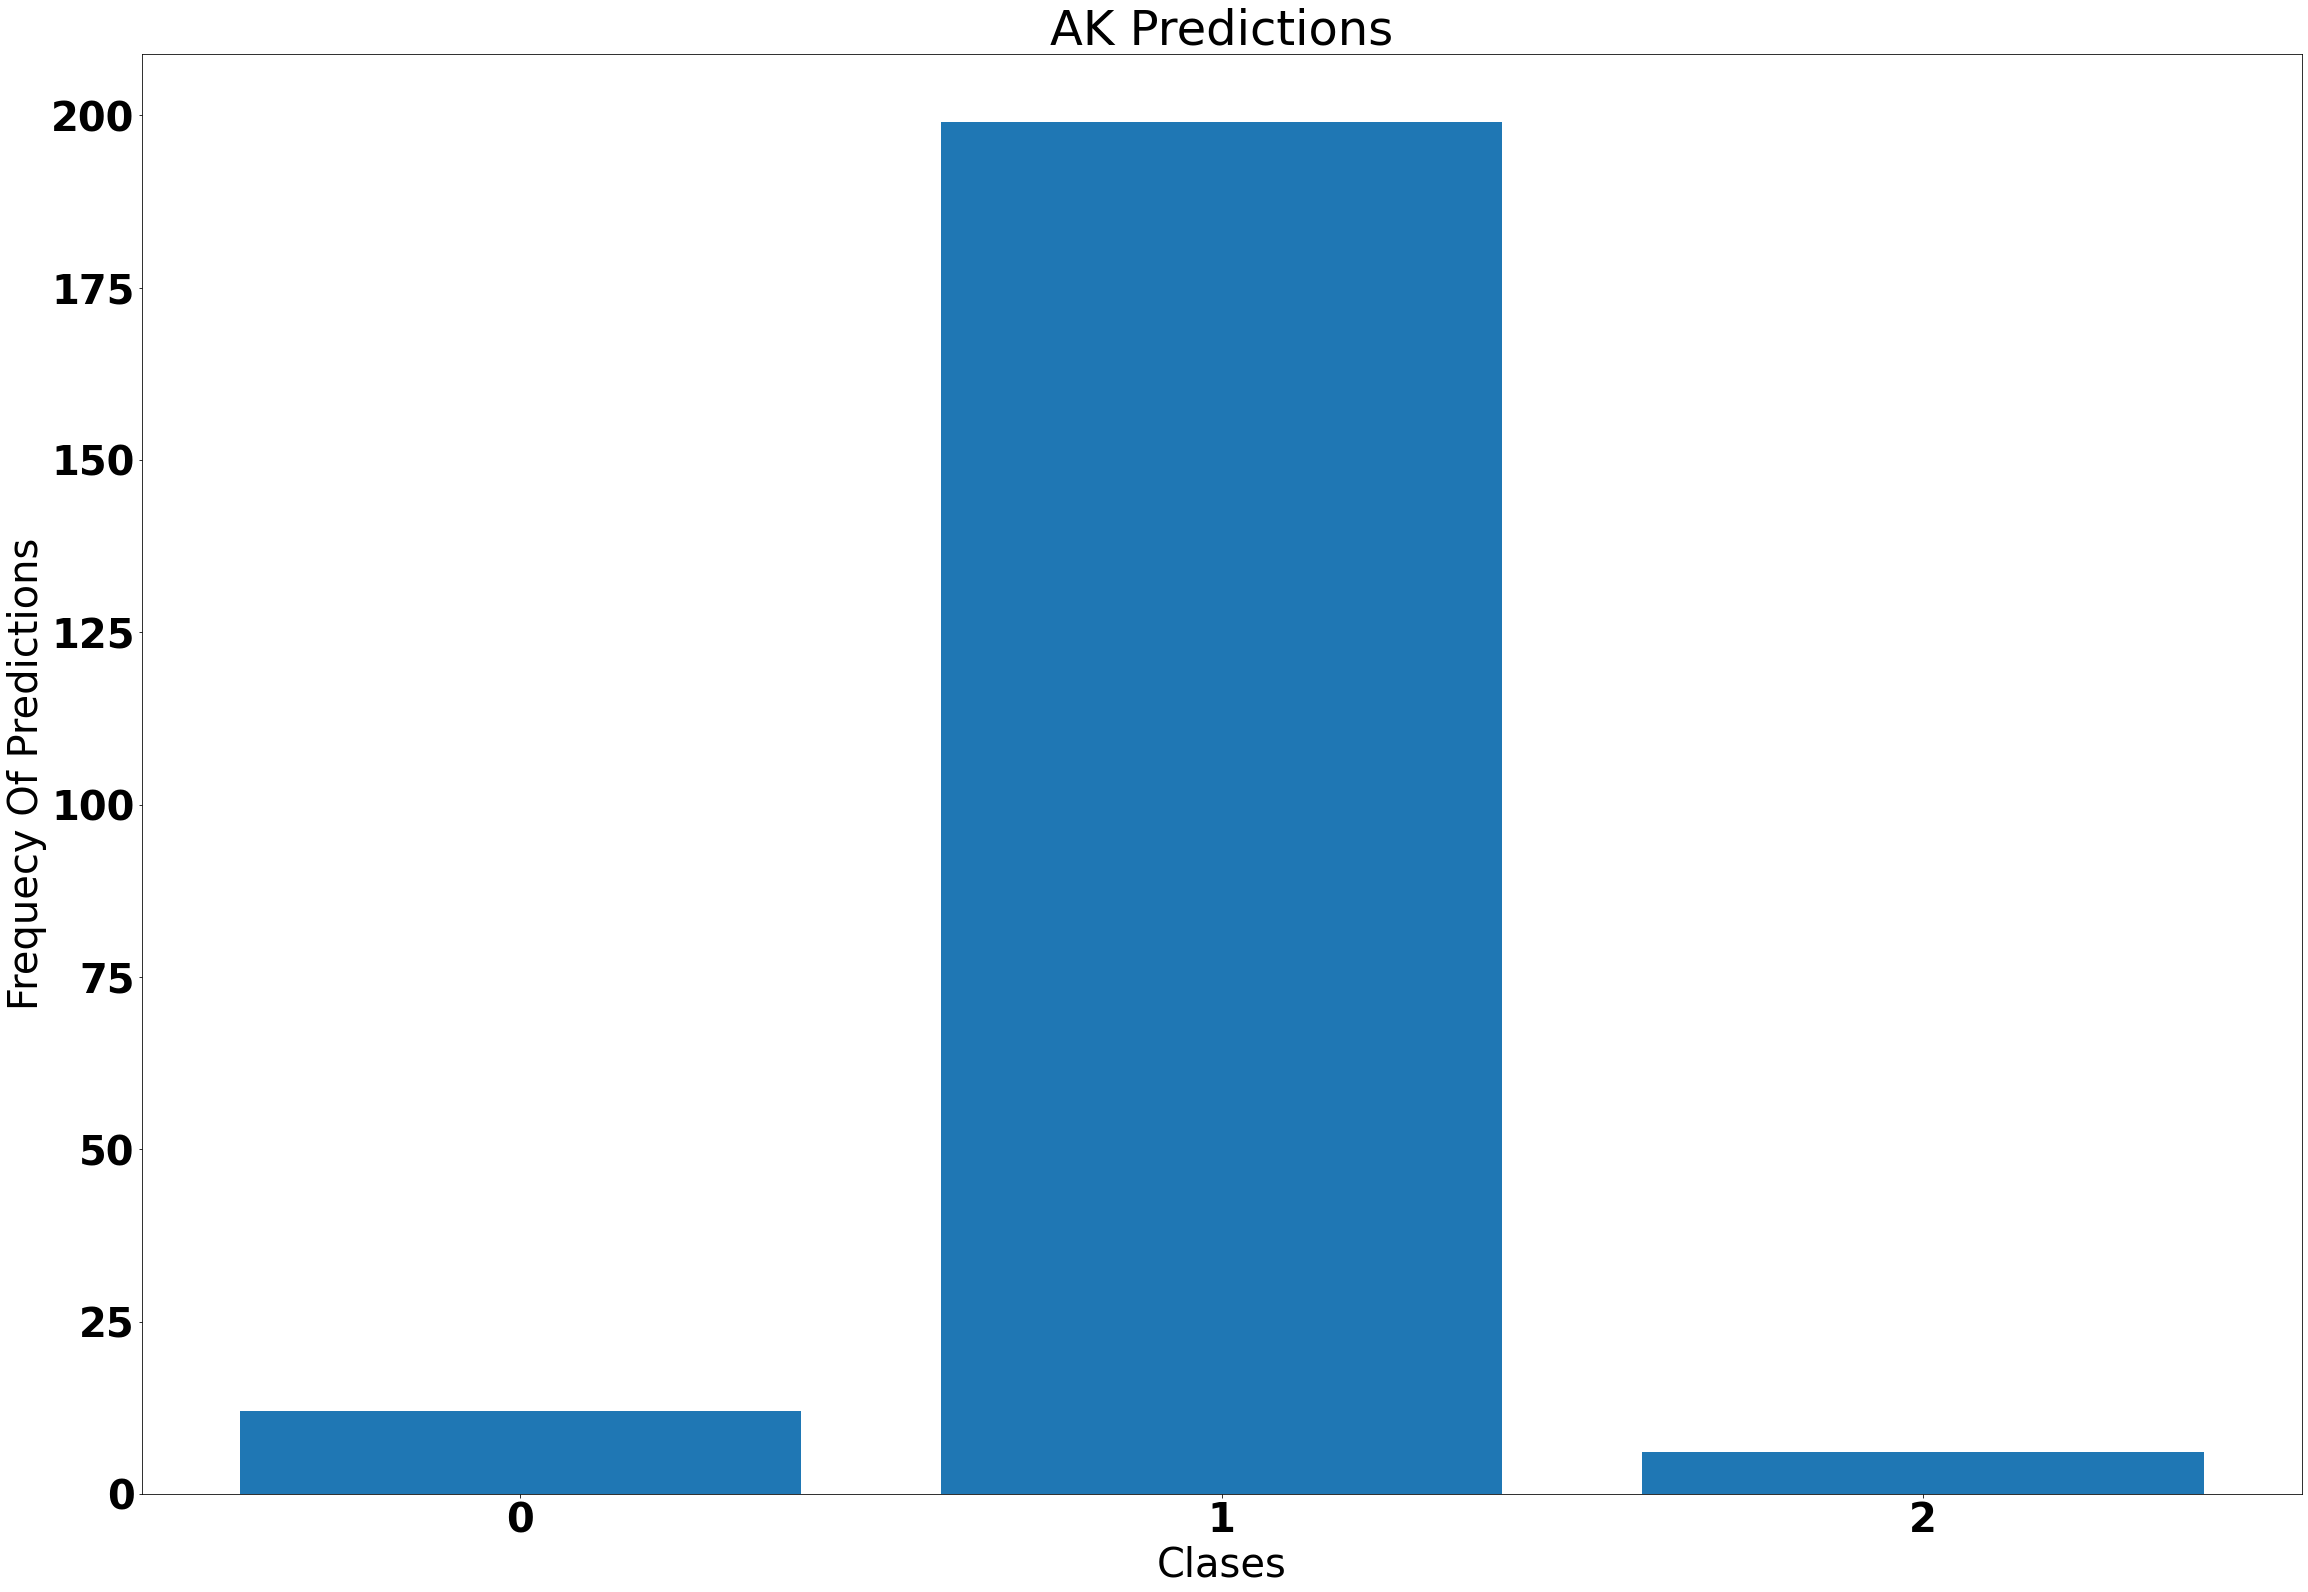

In [65]:
idx = 3
c = returnClassIndex(skin_testY_,idx)
preds = svote.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses)